# Comparação de Algoritmos de Otimização de Rotas

# Preparando os Dados

## Preparando Ambiente
Nessa etapa será criado um GeoDataFrame com os dados filtrados e prontos para serem utilizados pelos algoritmos.

Aqui será utilizado a base de dados do IBGE para extrair as informações referentes a cidade de Bauru, a qual sera feita o estudo dos algoritmos.

Nesse ponto é feita a criação de funções que criarão pontos aleatórios dentro dos limites de bauru, além da validação desses pontos e da obtenção dos endereços referentes as coordenadas encontradas, utilizando a API Here, juntamente com a biblioteca GeoPy para a conversão em endereço.

Ao final teremos um GeoDataFrame contendo o endereço, a latitude e longitude, o nó referente ao grafo da cidade de Bauru e o ponto geométrico referente a cada coordenada.

### Instalando dependências e importando bibliotecas

In [1]:
!pip install osmnx


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from shapely import Point
from geopy.geocoders import HereV7 as here
import pandas as pd
import geopandas as gpd
import random
import osmnx as ox
import networkx as nx
from google.colab import drive

drive.mount('/content/drive')
key = "chave-api-here"
geolocator = here(apikey=key)

caminho_arquivo_enderecos = "/content/drive/MyDrive/enderecos_bauru.geojson"

ModuleNotFoundError: No module named 'google.colab'

### Funções para validação e criação dos endereços

In [ ]:
def gerar_coordenadas_aleatorias(geodataframe: gpd.GeoDataFrame)->float:
  """
  Essa função gera coordenadas aleatórias dentro dos limites de um GeoDataFrame
  e retorna a latitude e a longitude de cada ponto.
  """
  min_x, min_y, max_x, max_y = geodataframe.total_bounds
  longitude = random.uniform(min_x, max_x)
  latitude = random.uniform(min_y, max_y)

  return latitude, longitude

In [ ]:
def validar_ponto(ponto: Point, geodataframe: gpd.GeoDataFrame)->Point:
  """
  Essa função verifica se um ponto existe dentro de alguma das geometrias do
  GeoDataFrame, se existir retorna o próprio ponto, caso não exista retorna None.
  """
  for i in range(len(geodataframe)):
    if ponto.within(geodataframe.geometry.iloc[i]):
      return ponto

In [ ]:
def obter_endereco(coordenadas: tuple)->str:
  """
  Essa função converte as coordenadas de um ponto em endereço, verificando se
  ele é válido, com número predial, retornando o endereço completo.
  """
  endereco = geolocator.reverse(coordenadas)
  if endereco and endereco.raw['resultType'] == 'houseNumber':
    if endereco.raw["address"]['district'] != 'Vale do Igapó':
      return endereco.address

In [ ]:
def encontrar_no(grafo: nx.MultiDiGraph, ponto: Point) -> int:
  """
  Essa função utiliza um ponto e procura seu nó correspondente no grafo
  da cidade, retornando o nó.
  """
  no = ox.distance.nearest_nodes(grafo, X = ponto.x, Y = ponto.y)

  return no

In [ ]:
def gerar_enderecos_validos(geodataframe: gpd.GeoDataFrame, grafo: nx.MultiDiGraph) -> dict:
  """
  Essa função cria endereços válidos, verificando se o ponto gerado existe,
  se o endereço referente ao ponto é válido e se existe um nó para aquele ponto,
  assim retornando um JSON com as propriedades do endereço.
  """
  while True:
    lat, lon = gerar_coordenadas_aleatorias(geodataframe)
    ponto = Point(lon, lat)
    if validar_ponto(ponto, geodataframe):
      endereco = obter_endereco((lat, lon))
      if endereco is not None:
        no_mapa = encontrar_no(grafo, ponto)
        if no_mapa is not None:
           return {
                    "endereco": endereco,
                    "latitude": lat,
                    "longitude": lon,
                    "no_mapa": no_mapa,
                    "geometry": ponto,
                  }

In [ ]:
def adicionar_enderecos_geodataframe(geodataframe_cidade: gpd.GeoDataFrame, grafo: nx.MultiDiGraph,
                                     quantidade_enderecos: int, crs: str,
                                     geodataframe_enderecos: gpd.GeoDataFrame = None) -> gpd.GeoDataFrame:
  """
  Essa função adiciona endereços no GeoDataFrame, ela verifica se já existe
  um GeoDataFrame, caso não ela o cria e depois adiciona os endereços nele,
  caso já exista ela adiciona os novos endereços sem sobreescrever os antigos.
  """
  if geodataframe_enderecos is None:
    geodataframe_enderecos = gpd.GeoDataFrame({
                'endereco': pd.Series(dtype='str'),
                'latitude': pd.Series(dtype='float'),
                'longitude': pd.Series(dtype='float'),
                'no_mapa': pd.Series(dtype='int'),
                'geometry': pd.Series(dtype='geometry')
            }, geometry='geometry', crs=crs)

  novos_adicionados = 0

  while novos_adicionados < quantidade_enderecos:
    novo_endereco = gerar_enderecos_validos(geodataframe_cidade, grafo)

    if novo_endereco["endereco"] not in geodataframe_enderecos["endereco"].values:
      geodataframe_enderecos = pd.concat(
        [geodataframe_enderecos, gpd.GeoDataFrame([novo_endereco], geometry='geometry', crs=crs)],
          ignore_index=True)
      novos_adicionados += 1
      print(f"[{novos_adicionados}/{quantidade_enderecos}] Endereço adicionado: {novo_endereco['endereco']}")
    else:
      print("Endereço duplicado. Pulando.")

  return geodataframe_enderecos


### Importação de dados não filtrados e criação de váriaveis

Aqui estou importando os dados diretamente do IBGE, criando um GeoDataFrame geral de todas as cidades do estado de São Paulo, depois crio um novo GeoDataFrame com apenas da área urbana de Bauru. Também e feita a criação do grafo de Bauru para marcação dos pontos de entrega a partir dos nós referentes as coordenadas geográficas.

In [ ]:
url = "https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_de_setores_censitarios__divisoes_intramunicipais/censo_2022/setores/shp/UF/SP_setores_CD2022.zip"
gdf_cidades_sp = gpd.read_file(url)

In [ ]:
gdf_bauru = gdf_cidades_sp[(gdf_cidades_sp['NM_MUN'] == "Bauru") & (gdf_cidades_sp["SITUACAO"] == "Urbana")]

In [ ]:
grafo_bauru = ox.graph.graph_from_place("Bauru, SP, Brazil", network_type="drive", simplify=False)

In [ ]:
crs = "EPSG:4326"

### Criação do GeoDataFrame de endereços válidos em Bauru

### ⚠ Não executar novamente estas células, pois substituíra todos os endereços salvos


Nesse momento é criado um primeiro GeoDataFrame com 10 endereços para teste das funções.

Esse GeoDataFrame foi salvo no Google Drive para utilização futura.

In [ ]:
gdf_enderecos = adicionar_enderecos_geodataframe(gdf_bauru, grafo_bauru, 10, crs)

In [ ]:
gdf_enderecos

In [ ]:
gdf_enderecos.to_file(caminho_arquivo_enderecos, driver="GeoJSON")

### Adicionando novos endereços no GeoDataFrame

Aqui foi adicionado levas de 100 endereços por execução até atingir o valor de 1000 endereços válidos.

A execução de 100 endereços por vez foi devido ao consumo da API Here que tem um limite diário restrito no plano gratuito, então para não exceder esse limite foram feitas várias execuções.

A cada execução o arquivo geojson que possui os endereços era atualizado por com a adição dos novos endereços. Essa atualização se da a partir da substituição do arquivo desatualizado.

In [ ]:
enderecos_bauru = gpd.read_file(caminho_arquivo_enderecos)

In [ ]:
enderecos_bauru

endereco   latitude  longitude  \
0    Rua Luiz Bleriot, 11-68, Vila Aviação, Bauru -... -22.351077 -49.048641   
1    Avenida Castelo Branco, 26-46, Vila São João d... -22.349645 -49.100626   
2    Rua Mário Gonzaga Junqueira, 58, Parque Viadut... -22.337915 -49.112117   
3    Avenida Octávio Mangabeira, 4-29, Vila Coralin... -22.321082 -49.051560   
4    Avenida Pinheiro Machado, 9-47, Jardim Rosa Br... -22.317145 -49.096922   
..                                                 ...        ...        ...   
895  Rua Eugênio Borro, 2-6, Vila Becheli, Bauru - ... -22.314698 -49.090450   
896  Rua Neusa Gonçalves de Souza, 1-35, Jardim Sil... -22.294509 -49.052341   
897  Rua Gérson França, 40, Vila Nova Santa Clara, ... -22.337261 -49.073292   
898  Rua Doutor Adolfo Lutz, 1-32, Centro, Bauru - ... -22.327767 -49.071032   
899  Rua José Pinelli, 10, Dist. Ind. Marcus V. Fel... -22.315056 -48.984816   

        no_mapa                     geometry  
0    1928268176  POINT (-49.04864 -22.35108)  
1    1957769938  POINT (-49.10063 -22.34965)  
2    1956624037  POINT (-49.11212 -22.33791)  
3    1947381924  POINT (-49.05156 -22.32108)  
4    1932212220  POINT (-49.09692 -22.31715)  
..          ...                          ...  
895  1932212574   POINT (-49.09045 -22.3147)  
896  1947566794  POINT (-49.05234 -22.29451)  
897  1926580368  POINT (-49.07329 -22.33726)  
898  1958194703  POINT (-49.07103 -22.32777)  
899  3824909909  POINT (-48.98482 -22.31506)  

[900 rows x 5 columns]

In [ ]:
enderecos_bauru = adicionar_enderecos_geodataframe(gdf_bauru, grafo_bauru, 100, crs, enderecos_bauru)

[1/100] Endereço adicionado: Rua Sebastião Ferraz da Costa, 55, Vila São Paulo, Bauru - SP, 17022-114, Brasil
[2/100] Endereço adicionado: Rua Doutor Olympio Avallone, 1, Jardim São Judas, Bauru - SP, 17039-400, Brasil
[3/100] Endereço adicionado: Rua Goiás, 2-30, Vila Cardia, Bauru - SP, 17013-610, Brasil
[4/100] Endereço adicionado: Rua Araújo Leite, 25-10, Vila Santa Tereza, Bauru - SP, 17012-055, Brasil
[5/100] Endereço adicionado: Rua Aldo Apparecido Marcelino, 1-53, Jardim Andorfato, Bauru - SP, 17066-092, Brasil
[6/100] Endereço adicionado: Rua Raul Crevelente Guedini, 3-40, Núcleo Habitacional José Regino, Bauru - SP, 17031-710, Brasil
[7/100] Endereço adicionado: Rua Arthur Gonçalves, 44, Núcleo Residencial Beija-Flor, Bauru - SP, 17025-460, Brasil
[8/100] Endereço adicionado: Alameda Sibipirunas, 44, Parque Residencial Paineiras, Bauru - SP, 17018-345, Brasil
[9/100] Endereço adicionado: Rua Amadeu Scudeller, 1-66, Quinta Bela Olinda, Bauru - SP, 17023-510, Brasil
[10/100] En

In [ ]:
enderecos_bauru

endereco   latitude  longitude  \
0    Rua Luiz Bleriot, 11-68, Vila Aviação, Bauru -... -22.351077 -49.048641   
1    Avenida Castelo Branco, 26-46, Vila São João d... -22.349645 -49.100626   
2    Rua Mário Gonzaga Junqueira, 58, Parque Viadut... -22.337915 -49.112117   
3    Avenida Octávio Mangabeira, 4-29, Vila Coralin... -22.321082 -49.051560   
4    Avenida Pinheiro Machado, 9-47, Jardim Rosa Br... -22.317145 -49.096922   
..                                                 ...        ...        ...   
995  Rua Adolpho Serson, 95, Chácaras Cornélia, Bau... -22.337606 -49.118004   
996  Rua Elídio Fortunato Fernandes, 4-31, Parque J... -22.318892 -49.022263   
997  Rua Silveira Martins, 4-18, Vila Souto, Bauru ... -22.328340 -49.089593   
998  Rua Yoichi Ogihara, 2-125, Parque Jaraguá, Bau... -22.304219 -49.115575   
999  Rua Virgílio Malta, 16, Vila Nova Santa Clara,... -22.336268 -49.071392   

        no_mapa                     geometry  
0    1928268176  POINT (-49.04864 -22.35108)  
1    1957769938  POINT (-49.10063 -22.34965)  
2    1956624037  POINT (-49.11212 -22.33791)  
3    1947381924  POINT (-49.05156 -22.32108)  
4    1932212220  POINT (-49.09692 -22.31715)  
..          ...                          ...  
995  1956624034    POINT (-49.118 -22.33761)  
996  1960989733  POINT (-49.02226 -22.31889)  
997  1956337011  POINT (-49.08959 -22.32834)  
998  1932794673  POINT (-49.11558 -22.30422)  
999  1926579588  POINT (-49.07139 -22.33627)  

[1000 rows x 5 columns]

In [ ]:
enderecos_bauru.to_file(caminho_arquivo_enderecos, driver="GeoJSON")

In [ ]:
enderecos_bauru = gpd.read_file(caminho_arquivo_enderecos)

In [ ]:
enderecos_bauru

endereco   latitude  longitude  \
0    Rua Luiz Bleriot, 11-68, Vila Aviação, Bauru -... -22.351077 -49.048641   
1    Avenida Castelo Branco, 26-46, Vila São João d... -22.349645 -49.100626   
2    Rua Mário Gonzaga Junqueira, 58, Parque Viadut... -22.337915 -49.112117   
3    Avenida Octávio Mangabeira, 4-29, Vila Coralin... -22.321082 -49.051560   
4    Avenida Pinheiro Machado, 9-47, Jardim Rosa Br... -22.317145 -49.096922   
..                                                 ...        ...        ...   
995  Rua Adolpho Serson, 95, Chácaras Cornélia, Bau... -22.337606 -49.118004   
996  Rua Elídio Fortunato Fernandes, 4-31, Parque J... -22.318892 -49.022263   
997  Rua Silveira Martins, 4-18, Vila Souto, Bauru ... -22.328340 -49.089593   
998  Rua Yoichi Ogihara, 2-125, Parque Jaraguá, Bau... -22.304219 -49.115575   
999  Rua Virgílio Malta, 16, Vila Nova Santa Clara,... -22.336268 -49.071392   

        no_mapa                     geometry  
0    1928268176  POINT (-49.04864 -22.35108)  
1    1957769938  POINT (-49.10063 -22.34965)  
2    1956624037  POINT (-49.11212 -22.33791)  
3    1947381924  POINT (-49.05156 -22.32108)  
4    1932212220  POINT (-49.09692 -22.31715)  
..          ...                          ...  
995  1956624034    POINT (-49.118 -22.33761)  
996  1960989733  POINT (-49.02226 -22.31889)  
997  1956337011  POINT (-49.08959 -22.32834)  
998  1932794673  POINT (-49.11558 -22.30422)  
999  1926579588  POINT (-49.07139 -22.33627)  

[1000 rows x 5 columns]

# Preparando os Algoritmos

## Prepando o Ambiente

Nessa etapa criei classes e funções para facilitar a execução dos algoritmos da biblioteca mlrose-hiive

### Instalando dependências e Importando as Bibliotecas

In [ ]:
!pip install osmnx networkx mlrose-hiive joblib==1.2.0 setuptools

In [ ]:
!pip install plotly --upgrade

In [ ]:
import geopandas as gpd
import pandas as pd
import osmnx as ox
import networkx as nx
import folium
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import math
import time
import mlrose_hiive
from folium.plugins import PolyLineTextPath

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
caminho_arquivo_enderecos = "/content/drive/MyDrive/TCC/enderecos_bauru.geojson"

### Classe e Funções de Manipulação dos Dados


Precisei criar uma classe no formato da classe TravelingSales da biblioteca mlrose_hiive, pois a resolução pela TSOpt que já é otimizada para algoritmos de rota, necessitava de uma classe fitness que possuisse a prob type 'tsp', então para validar minha função fitness que na classe se chama evaluate, precisei criar essa classe seguindo o formato da documentação da biblioteca.

In [ ]:
class FitnessTSP:
  """
  Classe de função de fitness personalizada para problemas do tipo TSP,
  utilizando distâncias assimétricas definidas em um dicionário.

  A função de fitness calcula a distância total de um caminho percorrendo os
  pontos na ordem especificada, sem retornar ao ponto de origem.
  """
  def __init__(self, dicionario_distancias: dict):
    """
    Inicializa a função de fitness com um dicionário de distâncias.
    """
    self.dicionario_distancias = dicionario_distancias
    self.prob_type = 'tsp'

  def evaluate(self, caminho: list) -> float:
    """
    Calcula a distância total de um caminho baseado no dicionário de distâncias
    e retorna a distância total do percurso.
    """
    distancia_total = 0
    for ponto in range(len(caminho) - 1):
      origem = caminho[ponto]
      destino = caminho[ponto + 1]
      distancia = self.dicionario_distancias[(origem, destino)]
      distancia_total += distancia

    return distancia_total

  def get_prob_type(self):
    """
    Retorna o tipo do problema.
    """
    return self.prob_type

In [ ]:
def obter_amostra_aleatoria_enderecos(geodataframe: gpd.GeoDataFrame, quantidade_enderecos: int, random_state: int = None) -> gpd.GeoDataFrame:
  """
  Essa função escolhe aleatoriamente uma quantidade n de endereços,
  podendo passar um random state para sempre selecionar os mesmos endereços,
  retornando um novo geodataframe com a amostra selecionada.
  """
  amostra = geodataframe.sample(n=quantidade_enderecos, random_state=random_state)

  return amostra

In [ ]:
def extrair_enderecos(amostra: gpd.GeoDataFrame) -> list:
  """
  Essa função extrai os endereços de cada ponto de um Geodataframe e retorna
  um array com cada endereço.
  """
  enderecos = []
  for linha in range(len(amostra)):
    endereco = amostra.iloc[linha]["endereco"]
    enderecos.append(endereco)

  return enderecos

In [ ]:
def extrair_coordenadas_enderecos(amostra: gpd.GeoDataFrame) -> list:
  """
  Essa função extrai as coordenadas de cada ponto de um Geodataframe e retorna
  um array de tuplas referente a latitude e longitude de cada ponto.
  """
  coordenadas = []
  for linha in range(len(amostra)):
    coordenada = (amostra.iloc[linha]["latitude"], amostra.iloc[linha]["longitude"])
    coordenadas.append(coordenada)

  return coordenadas

In [ ]:
def extrair_nos(amostra: gpd.GeoDataFrame) -> list:
  """
  Essa função extrai os nós de cada ponto de um Geodataframe e retorna
  um array com o nó que cada ponto representa no grafo da cidade.
  """
  nos = []
  for linha in range(len(amostra)):
    no = (amostra.iloc[linha]["no_mapa"])
    nos.append(no)

  return nos

In [ ]:
def calcular_distancia_linha_reta_entre_pontos(coordenadas: list) -> list:
  """
  Essa função faz o calculo da distância em linha reta entre um par de pontos,
  utilizando a curvatura da Terra e retorna uma matriz com as distâncias em
  quilômetros.
  """
  matriz_distancias_reta = []
  for origem in range(len(coordenadas)):
    for destino in range(len(coordenadas)):
      if origem != destino:
        distancia_reta = ox.distance.great_circle(coordenadas[origem][0], coordenadas[origem][1], coordenadas[destino][0], coordenadas[destino][1])
        distancia_km = distancia_reta / 1000
        matriz_distancias_reta.append((origem, destino, distancia_km))

  return matriz_distancias_reta

In [ ]:
def calcular_distancia_pelas_ruas_entre_pontos(grafo: nx.MultiDiGraph, nos: list) -> list:
  """
  Essa função faz o calculo da distância entre um par de pontos seguindo as
  ruas do grafo, utilizando os nós disponíveis e retorna uma matriz com as
  distâncias em quilômetros.
  """
  matriz_distancias_ruas = []
  for origem in range(len(nos)):
    for destino in range(len(nos)):
      if origem != destino:
        distancia = nx.shortest_path_length(grafo, source=nos[origem], target=nos[destino], weight='length')
        distancia_km = distancia / 1000
        matriz_distancias_ruas.append((origem, destino, distancia_km))

  return matriz_distancias_ruas

In [ ]:
def calcular_distancia_total(matriz_a: list, matriz_b: list) -> list:
  """
  Essa função faz a somatória das distâncias entre duas matrizes diferentes e
  retorna uma nova matriz com a distância total.
  """
  distancia_total = []
  for dist in range(len(matriz_a)):
    origem = matriz_a[dist][0]
    destino = matriz_b[dist][1]
    distancia_somada = matriz_a[dist][2] + matriz_b[dist][2]
    distancia_total.append((origem, destino, distancia_somada))

  return distancia_total

In [ ]:
def transformar_matriz_em_dicionario(matriz: list) -> dict:
  """
  Essa função transforma uma matriz de distâncias em um dicionário de distâncias
  utilizando os conjunto de indíces da matriz para ser a chave do dicionário e a
  distância para ser o valor.
  """
  distancias = {}
  for i in range(len(matriz)):
    origem = matriz[i][0]
    destino = matriz[i][1]
    distancia_total = matriz[i][2]
    distancias[(origem, destino)] = distancia_total

  return distancias

In [ ]:
def preparar_fitness(grafo: nx.MultiDiGraph, coordenadas: list, nos: list) -> FitnessTSP:
  """
  Essa função calcula todas as distâncias e cria a fitness para os algoritmos.
  """
  matriz_distancias_linha_reta = calcular_distancia_linha_reta_entre_pontos(coordenadas)
  matriz_distancias_pelas_ruas = calcular_distancia_pelas_ruas_entre_pontos(grafo, nos)
  matriz_distancia_total = calcular_distancia_total(matriz_distancias_linha_reta, matriz_distancias_pelas_ruas)
  dicionario = transformar_matriz_em_dicionario(matriz_distancia_total)
  fitness = FitnessTSP(dicionario)

  return fitness

In [ ]:
def executar_testes_hill_climb(problema: mlrose_hiive.TSPOpt, random_state: int, execucoes: int) -> list:
  """
  Essa função executa o algoritmo Hill Climb n vezes e retorna uma lista de json
  com as informações de cada execução.
  """
  resultados = []
  for execucao in range(execucoes):
    inicio = time.time()
    _, best_fitness_hc, _ = mlrose_hiive.hill_climb(
      problema,
      random_state = random_state
    )
    tempo = time.time() - inicio
    resultado = {
        "Execução": execucao,
        "Distância Total": best_fitness_hc,
        "Tempo": tempo
    }

    resultados.append(resultado)


  return resultados

In [ ]:
def executar_testes_simulated_annealing(problema: mlrose_hiive.TSPOpt, iteracoes: list, temperaturas: list, resfriamentos:list, tentativas: list, random_state: int, execucoes: int) -> list:
  """
  Essa função executa o algoritmo Simulated Annealing n vezes e retorna uma lista de json
  com as informações de cada execução.
  """
  resultados = []
  for iteracao in iteracoes:
    for temperatura in temperaturas:
      for resfriamento in resfriamentos:
        for tentativa in tentativas:
          for execucao in range(execucoes):
            inicio = time.time()
            _, best_fitness_sa, _ = mlrose_hiive.simulated_annealing(
              problema,
              schedule=mlrose_hiive.GeomDecay(init_temp=temperatura, decay=resfriamento, min_temp=0.001),
              max_attempts=tentativa,
              max_iters=iteracao,
              random_state = random_state
            )
            tempo = time.time() - inicio
            resultado = {
                "Execução": execucao,
                "Distância Total": best_fitness_sa,
                "Iterações": iteracao,
                "Temperatura": temperatura,
                "Resfriamento": resfriamento,
                "Tentativas": tentativa,
                "Tempo": tempo
            }

            resultados.append(resultado)

  return resultados

In [ ]:
def executar_testes_genetic_algorithm(problema: mlrose_hiive.TSPOpt, iteracoes: list, populacoes: list, mutacoes:list, tentativas: list, random_state: int, execucoes: int) -> list:
  """
  Essa função executa o algoritmo Genetic Algorithm n vezes e retorna uma lista de json
  com as informações de cada execução.
  """
  resultados = []
  for iteracao in iteracoes:
    for populacao in populacoes:
      for mutacao in mutacoes:
        for tentativa in tentativas:
          for execucao in range(execucoes):
            inicio = time.time()
            _, best_fitness_ga, _ = mlrose_hiive.genetic_alg(
                problema,
                pop_size=populacao,
                mutation_prob=mutacao,
                max_attempts=tentativa,
                max_iters=iteracao,
                random_state = random_state
            )
            tempo = time.time() - inicio
            resultado = {
                "Execução": execucao,
                "Distância Total": best_fitness_ga,
                "Iterações": iteracao,
                "População": populacao,
                "Mutação": mutacao,
                "Tentativas": tentativa,
                "Tempo": tempo
            }

            resultados.append(resultado)

  return resultados

In [ ]:
def executar_exaustao_hill_climb(problema: mlrose_hiive.TSPOpt, execucoes: int, random_state: int = None)  -> list:
  """
  Essa função executa o algoritmo Hill Climb n vezes e retorna uma lista de json
  com as informações de cada execução.
  """
  resultados = []
  for execucao in range(execucoes):
    inicio = time.time()
    best_state_hc, best_fitness_hc, _ = mlrose_hiive.hill_climb(
      problema,
      random_state = random_state
    )
    tempo = time.time() - inicio
    resultado = {
        "Execução": execucao,
        "Distância Total": best_fitness_hc,
        "Melhor Caminho": best_state_hc,
        "Tempo de Execução": tempo
    }

    resultados.append(resultado)


  return resultados

In [ ]:
def executar_exaustao_simulated_annealing(problema: mlrose_hiive.TSPOpt, iteracoes: int, temperatura: float, resfriamento: float, tentativas: int, execucoes: int, random_state: int = None) -> list:
  """
  Essa função executa o algoritmo Simulated Annealing n vezes e retorna uma lista de json
  com as informações de cada execução.
  """
  resultados = []
  for execucao in range(execucoes):
    inicio = time.time()
    best_state_sa, best_fitness_sa, _ = mlrose_hiive.simulated_annealing(
      problema,
      schedule=mlrose_hiive.GeomDecay(init_temp=temperatura, decay=resfriamento, min_temp=0.001),
      max_attempts=tentativas,
      max_iters=iteracoes,
      random_state = random_state
    )
    tempo = time.time() - inicio
    resultado = {
        "Execução": execucao,
        "Distância Total": best_fitness_sa,
        "Melhor Caminho": best_state_sa,
        "Iterações": iteracoes,
        "Temperatura": temperatura,
        "Resfriamento": resfriamento,
        "Tentativas": tentativas,
        "Tempo de Execução": tempo
    }

    resultados.append(resultado)

  return resultados

In [ ]:
def executar_exaustao_genetic_algorithm(problema: mlrose_hiive.TSPOpt, iteracoes: int, populacao: int, mutacao: float, tentativas: int, execucoes: int, random_state: int = None) -> list:
  """
  Essa função executa o algoritmo Genetic Algorithm n vezes e retorna uma lista de json
  com as informações de cada execução.
  """
  resultados = []
  for execucao in range(execucoes):
    inicio = time.time()
    best_state_ga, best_fitness_ga, _ = mlrose_hiive.genetic_alg(
        problema,
        pop_size=populacao,
        mutation_prob=mutacao,
        max_attempts=tentativas,
        max_iters=iteracoes,
        random_state = random_state
    )
    tempo = time.time() - inicio
    resultado = {
        "Execução": execucao,
        "Distância Total": best_fitness_ga,
        "Melhor Caminho": best_state_ga,
        "Iterações": iteracoes,
        "População": populacao,
        "Mutação": mutacao,
        "Tentativas": tentativas,
        "Tempo de Execução": tempo
    }

    resultados.append(resultado)

  return resultados

### Funções para Criação de Mapas e Desenho de Rotas

In [ ]:
def marcar_pontos_mapa(nome_mapa: str, localizacao_ponto_central: tuple, pontos_entrega: list, enderecos: list) -> folium.Map:
  """
  Essa função cria um mapa e marca os pontos de entregas em suas respectivas
  localizações.
  """
  nome_mapa = folium.Map(location = localizacao_ponto_central, zoom_start=13)
  for ponto in range (len(pontos_entrega)):
      folium.Marker(
        location=pontos_entrega[ponto],
        tooltip=ponto,
        popup=enderecos[ponto],
        icon=folium.Icon(color='blue', icon='box', prefix='fa'),
  ).add_to(nome_mapa)

  return nome_mapa


In [ ]:
def gerar_coordenadas_rota_reta(grafo: nx.MultiDiGraph, nos_entrega: list, caminho: list) -> list:
  """
  Essa função cria um array com as coordenadas de cada nó do grafo referente ao
  caminho que deve ser seguido para a entrega e retorna uma lista com essas
  coordenadas para que possa ser desenhada uma linha reta sobre o mapa.
  """
  rota_reta = []
  for ponto_rota in range(len(caminho)):
    coordenadas = ((grafo.nodes[nos_entrega[caminho[ponto_rota]]]['y']), (grafo.nodes[nos_entrega[caminho[ponto_rota]]]['x']))
    rota_reta.append(coordenadas)

  return rota_reta

In [ ]:
def gerar_nos_ruas_entrega(grafo: nx.MultiDiGraph, nos_entrega: list, caminho: list) -> list:
  """
  Essa função gera os nós seguindo as ruas entre um par de pontos, retornando um
  array com todos os nós para serem transformados em coordenadas.
  """
  nos_ruas = []
  for i in range(len(caminho) - 1):
    ruas = nx.shortest_path(grafo, source=nos_entrega[caminho[i]], target=nos_entrega[caminho[i+1]], weight='length')
    nos_ruas.append(ruas)

  return nos_ruas

In [ ]:
def gerar_coordenadas_rota_pelas_ruas(grafo: nx.MultiDiGraph, nos_entrega: list, caminho: list) -> list:
  """
  Essa função gera as coordenadas para cada nó seguindo as ruas do grafo, para
  que possa ser desenhada um linha através das ruas seguindo o percurso.
  """
  rota_ruas = gerar_nos_ruas_entrega(grafo, nos_entrega, caminho)
  coordenada_rota = []
  for i in range(len(rota_ruas)):
    for j in range(len(rota_ruas[i])):
      coordenadas = ((grafo_bauru.nodes[rota_ruas[i][j]]['y']), (grafo_bauru.nodes[rota_ruas[i][j]]['x']))
      coordenada_rota.append(coordenadas)

  return coordenada_rota

In [ ]:
def desenhar_rota(mapa: folium.Map, rota: list, cor: str) -> folium.Map:
  """
  Essa função atualiza um mapa existente desanhado sobre ele as linhas que
  indicam a rota a ser percorrida entre os pontos.
  """
  rota_desenhada = folium.PolyLine(locations=rota, color=cor, weight=5, opacity=0.7).add_to(mapa)
  attr = {"fill": "#000000", "font-weight": "bold", "font-size": "24"}

  folium.plugins.PolyLineTextPath(
      rota_desenhada, "> ", repeat=True, attributes=attr
  ).add_to(mapa)

  return rota_desenhada

## Executando Testes Iniciais

Esses testes serão para medir a eficiência dos algoritmos e testar o funcionamento das funções. Nesse momento será utilizado um ambiente controlado, no qual utilizarei o random_state para manter os pontos de entrega e o caminho inicial de cada algoritmo o mesmo.

### Criando o Grafo e Adicionando GeoDataFrame de endereços

In [ ]:
grafo_bauru = ox.graph.graph_from_place("Bauru, SP, Brazil", network_type="drive", simplify=False)
enderecos_bauru = gpd.read_file(caminho_arquivo_enderecos)
centro_bauru = (-22.318011, -49.069345)

In [ ]:
numero_pontos = 20
random_state = 10

### Fazendo a Extração da Amostra de endereços e Gerando um Mapa com os pontos

In [ ]:
amostra_enderecos = obter_amostra_aleatoria_enderecos(enderecos_bauru, numero_pontos, random_state)

In [ ]:
enderecos = extrair_enderecos(amostra_enderecos)
coordenadas_entregas = extrair_coordenadas_enderecos(amostra_enderecos)
nos_entregas = extrair_nos(amostra_enderecos)

In [ ]:
mapa = marcar_pontos_mapa("mapa", centro_bauru, coordenadas_entregas, enderecos)
mapa

### Calculando a Distância entre os pontos

In [ ]:
distancia_linha_reta = calcular_distancia_linha_reta_entre_pontos(coordenadas_entregas)

In [ ]:
distancia_pelas_ruas = calcular_distancia_pelas_ruas_entre_pontos(grafo_bauru, nos_entregas)

In [ ]:
distancia_total = calcular_distancia_total(distancia_linha_reta, distancia_pelas_ruas)

In [ ]:
distancia_dicionario = transformar_matriz_em_dicionario(distancia_total)

In [ ]:
fitness = FitnessTSP(distancia_dicionario)

### Executando os Algoritmos no Default

In [ ]:
problema = mlrose_hiive.TSPOpt(length=numero_pontos, fitness_fn=fitness, maximize=False)

In [ ]:
best_state_hc, best_fitness_hc, curve_hc = mlrose_hiive.hill_climb(
    problema,
    curve = True,
    random_state = random_state
)

In [ ]:
print("Hill Climbing:")
print("  Rota:", best_state_hc)
print("  Distância total:", best_fitness_hc)

Hill Climbing:
  Rota: [12  7  5  6 10 15 13  2  3  1 17 19  8  9 14  0 16 18  4 11]
  Distância total: 100.08514755107184


In [ ]:
schedule = mlrose_hiive.GeomDecay(init_temp=1.0, decay=0.99, min_temp=0.001)

best_state_sa, best_fitness_sa, curve_sa = mlrose_hiive.simulated_annealing(
    problema,
    schedule=schedule,
    max_attempts=10,
    max_iters=1000,
    curve = True,
    random_state = random_state
)

In [ ]:
print("\nSimulated Annealing:")
print("  Rota:", best_state_sa)
print("  Distância total:", best_fitness_sa)


Simulated Annealing:
  Rota: [ 5  6 15 10 13  2  3  7  8 14 17  1 12 16  9 19  0 18  4 11]
  Distância total: 136.40960057752508


In [ ]:
best_state_ga, best_fitness_ga, curve_ga = mlrose_hiive.genetic_alg(
    problema,
    pop_size=200,
    mutation_prob=0.1,
    max_attempts=10,
    max_iters=1000,
    curve = True,
    random_state = random_state
)

In [ ]:
print("\nGenetic Algorithm:")
print("  Rota:", best_state_ga)
print("  Distância total:", best_fitness_ga)


Genetic Algorithm:
  Rota: [11  4  0 14  9  8 19 13  2  3 12  5  7 15  6 10 17  1 16 18]
  Distância total: 110.54739429134578


## Refinando os algoritmos para os testes de estresse

Nessa etapa irei executar os algoritmos 10 vezes, testando diferentes parâmetros em diferentes quantidades de pontos de entrega, para fazer um refinamento mais preciso para os testes de estresse que serão realizados mais a frente.

Nestes testes irei utilizar o random_state 10, para gerar os pontos de entregas, para que os resultados sejam coerentes e replicáveis, de início serão utilizados os parâmetros a seguir, e conforme os resultados dos testes irei fazendo variações nos parâmetros para encontrar o que apresente o melhor desempenho referente a menor distância encontrada e o menor tempo de execução.

### Parametros:
- Número de pontos de entregas: 10, 30, 50, 100.

  ### Hill Climb
  - Como estou utilizando o Hill Climb na sua forma clássica, ou seja, sem restarts aletórios para buscar melhorias em sua solução. Irei executar o algoritmo nos testes de refinamento para comprovar que seu comportamento é o de escolher uma solução que ele ache ser boa sem melhorias.

  ### Simulated Annealing
  - Máximo de iterações: 2000.
  - init_temp: 1.0, 10.0, 100.0.
  - decay: 0.99, 0.95, 0.90.
  - max_attempts: 50.

  ### Genetic Algorithm
  - Máximo de iterações: 500.
  - pop_size: 50, 100, 200.
  - mutation_prob: 0.05, 0.1, 0.2.
  - max_attempts: 40.


In [ ]:
grafo_bauru = ox.graph.graph_from_place("Bauru, SP, Brazil", network_type="drive", simplify=False)
enderecos_bauru = gpd.read_file(caminho_arquivo_enderecos)
random_state = 10
execucoes = 10
numero_pontos = [10, 30, 50, 100]

### **Testes com 10 pontos**

In [ ]:
amostra_10 = obter_amostra_aleatoria_enderecos(enderecos_bauru, numero_pontos[0], random_state)
coordenadas_10_entregas = extrair_coordenadas_enderecos(amostra_10)
nos_10_entregas = extrair_nos(amostra_10)
fitness_10 = preparar_fitness(grafo_bauru, coordenadas_10_entregas, nos_10_entregas)
problema_10 = mlrose_hiive.TSPOpt(length=numero_pontos[0], fitness_fn=fitness_10, maximize=False)

#### **Hill Climb**

In [ ]:
hc_10 = executar_testes_hill_climb(problema_10, random_state, execucoes)

In [ ]:
hc_10

[{'Execução': 0,
  'Distância Total': np.float64(58.525301965394135),
  'Tempo': 0.0026993751525878906},
 {'Execução': 1,
  'Distância Total': np.float64(58.525301965394135),
  'Tempo': 0.002494335174560547},
 {'Execução': 2,
  'Distância Total': np.float64(58.525301965394135),
  'Tempo': 0.0024018287658691406},
 {'Execução': 3,
  'Distância Total': np.float64(58.525301965394135),
  'Tempo': 0.0024788379669189453},
 {'Execução': 4,
  'Distância Total': np.float64(58.525301965394135),
  'Tempo': 0.0023870468139648438},
 {'Execução': 5,
  'Distância Total': np.float64(58.525301965394135),
  'Tempo': 0.0023581981658935547},
 {'Execução': 6,
  'Distância Total': np.float64(58.525301965394135),
  'Tempo': 0.002445220947265625},
 {'Execução': 7,
  'Distância Total': np.float64(58.525301965394135),
  'Tempo': 0.0023279190063476562},
 {'Execução': 8,
  'Distância Total': np.float64(58.525301965394135),
  'Tempo': 0.002588510513305664},
 {'Execução': 9,
  'Distância Total': np.float64(58.525301

In [ ]:
df_resultados_hc_10 = pd.DataFrame(hc_10)

In [ ]:
hc_10_view = px.scatter(df_resultados_hc_10, x="Tempo", y="Distância Total")
hc_10_view.update_traces(marker_size=10)
hc_10_view.show()

#### **Simulated Annealing**

##### Teste 1

In [ ]:
max_iters = [2000]
init_temp_10 = [1.0, 10.0, 100.0]
decay = [0.99, 0.95, 0.90]
max_attempts = [50]

In [ ]:
sa_10 = executar_testes_simulated_annealing(problema_10, max_iters, init_temp_10, decay, max_attempts, random_state, execucoes)

In [ ]:
sa_10

[{'Execução': 0,
  'Distância Total': np.float64(69.14531524373506),
  'Iterações': 2000,
  'Temperatura': 1.0,
  'Resfriamento': 0.99,
  'Tentativas': 50,
  'Tempo': 0.00935816764831543},
 {'Execução': 1,
  'Distância Total': np.float64(69.14531524373506),
  'Iterações': 2000,
  'Temperatura': 1.0,
  'Resfriamento': 0.99,
  'Tentativas': 50,
  'Tempo': 0.010313987731933594},
 {'Execução': 2,
  'Distância Total': np.float64(69.14531524373506),
  'Iterações': 2000,
  'Temperatura': 1.0,
  'Resfriamento': 0.99,
  'Tentativas': 50,
  'Tempo': 0.011354684829711914},
 {'Execução': 3,
  'Distância Total': np.float64(69.14531524373506),
  'Iterações': 2000,
  'Temperatura': 1.0,
  'Resfriamento': 0.99,
  'Tentativas': 50,
  'Tempo': 0.011373519897460938},
 {'Execução': 4,
  'Distância Total': np.float64(69.14531524373506),
  'Iterações': 2000,
  'Temperatura': 1.0,
  'Resfriamento': 0.99,
  'Tentativas': 50,
  'Tempo': 0.010794401168823242},
 {'Execução': 5,
  'Distância Total': np.float64(69

In [ ]:
df_resultados_sa_10 = pd.DataFrame(sa_10)

In [ ]:
df_ordenado_sa_10 = df_resultados_sa_10.sort_values(by=["Distância Total", "Tempo"])

In [ ]:
df_ordenado_sa_10.head(10)

Execução  Distância Total  Iterações  Temperatura  Resfriamento  \
55         5        58.525302       2000         10.0           0.9   
54         4        58.525302       2000         10.0           0.9   
50         0        58.525302       2000         10.0           0.9   
59         9        58.525302       2000         10.0           0.9   
58         8        58.525302       2000         10.0           0.9   
57         7        58.525302       2000         10.0           0.9   
56         6        58.525302       2000         10.0           0.9   
51         1        58.525302       2000         10.0           0.9   
52         2        58.525302       2000         10.0           0.9   
53         3        58.525302       2000         10.0           0.9   

    Tentativas     Tempo  
55          50  0.004810  
54          50  0.004899  
50          50  0.004917  
59          50  0.004926  
58          50  0.005068  
57          50  0.005069  
56          50  0.005134  
51          50  0.005153  
52          50  0.006229  
53          50  0.008646

In [ ]:
sa_10_view = px.scatter(df_resultados_sa_10, x="Tempo", y="Distância Total", facet_col="Temperatura", facet_row="Resfriamento", hover_data=["Tentativas", "Iterações"])
sa_10_view.show()

##### Teste 2

In [ ]:
max_iters = [2000]
init_temp_10 = [10.0, 100.0, 200.0]
decay = [0.99, 0.95, 0.90]
max_attempts = [50]

In [ ]:
sa_10 = executar_testes_simulated_annealing(problema_10, max_iters, init_temp_10, decay, max_attempts, random_state, execucoes)

In [ ]:
sa_10

[{'Execução': 0,
  'Distância Total': np.float64(61.791029451810026),
  'Iterações': 2000,
  'Temperatura': 10.0,
  'Resfriamento': 0.99,
  'Tentativas': 50,
  'Tempo': 0.013045072555541992},
 {'Execução': 1,
  'Distância Total': np.float64(61.791029451810026),
  'Iterações': 2000,
  'Temperatura': 10.0,
  'Resfriamento': 0.99,
  'Tentativas': 50,
  'Tempo': 0.011545419692993164},
 {'Execução': 2,
  'Distância Total': np.float64(61.791029451810026),
  'Iterações': 2000,
  'Temperatura': 10.0,
  'Resfriamento': 0.99,
  'Tentativas': 50,
  'Tempo': 0.011979341506958008},
 {'Execução': 3,
  'Distância Total': np.float64(61.791029451810026),
  'Iterações': 2000,
  'Temperatura': 10.0,
  'Resfriamento': 0.99,
  'Tentativas': 50,
  'Tempo': 0.011424779891967773},
 {'Execução': 4,
  'Distância Total': np.float64(61.791029451810026),
  'Iterações': 2000,
  'Temperatura': 10.0,
  'Resfriamento': 0.99,
  'Tentativas': 50,
  'Tempo': 0.01134943962097168},
 {'Execução': 5,
  'Distância Total': np.

In [ ]:
df_resultados_sa_10 = pd.DataFrame(sa_10)

In [ ]:
df_ordenado_sa_10 = df_resultados_sa_10.sort_values(by=["Distância Total", "Tempo"])

In [ ]:
df_ordenado_sa_10.head(10)

Execução  Distância Total  Iterações  Temperatura  Resfriamento  \
60         0        57.774278       2000        200.0          0.99   
63         3        57.774278       2000        200.0          0.99   
61         1        57.774278       2000        200.0          0.99   
64         4        57.774278       2000        200.0          0.99   
65         5        57.774278       2000        200.0          0.99   
62         2        57.774278       2000        200.0          0.99   
67         7        57.774278       2000        200.0          0.99   
68         8        57.774278       2000        200.0          0.99   
69         9        57.774278       2000        200.0          0.99   
66         6        57.774278       2000        200.0          0.99   

    Tentativas     Tempo  
60          50  0.022599  
63          50  0.022673  
61          50  0.023028  
64          50  0.025563  
65          50  0.029059  
62          50  0.035733  
67          50  0.043302  
68          50  0.043985  
69          50  0.044209  
66          50  0.044230

In [ ]:
sa_10_view = px.scatter(df_resultados_sa_10, x="Tempo", y="Distância Total", facet_col="Temperatura", facet_row="Resfriamento", hover_data=["Tentativas", "Iterações"])
sa_10_view.show()

##### Teste 3

In [ ]:
max_iters = [2000]
init_temp_10 = [200.0]
decay = [0.99, 0.95, 0.90]
max_attempts = [50, 100, 200]

In [ ]:
sa_10 = executar_testes_simulated_annealing(problema_10, max_iters, init_temp_10, decay, max_attempts, random_state, execucoes)

In [ ]:
sa_10

[{'Execução': 0,
  'Distância Total': np.float64(57.77427797497715),
  'Iterações': 2000,
  'Temperatura': 200.0,
  'Resfriamento': 0.99,
  'Tentativas': 50,
  'Tempo': 0.0514829158782959},
 {'Execução': 1,
  'Distância Total': np.float64(57.77427797497715),
  'Iterações': 2000,
  'Temperatura': 200.0,
  'Resfriamento': 0.99,
  'Tentativas': 50,
  'Tempo': 0.044666290283203125},
 {'Execução': 2,
  'Distância Total': np.float64(57.77427797497715),
  'Iterações': 2000,
  'Temperatura': 200.0,
  'Resfriamento': 0.99,
  'Tentativas': 50,
  'Tempo': 0.04275059700012207},
 {'Execução': 3,
  'Distância Total': np.float64(57.77427797497715),
  'Iterações': 2000,
  'Temperatura': 200.0,
  'Resfriamento': 0.99,
  'Tentativas': 50,
  'Tempo': 0.023819446563720703},
 {'Execução': 4,
  'Distância Total': np.float64(57.77427797497715),
  'Iterações': 2000,
  'Temperatura': 200.0,
  'Resfriamento': 0.99,
  'Tentativas': 50,
  'Tempo': 0.02759242057800293},
 {'Execução': 5,
  'Distância Total': np.flo

In [ ]:
df_resultados_sa_10 = pd.DataFrame(sa_10)

In [ ]:
df_ordenado_sa_10 = df_resultados_sa_10.sort_values(by=["Distância Total", "Tempo"])

In [ ]:
df_ordenado_sa_10.head(10)

Execução  Distância Total  Iterações  Temperatura  Resfriamento  \
82         2        57.774278       2000        200.0          0.90   
85         5        57.774278       2000        200.0          0.90   
84         4        57.774278       2000        200.0          0.90   
89         9        57.774278       2000        200.0          0.90   
81         1        57.774278       2000        200.0          0.90   
83         3        57.774278       2000        200.0          0.90   
80         0        57.774278       2000        200.0          0.90   
3          3        57.774278       2000        200.0          0.99   
16         6        57.774278       2000        200.0          0.99   
87         7        57.774278       2000        200.0          0.90   

    Tentativas     Tempo  
82         200  0.018423  
85         200  0.018444  
84         200  0.018550  
89         200  0.018619  
81         200  0.018681  
83         200  0.018833  
80         200  0.021402  
3           50  0.023819  
16         100  0.027042  
87         200  0.027100

In [ ]:
sa_10_view = px.scatter(df_resultados_sa_10, x="Tempo", y="Distância Total", facet_col="Tentativas", facet_row="Resfriamento", hover_data=["Temperatura", "Iterações"])
sa_10_view.show()

##### Teste 4

In [ ]:
max_iters = [1000, 2000, 3000]
init_temp_10 = [200.0]
decay = [0.90]
max_attempts = [200]

In [ ]:
sa_10 = executar_testes_simulated_annealing(problema_10, max_iters, init_temp_10, decay, max_attempts, random_state, execucoes)

In [ ]:
sa_10

[{'Execução': 0,
  'Distância Total': np.float64(57.77427797497715),
  'Iterações': 1000,
  'Temperatura': 200.0,
  'Resfriamento': 0.9,
  'Tentativas': 200,
  'Tempo': 0.03820991516113281},
 {'Execução': 1,
  'Distância Total': np.float64(57.77427797497715),
  'Iterações': 1000,
  'Temperatura': 200.0,
  'Resfriamento': 0.9,
  'Tentativas': 200,
  'Tempo': 0.03873109817504883},
 {'Execução': 2,
  'Distância Total': np.float64(57.77427797497715),
  'Iterações': 1000,
  'Temperatura': 200.0,
  'Resfriamento': 0.9,
  'Tentativas': 200,
  'Tempo': 0.037377357482910156},
 {'Execução': 3,
  'Distância Total': np.float64(57.77427797497715),
  'Iterações': 1000,
  'Temperatura': 200.0,
  'Resfriamento': 0.9,
  'Tentativas': 200,
  'Tempo': 0.037353515625},
 {'Execução': 4,
  'Distância Total': np.float64(57.77427797497715),
  'Iterações': 1000,
  'Temperatura': 200.0,
  'Resfriamento': 0.9,
  'Tentativas': 200,
  'Tempo': 0.03811907768249512},
 {'Execução': 5,
  'Distância Total': np.float64(

In [ ]:
df_resultados_sa_10 = pd.DataFrame(sa_10)

In [ ]:
df_ordenado_sa_10 = df_resultados_sa_10.sort_values(by=["Distância Total", "Tempo"])

In [ ]:
df_ordenado_sa_10.head(10)

Execução  Distância Total  Iterações  Temperatura  Resfriamento  \
15         5        57.774278       2000        200.0           0.9   
13         3        57.774278       2000        200.0           0.9   
28         8        57.774278       3000        200.0           0.9   
23         3        57.774278       3000        200.0           0.9   
18         8        57.774278       2000        200.0           0.9   
14         4        57.774278       2000        200.0           0.9   
16         6        57.774278       2000        200.0           0.9   
29         9        57.774278       3000        200.0           0.9   
17         7        57.774278       2000        200.0           0.9   
12         2        57.774278       2000        200.0           0.9   

    Tentativas     Tempo  
15         200  0.018883  
13         200  0.018900  
28         200  0.019329  
23         200  0.019692  
18         200  0.019757  
14         200  0.020399  
16         200  0.020549  
29         200  0.024033  
17         200  0.025544  
12         200  0.025713

In [ ]:
sa_10_view = px.scatter(df_resultados_sa_10, x="Tempo", y="Distância Total", facet_col="Iterações", hover_data=["Temperatura", "Resfriamento","Tentativas"])
sa_10_view.show()

**Conclusão**

- Iterações: 2000
- Temperatura: 200
- Resfriamento: 0.90
- Tentativas: 200

#### **Genetic Algorithm**



##### Teste 1

In [ ]:
max_iters = [500]
pop_size_10 = [50, 100, 200]
mutation_prob = [0.05, 0.1, 0.2]
max_attempts = [40]

In [ ]:
ga_10 = executar_testes_genetic_algorithm(problema_10, max_iters, pop_size_10, mutation_prob, max_attempts, random_state, execucoes)

In [ ]:
ga_10

[{'Execução': 0,
  'Distância Total': np.float64(60.82773290571572),
  'Iterações': 500,
  'População': 50,
  'Mutação': 0.05,
  'Tentativas': 40,
  'Tempo': 0.5253477096557617},
 {'Execução': 1,
  'Distância Total': np.float64(60.82773290571572),
  'Iterações': 500,
  'População': 50,
  'Mutação': 0.05,
  'Tentativas': 40,
  'Tempo': 0.5892539024353027},
 {'Execução': 2,
  'Distância Total': np.float64(60.82773290571572),
  'Iterações': 500,
  'População': 50,
  'Mutação': 0.05,
  'Tentativas': 40,
  'Tempo': 0.5734434127807617},
 {'Execução': 3,
  'Distância Total': np.float64(60.82773290571572),
  'Iterações': 500,
  'População': 50,
  'Mutação': 0.05,
  'Tentativas': 40,
  'Tempo': 0.4991581439971924},
 {'Execução': 4,
  'Distância Total': np.float64(60.82773290571572),
  'Iterações': 500,
  'População': 50,
  'Mutação': 0.05,
  'Tentativas': 40,
  'Tempo': 0.5392649173736572},
 {'Execução': 5,
  'Distância Total': np.float64(60.82773290571572),
  'Iterações': 500,
  'População': 5

In [ ]:
df_resultados_ga_10 = pd.DataFrame(ga_10)

In [ ]:
df_ordenado_ga_10 = df_resultados_ga_10.sort_values(by=["Distância Total", "Tempo"])

In [ ]:
df_ordenado_ga_10.head(10)

Execução  Distância Total  Iterações  População  Mutação  Tentativas  \
25         5        57.774278        500         50      0.2          40   
29         9        57.774278        500         50      0.2          40   
24         4        57.774278        500         50      0.2          40   
21         1        57.774278        500         50      0.2          40   
22         2        57.774278        500         50      0.2          40   
20         0        57.774278        500         50      0.2          40   
26         6        57.774278        500         50      0.2          40   
27         7        57.774278        500         50      0.2          40   
23         3        57.774278        500         50      0.2          40   
28         8        57.774278        500         50      0.2          40   

       Tempo  
25  0.700943  
29  0.706221  
24  0.716012  
21  0.719609  
22  0.721618  
20  0.726298  
26  0.748315  
27  0.761854  
23  0.769046  
28  0.786159

In [ ]:
ga_10_view = px.scatter(df_resultados_ga_10, x="Tempo", y="Distância Total", facet_col="População", facet_row="Mutação", hover_data=["Tentativas", "Iterações"])
ga_10_view.show()

##### Teste 2

In [ ]:
max_iters = [400, 500, 600]
pop_size_10 = [50]
mutation_prob = [0.2]
max_attempts = [40]

In [ ]:
ga_10 = executar_testes_genetic_algorithm(problema_10, max_iters, pop_size_10, mutation_prob, max_attempts, random_state, execucoes)

In [ ]:
ga_10

[{'Execução': 0,
  'Distância Total': np.float64(57.77427797497715),
  'Iterações': 400,
  'População': 50,
  'Mutação': 0.2,
  'Tentativas': 40,
  'Tempo': 0.7796640396118164},
 {'Execução': 1,
  'Distância Total': np.float64(57.77427797497715),
  'Iterações': 400,
  'População': 50,
  'Mutação': 0.2,
  'Tentativas': 40,
  'Tempo': 0.7209053039550781},
 {'Execução': 2,
  'Distância Total': np.float64(57.77427797497715),
  'Iterações': 400,
  'População': 50,
  'Mutação': 0.2,
  'Tentativas': 40,
  'Tempo': 0.8259344100952148},
 {'Execução': 3,
  'Distância Total': np.float64(57.77427797497715),
  'Iterações': 400,
  'População': 50,
  'Mutação': 0.2,
  'Tentativas': 40,
  'Tempo': 0.8678922653198242},
 {'Execução': 4,
  'Distância Total': np.float64(57.77427797497715),
  'Iterações': 400,
  'População': 50,
  'Mutação': 0.2,
  'Tentativas': 40,
  'Tempo': 0.9381237030029297},
 {'Execução': 5,
  'Distância Total': np.float64(57.77427797497715),
  'Iterações': 400,
  'População': 50,
  

In [ ]:
df_resultados_ga_10 = pd.DataFrame(ga_10)

In [ ]:
df_ordenado_ga_10 = df_resultados_ga_10.sort_values(by=["Distância Total", "Tempo"])

In [ ]:
df_ordenado_ga_10.head(10)

Execução  Distância Total  Iterações  População  Mutação  Tentativas  \
19         9        57.774278        500         50      0.2          40   
17         7        57.774278        500         50      0.2          40   
11         1        57.774278        500         50      0.2          40   
25         5        57.774278        600         50      0.2          40   
8          8        57.774278        400         50      0.2          40   
12         2        57.774278        500         50      0.2          40   
15         5        57.774278        500         50      0.2          40   
1          1        57.774278        400         50      0.2          40   
28         8        57.774278        600         50      0.2          40   
18         8        57.774278        500         50      0.2          40   

       Tempo  
19  0.662681  
17  0.682790  
11  0.687039  
25  0.693890  
8   0.701867  
12  0.710340  
15  0.720085  
1   0.720905  
28  0.734723  
18  0.741164

In [ ]:
ga_10_view = px.scatter(df_resultados_ga_10, x="Tempo", y="Distância Total", facet_col="Iterações", hover_data=["População", "Mutação", "Tentativas"])
ga_10_view.show()

##### Teste 3

In [ ]:
max_iters = [500]
pop_size_10 = [50]
mutation_prob = [0.2]
max_attempts = [30, 40, 50]

In [ ]:
ga_10 = executar_testes_genetic_algorithm(problema_10, max_iters, pop_size_10, mutation_prob, max_attempts, random_state, execucoes)

In [ ]:
ga_10

[{'Execução': 0,
  'Distância Total': np.float64(59.535012765705574),
  'Iterações': 500,
  'População': 50,
  'Mutação': 0.2,
  'Tentativas': 30,
  'Tempo': 0.36202311515808105},
 {'Execução': 1,
  'Distância Total': np.float64(59.535012765705574),
  'Iterações': 500,
  'População': 50,
  'Mutação': 0.2,
  'Tentativas': 30,
  'Tempo': 0.37678027153015137},
 {'Execução': 2,
  'Distância Total': np.float64(59.535012765705574),
  'Iterações': 500,
  'População': 50,
  'Mutação': 0.2,
  'Tentativas': 30,
  'Tempo': 0.42951130867004395},
 {'Execução': 3,
  'Distância Total': np.float64(59.535012765705574),
  'Iterações': 500,
  'População': 50,
  'Mutação': 0.2,
  'Tentativas': 30,
  'Tempo': 0.4456336498260498},
 {'Execução': 4,
  'Distância Total': np.float64(59.535012765705574),
  'Iterações': 500,
  'População': 50,
  'Mutação': 0.2,
  'Tentativas': 30,
  'Tempo': 0.4080796241760254},
 {'Execução': 5,
  'Distância Total': np.float64(59.535012765705574),
  'Iterações': 500,
  'População

In [ ]:
df_resultados_ga_10 = pd.DataFrame(ga_10)

In [ ]:
df_ordenado_ga_10 = df_resultados_ga_10.sort_values(by=["Distância Total", "Tempo"])

In [ ]:
df_ordenado_ga_10.head(10)

Execução  Distância Total  Iterações  População  Mutação  Tentativas  \
14         4        57.774278        500         50      0.2          40   
19         9        57.774278        500         50      0.2          40   
16         6        57.774278        500         50      0.2          40   
13         3        57.774278        500         50      0.2          40   
18         8        57.774278        500         50      0.2          40   
15         5        57.774278        500         50      0.2          40   
20         0        57.774278        500         50      0.2          50   
24         4        57.774278        500         50      0.2          50   
17         7        57.774278        500         50      0.2          40   
21         1        57.774278        500         50      0.2          50   

       Tempo  
14  0.635749  
19  0.704213  
16  0.705750  
13  0.714447  
18  0.720460  
15  0.724925  
20  0.804217  
24  0.820964  
17  0.827909  
21  0.887338

In [ ]:
ga_10_view = px.scatter(df_resultados_ga_10, x="Tempo", y="Distância Total", facet_col="Tentativas", hover_data=["População", "Mutação","Iterações"])
ga_10_view.show()

**Conclusão**
  - População: 50
  - Mutação: 0.2
  - Tentativas: 40
  - Iterações: 500

### **Testes com 30 pontos**

In [ ]:
amostra_30 = obter_amostra_aleatoria_enderecos(enderecos_bauru, numero_pontos[1], random_state)
coordenadas_30_entregas = extrair_coordenadas_enderecos(amostra_30)
nos_30_entregas = extrair_nos(amostra_30)
fitness_30 = preparar_fitness(grafo_bauru, coordenadas_30_entregas, nos_30_entregas)
problema_30 = mlrose_hiive.TSPOpt(length=numero_pontos[1], fitness_fn=fitness_30, maximize=False)

#### **Hill Climb**

In [ ]:
hc_30 = executar_testes_hill_climb(problema_30, random_state, execucoes)

In [ ]:
hc_30

[{'Execução': 0,
  'Distância Total': np.float64(146.09010668199124),
  'Tempo': 0.16031336784362793},
 {'Execução': 1,
  'Distância Total': np.float64(146.09010668199124),
  'Tempo': 0.1378953456878662},
 {'Execução': 2,
  'Distância Total': np.float64(146.09010668199124),
  'Tempo': 0.13578176498413086},
 {'Execução': 3,
  'Distância Total': np.float64(146.09010668199124),
  'Tempo': 0.14225077629089355},
 {'Execução': 4,
  'Distância Total': np.float64(146.09010668199124),
  'Tempo': 0.1343388557434082},
 {'Execução': 5,
  'Distância Total': np.float64(146.09010668199124),
  'Tempo': 0.1329784393310547},
 {'Execução': 6,
  'Distância Total': np.float64(146.09010668199124),
  'Tempo': 0.1392667293548584},
 {'Execução': 7,
  'Distância Total': np.float64(146.09010668199124),
  'Tempo': 0.1380467414855957},
 {'Execução': 8,
  'Distância Total': np.float64(146.09010668199124),
  'Tempo': 0.15467596054077148},
 {'Execução': 9,
  'Distância Total': np.float64(146.09010668199124),
  'Tempo

In [ ]:
df_resultados_hc_30 = pd.DataFrame(hc_30)

In [ ]:
hc_30_view = px.scatter(df_resultados_hc_30, x="Tempo", y="Distância Total")
hc_30_view.update_traces(marker_size=10)
hc_30_view.show()

#### **Simulated Annealing**

##### Teste 1  
De arcordo com os resultados de 10 pontos, irei começar estes testes com temperaturas e tentativas de 200.

In [ ]:
max_iters = [2000]
init_temp_30 = [100.0, 200.0, 300.0]
decay = [0.99, 0.95, 0.90]
max_attempts = [200]

In [ ]:
sa_30 = executar_testes_simulated_annealing(problema_30, max_iters, init_temp_30, decay, max_attempts, random_state, execucoes)

In [ ]:
sa_30

[{'Execução': 0,
  'Distância Total': np.float64(159.93130745751014),
  'Iterações': 2000,
  'Temperatura': 100.0,
  'Resfriamento': 0.99,
  'Tentativas': 200,
  'Tempo': 0.10701632499694824},
 {'Execução': 1,
  'Distância Total': np.float64(159.93130745751014),
  'Iterações': 2000,
  'Temperatura': 100.0,
  'Resfriamento': 0.99,
  'Tentativas': 200,
  'Tempo': 0.10885143280029297},
 {'Execução': 2,
  'Distância Total': np.float64(159.93130745751014),
  'Iterações': 2000,
  'Temperatura': 100.0,
  'Resfriamento': 0.99,
  'Tentativas': 200,
  'Tempo': 0.0915076732635498},
 {'Execução': 3,
  'Distância Total': np.float64(159.93130745751014),
  'Iterações': 2000,
  'Temperatura': 100.0,
  'Resfriamento': 0.99,
  'Tentativas': 200,
  'Tempo': 0.058281898498535156},
 {'Execução': 4,
  'Distância Total': np.float64(159.93130745751014),
  'Iterações': 2000,
  'Temperatura': 100.0,
  'Resfriamento': 0.99,
  'Tentativas': 200,
  'Tempo': 0.05699563026428223},
 {'Execução': 5,
  'Distância Total

In [ ]:
df_resultados_sa_30 = pd.DataFrame(sa_30)

In [ ]:
df_ordenado_sa_30 = df_resultados_sa_30.sort_values(by=["Distância Total", "Tempo"])

In [ ]:
df_ordenado_sa_30.head(10)

Execução  Distância Total  Iterações  Temperatura  Resfriamento  \
12         2       146.085935       2000        100.0          0.95   
14         4       146.085935       2000        100.0          0.95   
13         3       146.085935       2000        100.0          0.95   
11         1       146.085935       2000        100.0          0.95   
10         0       146.085935       2000        100.0          0.95   
15         5       146.085935       2000        100.0          0.95   
16         6       146.085935       2000        100.0          0.95   
18         8       146.085935       2000        100.0          0.95   
17         7       146.085935       2000        100.0          0.95   
19         9       146.085935       2000        100.0          0.95   

    Tentativas     Tempo  
12         200  0.054541  
14         200  0.055690  
13         200  0.062608  
11         200  0.071015  
10         200  0.074912  
15         200  0.085634  
16         200  0.103233  
18         200  0.115522  
17         200  0.124646  
19         200  0.132567

In [ ]:
sa_30_view = px.scatter(df_resultados_sa_30, x="Tempo", y="Distância Total", facet_col="Temperatura", facet_row="Resfriamento", hover_data=["Tentativas", "Iterações"])
sa_30_view.show()

##### Teste 2

In [ ]:
max_iters = [2000]
init_temp_30 = [100.0]
decay = [0.95]
max_attempts = [150, 200, 250]

In [ ]:
sa_30 = executar_testes_simulated_annealing(problema_30, max_iters, init_temp_30, decay, max_attempts, random_state, execucoes)

In [ ]:
sa_30

[{'Execução': 0,
  'Distância Total': np.float64(146.0859352681321),
  'Iterações': 2000,
  'Temperatura': 100.0,
  'Resfriamento': 0.95,
  'Tentativas': 150,
  'Tempo': 0.11626124382019043},
 {'Execução': 1,
  'Distância Total': np.float64(146.0859352681321),
  'Iterações': 2000,
  'Temperatura': 100.0,
  'Resfriamento': 0.95,
  'Tentativas': 150,
  'Tempo': 0.10445618629455566},
 {'Execução': 2,
  'Distância Total': np.float64(146.0859352681321),
  'Iterações': 2000,
  'Temperatura': 100.0,
  'Resfriamento': 0.95,
  'Tentativas': 150,
  'Tempo': 0.059749603271484375},
 {'Execução': 3,
  'Distância Total': np.float64(146.0859352681321),
  'Iterações': 2000,
  'Temperatura': 100.0,
  'Resfriamento': 0.95,
  'Tentativas': 150,
  'Tempo': 0.06873822212219238},
 {'Execução': 4,
  'Distância Total': np.float64(146.0859352681321),
  'Iterações': 2000,
  'Temperatura': 100.0,
  'Resfriamento': 0.95,
  'Tentativas': 150,
  'Tempo': 0.06362700462341309},
 {'Execução': 5,
  'Distância Total': n

In [ ]:
df_resultados_sa_30 = pd.DataFrame(sa_30)

In [ ]:
df_ordenado_sa_30 = df_resultados_sa_30.sort_values(by=["Distância Total", "Tempo"])

In [ ]:
df_ordenado_sa_30.head(10)

Execução  Distância Total  Iterações  Temperatura  Resfriamento  \
7          7       146.085935       2000        100.0          0.95   
17         7       146.085935       2000        100.0          0.95   
8          8       146.085935       2000        100.0          0.95   
22         2       146.085935       2000        100.0          0.95   
18         8       146.085935       2000        100.0          0.95   
21         1       146.085935       2000        100.0          0.95   
9          9       146.085935       2000        100.0          0.95   
2          2       146.085935       2000        100.0          0.95   
6          6       146.085935       2000        100.0          0.95   
5          5       146.085935       2000        100.0          0.95   

    Tentativas     Tempo  
7          150  0.052315  
17         200  0.054844  
8          150  0.054998  
22         250  0.055903  
18         200  0.058181  
21         250  0.059161  
9          150  0.059618  
2          150  0.059750  
6          150  0.060005  
5          150  0.060992

In [ ]:
sa_30_view = px.scatter(df_resultados_sa_30, x="Tempo", y="Distância Total", facet_col="Tentativas", hover_data=["Temperatura", "Resfriamento", "Iterações"])
sa_30_view.show()

##### Teste 3

In [ ]:
max_iters = [1500, 2000, 2500]
init_temp_30 = [100.0]
decay = [0.95]
max_attempts = [150]

In [ ]:
sa_30 = executar_testes_simulated_annealing(problema_30, max_iters, init_temp_30, decay, max_attempts, random_state, execucoes)

In [ ]:
sa_30

[{'Execução': 0,
  'Distância Total': np.float64(146.0859352681321),
  'Iterações': 1500,
  'Temperatura': 100.0,
  'Resfriamento': 0.95,
  'Tentativas': 150,
  'Tempo': 0.07355070114135742},
 {'Execução': 1,
  'Distância Total': np.float64(146.0859352681321),
  'Iterações': 1500,
  'Temperatura': 100.0,
  'Resfriamento': 0.95,
  'Tentativas': 150,
  'Tempo': 0.06079697608947754},
 {'Execução': 2,
  'Distância Total': np.float64(146.0859352681321),
  'Iterações': 1500,
  'Temperatura': 100.0,
  'Resfriamento': 0.95,
  'Tentativas': 150,
  'Tempo': 0.052762508392333984},
 {'Execução': 3,
  'Distância Total': np.float64(146.0859352681321),
  'Iterações': 1500,
  'Temperatura': 100.0,
  'Resfriamento': 0.95,
  'Tentativas': 150,
  'Tempo': 0.08224272727966309},
 {'Execução': 4,
  'Distância Total': np.float64(146.0859352681321),
  'Iterações': 1500,
  'Temperatura': 100.0,
  'Resfriamento': 0.95,
  'Tentativas': 150,
  'Tempo': 0.10935354232788086},
 {'Execução': 5,
  'Distância Total': n

In [ ]:
df_resultados_sa_30 = pd.DataFrame(sa_30)

In [ ]:
df_ordenado_sa_30 = df_resultados_sa_30.sort_values(by=["Distância Total", "Tempo"])

In [ ]:
df_ordenado_sa_30.head(10)

Execução  Distância Total  Iterações  Temperatura  Resfriamento  \
2          2       146.085935       1500        100.0          0.95   
9          9       146.085935       1500        100.0          0.95   
10         0       146.085935       2000        100.0          0.95   
16         6       146.085935       2000        100.0          0.95   
11         1       146.085935       2000        100.0          0.95   
17         7       146.085935       2000        100.0          0.95   
12         2       146.085935       2000        100.0          0.95   
1          1       146.085935       1500        100.0          0.95   
13         3       146.085935       2000        100.0          0.95   
7          7       146.085935       1500        100.0          0.95   

    Tentativas     Tempo  
2          150  0.052763  
9          150  0.052829  
10         150  0.053407  
16         150  0.053799  
11         150  0.054708  
17         150  0.056071  
12         150  0.057977  
1          150  0.060797  
13         150  0.065877  
7          150  0.066418

In [ ]:
sa_30_view = px.scatter(df_resultados_sa_30, x="Tempo", y="Distância Total", facet_col="Iterações", hover_data=["Temperatura", "Resfriamento", "Tentativas"])
sa_30_view.show()

##### **Conclusao**

- Tentativas 150
- Decay 0.95
- Temperatura 100
- Iterações 2000

#### **Genetic Algorithm**

##### Teste 1

In [ ]:
max_iters = [500]
pop_size_30 = [50, 100, 200]
mutation_prob = [0.05, 0.1, 0.2]
max_attempts = [40]

In [ ]:
ga_30 = executar_testes_genetic_algorithm(problema_30, max_iters, pop_size_30, mutation_prob, max_attempts, random_state, execucoes)

In [ ]:
ga_30

[{'Execução': 0,
  'Distância Total': np.float64(159.82689948502005),
  'Iterações': 500,
  'População': 50,
  'Mutação': 0.05,
  'Tentativas': 40,
  'Tempo': 2.308159589767456},
 {'Execução': 1,
  'Distância Total': np.float64(159.82689948502005),
  'Iterações': 500,
  'População': 50,
  'Mutação': 0.05,
  'Tentativas': 40,
  'Tempo': 2.4573159217834473},
 {'Execução': 2,
  'Distância Total': np.float64(159.82689948502005),
  'Iterações': 500,
  'População': 50,
  'Mutação': 0.05,
  'Tentativas': 40,
  'Tempo': 3.2543041706085205},
 {'Execução': 3,
  'Distância Total': np.float64(159.82689948502005),
  'Iterações': 500,
  'População': 50,
  'Mutação': 0.05,
  'Tentativas': 40,
  'Tempo': 2.318997383117676},
 {'Execução': 4,
  'Distância Total': np.float64(159.82689948502005),
  'Iterações': 500,
  'População': 50,
  'Mutação': 0.05,
  'Tentativas': 40,
  'Tempo': 2.3538405895233154},
 {'Execução': 5,
  'Distância Total': np.float64(159.82689948502005),
  'Iterações': 500,
  'População

In [ ]:
df_resultados_ga_30 = pd.DataFrame(ga_30)

In [ ]:
df_ordenado_ga_30 = df_resultados_ga_30.sort_values(by=["Distância Total", "Tempo"])

In [ ]:
df_ordenado_ga_30.head(10)

Execução  Distância Total  Iterações  População  Mutação  Tentativas  \
45         5       119.900262        500        100      0.1          40   
41         1       119.900262        500        100      0.1          40   
42         2       119.900262        500        100      0.1          40   
48         8       119.900262        500        100      0.1          40   
44         4       119.900262        500        100      0.1          40   
49         9       119.900262        500        100      0.1          40   
40         0       119.900262        500        100      0.1          40   
47         7       119.900262        500        100      0.1          40   
46         6       119.900262        500        100      0.1          40   
43         3       119.900262        500        100      0.1          40   

       Tempo  
45  3.508363  
41  3.546777  
42  3.640749  
48  3.676747  
44  3.713464  
49  3.736812  
40  4.051596  
47  4.191633  
46  4.249837  
43  4.693837

In [ ]:
ga_30_view = px.scatter(df_resultados_ga_30, x="Tempo", y="Distância Total", facet_col="População", facet_row="Mutação", hover_data=["Tentativas", "Iterações"])
ga_30_view.show()

##### Teste 2

In [ ]:
max_iters = [500]
pop_size_30 = [100]
mutation_prob = [0.1]
max_attempts = [30, 40, 50]

In [ ]:
ga_30 = executar_testes_genetic_algorithm(problema_30, max_iters, pop_size_30, mutation_prob, max_attempts, random_state, execucoes)

In [ ]:
ga_30

[{'Execução': 0,
  'Distância Total': np.float64(119.9002615533147),
  'Iterações': 500,
  'População': 100,
  'Mutação': 0.1,
  'Tentativas': 30,
  'Tempo': 4.391961574554443},
 {'Execução': 1,
  'Distância Total': np.float64(119.9002615533147),
  'Iterações': 500,
  'População': 100,
  'Mutação': 0.1,
  'Tentativas': 30,
  'Tempo': 3.4461781978607178},
 {'Execução': 2,
  'Distância Total': np.float64(119.9002615533147),
  'Iterações': 500,
  'População': 100,
  'Mutação': 0.1,
  'Tentativas': 30,
  'Tempo': 3.3905060291290283},
 {'Execução': 3,
  'Distância Total': np.float64(119.9002615533147),
  'Iterações': 500,
  'População': 100,
  'Mutação': 0.1,
  'Tentativas': 30,
  'Tempo': 3.98774790763855},
 {'Execução': 4,
  'Distância Total': np.float64(119.9002615533147),
  'Iterações': 500,
  'População': 100,
  'Mutação': 0.1,
  'Tentativas': 30,
  'Tempo': 4.0420026779174805},
 {'Execução': 5,
  'Distância Total': np.float64(119.9002615533147),
  'Iterações': 500,
  'População': 100,

In [ ]:
df_resultados_ga_30 = pd.DataFrame(ga_30)

In [ ]:
df_ordenado_ga_30 = df_resultados_ga_30.sort_values(by=["Distância Total", "Tempo"])

In [ ]:
df_ordenado_ga_30.head(10)

Execução  Distância Total  Iterações  População  Mutação  Tentativas  \
2          2       119.900262        500        100      0.1          30   
9          9       119.900262        500        100      0.1          30   
1          1       119.900262        500        100      0.1          30   
6          6       119.900262        500        100      0.1          30   
5          5       119.900262        500        100      0.1          30   
12         2       119.900262        500        100      0.1          40   
19         9       119.900262        500        100      0.1          40   
16         6       119.900262        500        100      0.1          40   
13         3       119.900262        500        100      0.1          40   
8          8       119.900262        500        100      0.1          30   

       Tempo  
2   3.390506  
9   3.417928  
1   3.446178  
6   3.459568  
5   3.535173  
12  3.539304  
19  3.546910  
16  3.554896  
13  3.621879  
8   3.696049

In [ ]:
ga_30_view = px.scatter(df_resultados_ga_30, x="Tempo", y="Distância Total", facet_col="Tentativas", hover_data=["População", "Mutação", "Iterações"])
ga_30_view.show()

##### Teste 3

In [ ]:
max_iters = [400, 500, 600]
pop_size_30 = [100]
mutation_prob = [0.1]
max_attempts = [30]

In [ ]:
ga_30 = executar_testes_genetic_algorithm(problema_30, max_iters, pop_size_30, mutation_prob, max_attempts, random_state, execucoes)

In [ ]:
ga_30

[{'Execução': 0,
  'Distância Total': np.float64(119.9002615533147),
  'Iterações': 400,
  'População': 100,
  'Mutação': 0.1,
  'Tentativas': 30,
  'Tempo': 3.399437665939331},
 {'Execução': 1,
  'Distância Total': np.float64(119.9002615533147),
  'Iterações': 400,
  'População': 100,
  'Mutação': 0.1,
  'Tentativas': 30,
  'Tempo': 3.937441825866699},
 {'Execução': 2,
  'Distância Total': np.float64(119.9002615533147),
  'Iterações': 400,
  'População': 100,
  'Mutação': 0.1,
  'Tentativas': 30,
  'Tempo': 4.045145750045776},
 {'Execução': 3,
  'Distância Total': np.float64(119.9002615533147),
  'Iterações': 400,
  'População': 100,
  'Mutação': 0.1,
  'Tentativas': 30,
  'Tempo': 3.474837303161621},
 {'Execução': 4,
  'Distância Total': np.float64(119.9002615533147),
  'Iterações': 400,
  'População': 100,
  'Mutação': 0.1,
  'Tentativas': 30,
  'Tempo': 3.3909127712249756},
 {'Execução': 5,
  'Distância Total': np.float64(119.9002615533147),
  'Iterações': 400,
  'População': 100,


In [ ]:
df_resultados_ga_30 = pd.DataFrame(ga_30)

In [ ]:
df_ordenado_ga_30 = df_resultados_ga_30.sort_values(by=["Distância Total", "Tempo"])

In [ ]:
df_ordenado_ga_30.head(10)

Execução  Distância Total  Iterações  População  Mutação  Tentativas  \
15         5       119.900262        500        100      0.1          30   
4          4       119.900262        400        100      0.1          30   
0          0       119.900262        400        100      0.1          30   
19         9       119.900262        500        100      0.1          30   
18         8       119.900262        500        100      0.1          30   
29         9       119.900262        600        100      0.1          30   
11         1       119.900262        500        100      0.1          30   
10         0       119.900262        500        100      0.1          30   
23         3       119.900262        600        100      0.1          30   
3          3       119.900262        400        100      0.1          30   

       Tempo  
15  3.362511  
4   3.390913  
0   3.399438  
19  3.419581  
18  3.425053  
29  3.434790  
11  3.448930  
10  3.461131  
23  3.473809  
3   3.474837

In [ ]:
ga_30_view = px.scatter(df_resultados_ga_30, x="Tempo", y="Distância Total", facet_col="Iterações", hover_data=["População", "Mutação", "Tentativas"])
ga_30_view.show()

##### Conclusão

- População 100
- Mutação 0.10
- Iterações 500
- Tentativas 30

### **Testes com 50 pontos**

In [ ]:
amostra_50 = obter_amostra_aleatoria_enderecos(enderecos_bauru, numero_pontos[2], random_state)
coordenadas_50_entregas = extrair_coordenadas_enderecos(amostra_50)
nos_50_entregas = extrair_nos(amostra_50)
fitness_50 = preparar_fitness(grafo_bauru, coordenadas_50_entregas, nos_50_entregas)
problema_50 = mlrose_hiive.TSPOpt(length=numero_pontos[2], fitness_fn=fitness_50, maximize=False)

#### **Hill Climb**

##### Testes

In [ ]:
hc_50 = executar_testes_hill_climb(problema_50, random_state, execucoes)

In [ ]:
hc_50

[{'Execução': 0,
  'Distância Total': np.float64(228.99904830691236),
  'Tempo': 1.9210844039916992},
 {'Execução': 1,
  'Distância Total': np.float64(228.99904830691236),
  'Tempo': 1.9157161712646484},
 {'Execução': 2,
  'Distância Total': np.float64(228.99904830691236),
  'Tempo': 2.2079837322235107},
 {'Execução': 3,
  'Distância Total': np.float64(228.99904830691236),
  'Tempo': 3.4123334884643555},
 {'Execução': 4,
  'Distância Total': np.float64(228.99904830691236),
  'Tempo': 1.9207208156585693},
 {'Execução': 5,
  'Distância Total': np.float64(228.99904830691236),
  'Tempo': 1.9319159984588623},
 {'Execução': 6,
  'Distância Total': np.float64(228.99904830691236),
  'Tempo': 1.930973768234253},
 {'Execução': 7,
  'Distância Total': np.float64(228.99904830691236),
  'Tempo': 1.958918571472168},
 {'Execução': 8,
  'Distância Total': np.float64(228.99904830691236),
  'Tempo': 1.8830549716949463},
 {'Execução': 9,
  'Distância Total': np.float64(228.99904830691236),
  'Tempo': 3.2

In [ ]:
df_resultados_hc_50 = pd.DataFrame(hc_50)

In [ ]:
hc_50_view = px.scatter(df_resultados_hc_50, x="Tempo", y="Distância Total")
hc_50_view.update_traces(marker_size=10)
hc_50_view.show()

#### **Simulated Annealing**

##### Testes 1

In [ ]:
max_iters = [2000]
init_temp_50 = [100.0, 150.0, 200.0]
decay = [0.99, 0.95, 0.90]
max_attempts = [150]

In [ ]:
sa_50 = executar_testes_simulated_annealing(problema_50, max_iters, init_temp_50, decay, max_attempts, random_state, execucoes)

In [ ]:
sa_50

[{'Execução': 0,
  'Distância Total': np.float64(316.1955040536235),
  'Iterações': 2000,
  'Temperatura': 100.0,
  'Resfriamento': 0.99,
  'Tentativas': 150,
  'Tempo': 0.18321514129638672},
 {'Execução': 1,
  'Distância Total': np.float64(316.1955040536235),
  'Iterações': 2000,
  'Temperatura': 100.0,
  'Resfriamento': 0.99,
  'Tentativas': 150,
  'Tempo': 0.18200063705444336},
 {'Execução': 2,
  'Distância Total': np.float64(316.1955040536235),
  'Iterações': 2000,
  'Temperatura': 100.0,
  'Resfriamento': 0.99,
  'Tentativas': 150,
  'Tempo': 0.17619657516479492},
 {'Execução': 3,
  'Distância Total': np.float64(316.1955040536235),
  'Iterações': 2000,
  'Temperatura': 100.0,
  'Resfriamento': 0.99,
  'Tentativas': 150,
  'Tempo': 0.17108988761901855},
 {'Execução': 4,
  'Distância Total': np.float64(316.1955040536235),
  'Iterações': 2000,
  'Temperatura': 100.0,
  'Resfriamento': 0.99,
  'Tentativas': 150,
  'Tempo': 0.14578914642333984},
 {'Execução': 5,
  'Distância Total': np

In [ ]:
df_resultados_sa_50 = pd.DataFrame(sa_50)

In [ ]:
df_ordenado_sa_50 = df_resultados_sa_50.sort_values(by=["Distância Total", "Tempo"])

In [ ]:
df_ordenado_sa_50.head(10)

Execução  Distância Total  Iterações  Temperatura  Resfriamento  \
89         9       246.136317       2000        200.0           0.9   
83         3       246.136317       2000        200.0           0.9   
88         8       246.136317       2000        200.0           0.9   
82         2       246.136317       2000        200.0           0.9   
81         1       246.136317       2000        200.0           0.9   
87         7       246.136317       2000        200.0           0.9   
86         6       246.136317       2000        200.0           0.9   
80         0       246.136317       2000        200.0           0.9   
84         4       246.136317       2000        200.0           0.9   
85         5       246.136317       2000        200.0           0.9   

    Tentativas     Tempo  
89         150  0.124006  
83         150  0.130519  
88         150  0.138501  
82         150  0.149392  
81         150  0.155234  
87         150  0.155495  
86         150  0.192947  
80         150  0.219278  
84         150  0.246825  
85         150  0.260364

In [ ]:
sa_50_view = px.scatter(df_resultados_sa_50, x="Tempo", y="Distância Total", facet_col="Temperatura", facet_row="Resfriamento", hover_data=["Iterações", "Tentativas"])
sa_50_view.show()

##### Testes 2

In [ ]:
max_iters = [2000]
init_temp_50 = [200.0, 300.0, 400.0]
decay = [0.99, 0.95, 0.90]
max_attempts = [150]

In [ ]:
sa_50 = executar_testes_simulated_annealing(problema_50, max_iters, init_temp_50, decay, max_attempts, random_state, execucoes)

In [ ]:
sa_50

[{'Execução': 0,
  'Distância Total': np.float64(303.34189226789545),
  'Iterações': 2000,
  'Temperatura': 200.0,
  'Resfriamento': 0.99,
  'Tentativas': 150,
  'Tempo': 0.1164083480834961},
 {'Execução': 1,
  'Distância Total': np.float64(303.34189226789545),
  'Iterações': 2000,
  'Temperatura': 200.0,
  'Resfriamento': 0.99,
  'Tentativas': 150,
  'Tempo': 0.15845084190368652},
 {'Execução': 2,
  'Distância Total': np.float64(303.34189226789545),
  'Iterações': 2000,
  'Temperatura': 200.0,
  'Resfriamento': 0.99,
  'Tentativas': 150,
  'Tempo': 0.20064783096313477},
 {'Execução': 3,
  'Distância Total': np.float64(303.34189226789545),
  'Iterações': 2000,
  'Temperatura': 200.0,
  'Resfriamento': 0.99,
  'Tentativas': 150,
  'Tempo': 0.19811224937438965},
 {'Execução': 4,
  'Distância Total': np.float64(303.34189226789545),
  'Iterações': 2000,
  'Temperatura': 200.0,
  'Resfriamento': 0.99,
  'Tentativas': 150,
  'Tempo': 0.15971016883850098},
 {'Execução': 5,
  'Distância Total'

In [ ]:
df_resultados_sa_50 = pd.DataFrame(sa_50)

In [ ]:
df_ordenado_sa_50 = df_resultados_sa_50.sort_values(by=["Distância Total", "Tempo"])

In [ ]:
df_ordenado_sa_50.head(10)

Execução  Distância Total  Iterações  Temperatura  Resfriamento  \
75         5       231.610067       2000        400.0          0.95   
77         7       231.610067       2000        400.0          0.95   
79         9       231.610067       2000        400.0          0.95   
73         3       231.610067       2000        400.0          0.95   
74         4       231.610067       2000        400.0          0.95   
76         6       231.610067       2000        400.0          0.95   
71         1       231.610067       2000        400.0          0.95   
78         8       231.610067       2000        400.0          0.95   
72         2       231.610067       2000        400.0          0.95   
70         0       231.610067       2000        400.0          0.95   

    Tentativas     Tempo  
75         150  0.124390  
77         150  0.146554  
79         150  0.148555  
73         150  0.155038  
74         150  0.202184  
76         150  0.202889  
71         150  0.204810  
78         150  0.210722  
72         150  0.219905  
70         150  0.234387

In [ ]:
sa_50_view = px.scatter(df_resultados_sa_50, x="Tempo", y="Distância Total", facet_col="Temperatura", facet_row="Resfriamento", hover_data=["Iterações", "Tentativas"])
sa_50_view.show()

##### Testes 3

In [ ]:
max_iters = [2000]
init_temp_50 = [400.0]
decay = [0.95]
max_attempts = [100, 150, 200]

In [ ]:
sa_50 = executar_testes_simulated_annealing(problema_50, max_iters, init_temp_50, decay, max_attempts, random_state, execucoes)

In [ ]:
sa_50

[{'Execução': 0,
  'Distância Total': np.float64(280.0701615391672),
  'Iterações': 2000,
  'Temperatura': 400.0,
  'Resfriamento': 0.95,
  'Tentativas': 100,
  'Tempo': 0.11229825019836426},
 {'Execução': 1,
  'Distância Total': np.float64(280.0701615391672),
  'Iterações': 2000,
  'Temperatura': 400.0,
  'Resfriamento': 0.95,
  'Tentativas': 100,
  'Tempo': 0.1174919605255127},
 {'Execução': 2,
  'Distância Total': np.float64(280.0701615391672),
  'Iterações': 2000,
  'Temperatura': 400.0,
  'Resfriamento': 0.95,
  'Tentativas': 100,
  'Tempo': 0.11401176452636719},
 {'Execução': 3,
  'Distância Total': np.float64(280.0701615391672),
  'Iterações': 2000,
  'Temperatura': 400.0,
  'Resfriamento': 0.95,
  'Tentativas': 100,
  'Tempo': 0.11068487167358398},
 {'Execução': 4,
  'Distância Total': np.float64(280.0701615391672),
  'Iterações': 2000,
  'Temperatura': 400.0,
  'Resfriamento': 0.95,
  'Tentativas': 100,
  'Tempo': 0.11598634719848633},
 {'Execução': 5,
  'Distância Total': np.

In [ ]:
df_resultados_sa_50 = pd.DataFrame(sa_50)

In [ ]:
df_ordenado_sa_50 = df_resultados_sa_50.sort_values(by=["Distância Total", "Tempo"])

In [ ]:
df_ordenado_sa_50.head(10)

Execução  Distância Total  Iterações  Temperatura  Resfriamento  \
28         8       231.610067       2000        400.0          0.95   
27         7       231.610067       2000        400.0          0.95   
15         5       231.610067       2000        400.0          0.95   
22         2       231.610067       2000        400.0          0.95   
29         9       231.610067       2000        400.0          0.95   
16         6       231.610067       2000        400.0          0.95   
21         1       231.610067       2000        400.0          0.95   
23         3       231.610067       2000        400.0          0.95   
20         0       231.610067       2000        400.0          0.95   
10         0       231.610067       2000        400.0          0.95   

    Tentativas     Tempo  
28         200  0.121970  
27         200  0.140563  
15         150  0.146620  
22         200  0.148228  
29         200  0.152565  
16         150  0.156708  
21         200  0.156909  
23         200  0.177282  
20         200  0.184850  
10         150  0.196416

In [ ]:
sa_50_view = px.scatter(df_resultados_sa_50, x="Tempo", y="Distância Total", facet_col="Tentativas", hover_data=["Temperatura", "Resfriamento", "Iterações"])
sa_50_view.show()

##### Testes 4

In [ ]:
max_iters = [1500, 2000, 2500]
init_temp_50 = [400.0]
decay = [0.95]
max_attempts = [200]

In [ ]:
sa_50 = executar_testes_simulated_annealing(problema_50, max_iters, init_temp_50, decay, max_attempts, random_state, execucoes)

In [ ]:
sa_50

[{'Execução': 0,
  'Distância Total': np.float64(258.34431784648723),
  'Iterações': 1500,
  'Temperatura': 400.0,
  'Resfriamento': 0.95,
  'Tentativas': 200,
  'Tempo': 0.39763641357421875},
 {'Execução': 1,
  'Distância Total': np.float64(258.34431784648723),
  'Iterações': 1500,
  'Temperatura': 400.0,
  'Resfriamento': 0.95,
  'Tentativas': 200,
  'Tempo': 0.17951464653015137},
 {'Execução': 2,
  'Distância Total': np.float64(258.34431784648723),
  'Iterações': 1500,
  'Temperatura': 400.0,
  'Resfriamento': 0.95,
  'Tentativas': 200,
  'Tempo': 0.16020870208740234},
 {'Execução': 3,
  'Distância Total': np.float64(258.34431784648723),
  'Iterações': 1500,
  'Temperatura': 400.0,
  'Resfriamento': 0.95,
  'Tentativas': 200,
  'Tempo': 0.2868976593017578},
 {'Execução': 4,
  'Distância Total': np.float64(258.34431784648723),
  'Iterações': 1500,
  'Temperatura': 400.0,
  'Resfriamento': 0.95,
  'Tentativas': 200,
  'Tempo': 0.19709348678588867},
 {'Execução': 5,
  'Distância Total'

In [ ]:
df_resultados_sa_50 = pd.DataFrame(sa_50)

In [ ]:
df_ordenado_sa_50 = df_resultados_sa_50.sort_values(by=["Distância Total", "Tempo"])

In [ ]:
df_ordenado_sa_50.head(10)

Execução  Distância Total  Iterações  Temperatura  Resfriamento  \
21         1       222.311832       2500        400.0          0.95   
28         8       222.311832       2500        400.0          0.95   
27         7       222.311832       2500        400.0          0.95   
20         0       222.311832       2500        400.0          0.95   
25         5       222.311832       2500        400.0          0.95   
26         6       222.311832       2500        400.0          0.95   
29         9       222.311832       2500        400.0          0.95   
22         2       222.311832       2500        400.0          0.95   
23         3       222.311832       2500        400.0          0.95   
24         4       222.311832       2500        400.0          0.95   

    Tentativas     Tempo  
21         200  0.165880  
28         200  0.188502  
27         200  0.217404  
20         200  0.217853  
25         200  0.269449  
26         200  0.275413  
29         200  0.279713  
22         200  0.287881  
23         200  0.288957  
24         200  0.289190

In [ ]:
sa_50_view = px.scatter(df_resultados_sa_50, x="Tempo", y="Distância Total", facet_col="Iterações", hover_data=["Temperatura", "Resfriamento", "Tentativas"])
sa_50_view.show()

**Conclusão**
- Temperatura 400
- Resfriamento 0.95
- Tentativas 200
- Iterações 2500

#### **Genetic Algorithm**

##### Testes 1


In [ ]:
max_iters = [500]
pop_size_50 = [100]
mutation_prob = [0.1]
max_attempts = [30]

In [ ]:
ga_50 = executar_testes_genetic_algorithm(problema_50, max_iters, pop_size_50, mutation_prob, max_attempts, random_state, execucoes)

In [ ]:
ga_50

[{'Execução': 0,
  'Distância Total': np.float64(244.60967835246285),
  'Iterações': 500,
  'População': 100,
  'Mutação': 0.1,
  'Tentativas': 30,
  'Tempo': 11.835157632827759},
 {'Execução': 1,
  'Distância Total': np.float64(244.60967835246285),
  'Iterações': 500,
  'População': 100,
  'Mutação': 0.1,
  'Tentativas': 30,
  'Tempo': 11.504344463348389},
 {'Execução': 2,
  'Distância Total': np.float64(244.60967835246285),
  'Iterações': 500,
  'População': 100,
  'Mutação': 0.1,
  'Tentativas': 30,
  'Tempo': 11.437821865081787},
 {'Execução': 3,
  'Distância Total': np.float64(244.60967835246285),
  'Iterações': 500,
  'População': 100,
  'Mutação': 0.1,
  'Tentativas': 30,
  'Tempo': 11.191132307052612},
 {'Execução': 4,
  'Distância Total': np.float64(244.60967835246285),
  'Iterações': 500,
  'População': 100,
  'Mutação': 0.1,
  'Tentativas': 30,
  'Tempo': 10.202992677688599},
 {'Execução': 5,
  'Distância Total': np.float64(244.60967835246285),
  'Iterações': 500,
  'Populaç

In [ ]:
df_resultados_ga_50 = pd.DataFrame(ga_50)

In [ ]:
df_ordenado_ga_50 = df_resultados_ga_50.sort_values(by=["Distância Total", "Tempo"])

In [ ]:
df_ordenado_ga_50.head(10)

Execução  Distância Total  Iterações  População  Mutação  Tentativas  \
4         4       244.609678        500        100      0.1          30   
8         8       244.609678        500        100      0.1          30   
9         9       244.609678        500        100      0.1          30   
3         3       244.609678        500        100      0.1          30   
7         7       244.609678        500        100      0.1          30   
5         5       244.609678        500        100      0.1          30   
6         6       244.609678        500        100      0.1          30   
2         2       244.609678        500        100      0.1          30   
1         1       244.609678        500        100      0.1          30   
0         0       244.609678        500        100      0.1          30   

       Tempo  
4  10.202993  
8  10.418953  
9  10.779710  
3  11.191132  
7  11.372771  
5  11.398484  
6  11.424565  
2  11.437822  
1  11.504344  
0  11.835158

In [ ]:
ga_50_view = px.scatter(df_resultados_ga_50, x="Tempo", y="Distância Total", facet_col="População", facet_row="Mutação", hover_data=["Tentativas", "Iterações"])
ga_50_view.show()

##### Testes 2


In [ ]:
max_iters = [500]
pop_size_50 = [200]
mutation_prob = [0.2]
max_attempts = [30]

In [ ]:
ga_50 = executar_testes_genetic_algorithm(problema_50, max_iters, pop_size_50, mutation_prob, max_attempts, random_state, execucoes)

In [ ]:
ga_50

[{'Execução': 0,
  'Distância Total': np.float64(192.84862287118168),
  'Iterações': 500,
  'População': 200,
  'Mutação': 0.2,
  'Tentativas': 30,
  'Tempo': 17.859554529190063},
 {'Execução': 1,
  'Distância Total': np.float64(192.84862287118168),
  'Iterações': 500,
  'População': 200,
  'Mutação': 0.2,
  'Tentativas': 30,
  'Tempo': 18.379042387008667},
 {'Execução': 2,
  'Distância Total': np.float64(192.84862287118168),
  'Iterações': 500,
  'População': 200,
  'Mutação': 0.2,
  'Tentativas': 30,
  'Tempo': 17.106142282485962},
 {'Execução': 3,
  'Distância Total': np.float64(192.84862287118168),
  'Iterações': 500,
  'População': 200,
  'Mutação': 0.2,
  'Tentativas': 30,
  'Tempo': 17.16553235054016},
 {'Execução': 4,
  'Distância Total': np.float64(192.84862287118168),
  'Iterações': 500,
  'População': 200,
  'Mutação': 0.2,
  'Tentativas': 30,
  'Tempo': 17.0789213180542},
 {'Execução': 5,
  'Distância Total': np.float64(192.84862287118168),
  'Iterações': 500,
  'População'

In [ ]:
df_resultados_ga_50 = pd.DataFrame(ga_50)

In [ ]:
df_ordenado_ga_50 = df_resultados_ga_50.sort_values(by=["Distância Total", "Tempo"])

In [ ]:
df_ordenado_ga_50.head(10)

Execução  Distância Total  Iterações  População  Mutação  Tentativas  \
6         6       192.848623        500        200      0.2          30   
4         4       192.848623        500        200      0.2          30   
8         8       192.848623        500        200      0.2          30   
2         2       192.848623        500        200      0.2          30   
7         7       192.848623        500        200      0.2          30   
3         3       192.848623        500        200      0.2          30   
0         0       192.848623        500        200      0.2          30   
9         9       192.848623        500        200      0.2          30   
1         1       192.848623        500        200      0.2          30   
5         5       192.848623        500        200      0.2          30   

       Tempo  
6  17.010401  
4  17.078921  
8  17.093242  
2  17.106142  
7  17.114425  
3  17.165532  
0  17.859555  
9  18.180433  
1  18.379042  
5  18.719028

In [ ]:
ga_50_view = px.scatter(df_resultados_ga_50, x="Tempo", y="Distância Total", facet_col="População", hover_data=["Mutação", "Tentativas", "Iterações"])
ga_50_view.show()

##### Testes 3


In [ ]:
max_iters = [500]
pop_size_50 = [400]
mutation_prob = [0.2]
max_attempts = [30]

In [ ]:
ga_50 = executar_testes_genetic_algorithm(problema_50, max_iters, pop_size_50, mutation_prob, max_attempts, random_state, execucoes)

In [ ]:
ga_50

[{'Execução': 0,
  'Distância Total': np.float64(175.17521189559943),
  'Iterações': 500,
  'População': 400,
  'Mutação': 0.2,
  'Tentativas': 30,
  'Tempo': 54.554816246032715},
 {'Execução': 1,
  'Distância Total': np.float64(175.17521189559943),
  'Iterações': 500,
  'População': 400,
  'Mutação': 0.2,
  'Tentativas': 30,
  'Tempo': 53.43606376647949},
 {'Execução': 2,
  'Distância Total': np.float64(175.17521189559943),
  'Iterações': 500,
  'População': 400,
  'Mutação': 0.2,
  'Tentativas': 30,
  'Tempo': 53.061079025268555},
 {'Execução': 3,
  'Distância Total': np.float64(175.17521189559943),
  'Iterações': 500,
  'População': 400,
  'Mutação': 0.2,
  'Tentativas': 30,
  'Tempo': 52.99861669540405},
 {'Execução': 4,
  'Distância Total': np.float64(175.17521189559943),
  'Iterações': 500,
  'População': 400,
  'Mutação': 0.2,
  'Tentativas': 30,
  'Tempo': 53.99477767944336},
 {'Execução': 5,
  'Distância Total': np.float64(175.17521189559943),
  'Iterações': 500,
  'População'

In [ ]:
df_resultados_ga_50 = pd.DataFrame(ga_50)

In [ ]:
df_ordenado_ga_50 = df_resultados_ga_50.sort_values(by=["Distância Total", "Tempo"])

In [ ]:
df_ordenado_ga_50.head(10)

Execução  Distância Total  Iterações  População  Mutação  Tentativas  \
7         7       175.175212        500        400      0.2          30   
3         3       175.175212        500        400      0.2          30   
2         2       175.175212        500        400      0.2          30   
9         9       175.175212        500        400      0.2          30   
8         8       175.175212        500        400      0.2          30   
5         5       175.175212        500        400      0.2          30   
1         1       175.175212        500        400      0.2          30   
6         6       175.175212        500        400      0.2          30   
4         4       175.175212        500        400      0.2          30   
0         0       175.175212        500        400      0.2          30   

       Tempo  
7  52.076692  
3  52.998617  
2  53.061079  
9  53.175123  
8  53.244895  
5  53.290087  
1  53.436064  
6  53.876589  
4  53.994778  
0  54.554816

In [ ]:
ga_50_view = px.scatter(df_resultados_ga_50, x="Tempo", y="Distância Total", facet_col="População", hover_data=["Mutação", "Tentativas", "Iterações"])
ga_50_view.show()

##### Testes 4


In [ ]:
max_iters = [500]
pop_size_50 = [400]
mutation_prob = [0.2]
max_attempts = [40]

In [ ]:
ga_50 = executar_testes_genetic_algorithm(problema_50, max_iters, pop_size_50, mutation_prob, max_attempts, random_state, execucoes)

In [ ]:
ga_50

[{'Execução': 0,
  'Distância Total': np.float64(175.17521189559943),
  'Iterações': 500,
  'População': 400,
  'Mutação': 0.2,
  'Tentativas': 40,
  'Tempo': 54.851309299468994},
 {'Execução': 1,
  'Distância Total': np.float64(175.17521189559943),
  'Iterações': 500,
  'População': 400,
  'Mutação': 0.2,
  'Tentativas': 40,
  'Tempo': 53.33563733100891},
 {'Execução': 2,
  'Distância Total': np.float64(175.17521189559943),
  'Iterações': 500,
  'População': 400,
  'Mutação': 0.2,
  'Tentativas': 40,
  'Tempo': 52.27756404876709},
 {'Execução': 3,
  'Distância Total': np.float64(175.17521189559943),
  'Iterações': 500,
  'População': 400,
  'Mutação': 0.2,
  'Tentativas': 40,
  'Tempo': 54.01867413520813},
 {'Execução': 4,
  'Distância Total': np.float64(175.17521189559943),
  'Iterações': 500,
  'População': 400,
  'Mutação': 0.2,
  'Tentativas': 40,
  'Tempo': 53.31274890899658},
 {'Execução': 5,
  'Distância Total': np.float64(175.17521189559943),
  'Iterações': 500,
  'População':

In [ ]:
df_resultados_ga_50 = pd.DataFrame(ga_50)

In [ ]:
ga_50_view = px.scatter(df_resultados_ga_50, x="Tempo", y="Distância Total", facet_col="População", hover_data=["Mutação", "Tentativas", "Iterações"])
ga_50_view.show()

##### Testes 5


In [ ]:
max_iters = [550]
pop_size_50 = [400]
mutation_prob = [0.2]
max_attempts = [30]

In [ ]:
ga_50 = executar_testes_genetic_algorithm(problema_50, max_iters, pop_size_50, mutation_prob, max_attempts, random_state, execucoes)

In [ ]:
ga_50

[{'Execução': 0,
  'Distância Total': np.float64(171.97046923989038),
  'Iterações': 550,
  'População': 400,
  'Mutação': 0.2,
  'Tentativas': 30,
  'Tempo': 57.64039731025696},
 {'Execução': 1,
  'Distância Total': np.float64(171.97046923989038),
  'Iterações': 550,
  'População': 400,
  'Mutação': 0.2,
  'Tentativas': 30,
  'Tempo': 57.127986907958984},
 {'Execução': 2,
  'Distância Total': np.float64(171.97046923989038),
  'Iterações': 550,
  'População': 400,
  'Mutação': 0.2,
  'Tentativas': 30,
  'Tempo': 57.30837869644165},
 {'Execução': 3,
  'Distância Total': np.float64(171.97046923989038),
  'Iterações': 550,
  'População': 400,
  'Mutação': 0.2,
  'Tentativas': 30,
  'Tempo': 57.48632502555847},
 {'Execução': 4,
  'Distância Total': np.float64(171.97046923989038),
  'Iterações': 550,
  'População': 400,
  'Mutação': 0.2,
  'Tentativas': 30,
  'Tempo': 57.301058292388916},
 {'Execução': 5,
  'Distância Total': np.float64(171.97046923989038),
  'Iterações': 550,
  'População'

In [ ]:
df_resultados_ga_50 = pd.DataFrame(ga_50)

In [ ]:
ga_50_view = px.scatter(df_resultados_ga_50, x="Tempo", y="Distância Total", facet_col="População", hover_data=["Mutação", "Tentativas", "Iterações"])
ga_50_view.show()

**Conclusão**
- População 400
- Iterações 550
- Mutação 0.2
- Tentativas 30

### **Testes com 100 pontos**

In [ ]:
amostra_100 = obter_amostra_aleatoria_enderecos(enderecos_bauru, numero_pontos[3], random_state)
coordenadas_100_entregas = extrair_coordenadas_enderecos(amostra_100)
nos_100_entregas = extrair_nos(amostra_100)
fitness_100 = preparar_fitness(grafo_bauru, coordenadas_100_entregas, nos_100_entregas)
problema_100 = mlrose_hiive.TSPOpt(length=numero_pontos[3], fitness_fn=fitness_100, maximize=False)

#### **Hill Climb**

##### Testes

In [ ]:
hc_100 = executar_testes_hill_climb(problema_100, random_state, execucoes)

In [ ]:
hc_100

[{'Execução': 0,
  'Distância Total': np.float64(415.63427982940175),
  'Tempo': 31.81771183013916},
 {'Execução': 1,
  'Distância Total': np.float64(415.63427982940175),
  'Tempo': 31.898699522018433},
 {'Execução': 2,
  'Distância Total': np.float64(415.63427982940175),
  'Tempo': 33.60595083236694},
 {'Execução': 3,
  'Distância Total': np.float64(415.63427982940175),
  'Tempo': 32.05104088783264},
 {'Execução': 4,
  'Distância Total': np.float64(415.63427982940175),
  'Tempo': 38.66566348075867},
 {'Execução': 5,
  'Distância Total': np.float64(415.63427982940175),
  'Tempo': 37.80940341949463},
 {'Execução': 6,
  'Distância Total': np.float64(415.63427982940175),
  'Tempo': 34.008036613464355},
 {'Execução': 7,
  'Distância Total': np.float64(415.63427982940175),
  'Tempo': 35.54252052307129},
 {'Execução': 8,
  'Distância Total': np.float64(415.63427982940175),
  'Tempo': 33.894227027893066},
 {'Execução': 9,
  'Distância Total': np.float64(415.63427982940175),
  'Tempo': 32.9191

In [ ]:
df_resultados_hc_100 = pd.DataFrame(hc_100)

In [ ]:
hc_100_view = px.scatter(df_resultados_hc_100, x="Tempo", y="Distância Total")
hc_100_view.update_traces(marker_size=10)
hc_100_view.show()

**Conclusão**


#### **Simulated Annealing**

##### Testes 1

In [ ]:
max_iters = [2500]
init_temp_100 = [400.0]
decay = [0.95]
max_attempts = [200]

In [ ]:
sa_100 = executar_testes_simulated_annealing(problema_100, max_iters, init_temp_100, decay, max_attempts, random_state, execucoes)

In [ ]:
sa_100

[{'Execução': 0,
  'Distância Total': np.float64(502.3515731488536),
  'Iterações': 2500,
  'Temperatura': 400.0,
  'Resfriamento': 0.95,
  'Tentativas': 200,
  'Tempo': 0.3931844234466553},
 {'Execução': 1,
  'Distância Total': np.float64(502.3515731488536),
  'Iterações': 2500,
  'Temperatura': 400.0,
  'Resfriamento': 0.95,
  'Tentativas': 200,
  'Tempo': 0.3897883892059326},
 {'Execução': 2,
  'Distância Total': np.float64(502.3515731488536),
  'Iterações': 2500,
  'Temperatura': 400.0,
  'Resfriamento': 0.95,
  'Tentativas': 200,
  'Tempo': 0.439176082611084},
 {'Execução': 3,
  'Distância Total': np.float64(502.3515731488536),
  'Iterações': 2500,
  'Temperatura': 400.0,
  'Resfriamento': 0.95,
  'Tentativas': 200,
  'Tempo': 0.43929195404052734},
 {'Execução': 4,
  'Distância Total': np.float64(502.3515731488536),
  'Iterações': 2500,
  'Temperatura': 400.0,
  'Resfriamento': 0.95,
  'Tentativas': 200,
  'Tempo': 0.29225850105285645},
 {'Execução': 5,
  'Distância Total': np.flo

In [ ]:
df_resultados_sa_100 = pd.DataFrame(sa_100)

In [ ]:
sa_100_view = px.scatter(df_resultados_sa_100, x="Tempo", y="Distância Total", facet_col="Iterações", hover_data=["Temperatura", "Resfriamento", "Tentativas"])
sa_100_view.show()

##### Testes 2

In [ ]:
max_iters = [3000, 3500]
init_temp_100 = [400.0]
decay = [0.95]
max_attempts = [200]

In [ ]:
sa_100 = executar_testes_simulated_annealing(problema_100, max_iters, init_temp_100, decay, max_attempts, random_state, execucoes)

In [ ]:
sa_100

[{'Execução': 0,
  'Distância Total': np.float64(474.83709325295763),
  'Iterações': 3000,
  'Temperatura': 400.0,
  'Resfriamento': 0.95,
  'Tentativas': 200,
  'Tempo': 0.7399909496307373},
 {'Execução': 1,
  'Distância Total': np.float64(474.83709325295763),
  'Iterações': 3000,
  'Temperatura': 400.0,
  'Resfriamento': 0.95,
  'Tentativas': 200,
  'Tempo': 0.45735836029052734},
 {'Execução': 2,
  'Distância Total': np.float64(474.83709325295763),
  'Iterações': 3000,
  'Temperatura': 400.0,
  'Resfriamento': 0.95,
  'Tentativas': 200,
  'Tempo': 0.47755861282348633},
 {'Execução': 3,
  'Distância Total': np.float64(474.83709325295763),
  'Iterações': 3000,
  'Temperatura': 400.0,
  'Resfriamento': 0.95,
  'Tentativas': 200,
  'Tempo': 0.44301342964172363},
 {'Execução': 4,
  'Distância Total': np.float64(474.83709325295763),
  'Iterações': 3000,
  'Temperatura': 400.0,
  'Resfriamento': 0.95,
  'Tentativas': 200,
  'Tempo': 0.4186747074127197},
 {'Execução': 5,
  'Distância Total':

In [ ]:
df_resultados_sa_100 = pd.DataFrame(sa_100)

In [ ]:
sa_100_view = px.scatter(df_resultados_sa_100, x="Tempo", y="Distância Total", facet_col="Iterações", hover_data=["Temperatura", "Resfriamento", "Tentativas"])
sa_100_view.show()

##### Testes 3

In [ ]:
max_iters = [3500]
init_temp_100 = [400]
decay = [0.99, 0.95, 0.90]
max_attempts = [200]

In [ ]:
sa_100 = executar_testes_simulated_annealing(problema_100, max_iters, init_temp_100, decay, max_attempts, random_state, execucoes)

In [ ]:
sa_100

[{'Execução': 0,
  'Distância Total': np.float64(478.652024365673),
  'Iterações': 3500,
  'Temperatura': 400,
  'Resfriamento': 0.99,
  'Tentativas': 200,
  'Tempo': 0.4172384738922119},
 {'Execução': 1,
  'Distância Total': np.float64(478.652024365673),
  'Iterações': 3500,
  'Temperatura': 400,
  'Resfriamento': 0.99,
  'Tentativas': 200,
  'Tempo': 0.5702250003814697},
 {'Execução': 2,
  'Distância Total': np.float64(478.652024365673),
  'Iterações': 3500,
  'Temperatura': 400,
  'Resfriamento': 0.99,
  'Tentativas': 200,
  'Tempo': 0.5982928276062012},
 {'Execução': 3,
  'Distância Total': np.float64(478.652024365673),
  'Iterações': 3500,
  'Temperatura': 400,
  'Resfriamento': 0.99,
  'Tentativas': 200,
  'Tempo': 0.5790047645568848},
 {'Execução': 4,
  'Distância Total': np.float64(478.652024365673),
  'Iterações': 3500,
  'Temperatura': 400,
  'Resfriamento': 0.99,
  'Tentativas': 200,
  'Tempo': 0.6209101676940918},
 {'Execução': 5,
  'Distância Total': np.float64(478.6520243

In [ ]:
df_resultados_sa_100 = pd.DataFrame(sa_100)

In [ ]:
sa_100_view = px.scatter(df_resultados_sa_100, x="Tempo", y="Distância Total", facet_col="Resfriamento", hover_data=["Temperatura", "Iterações", "Tentativas"])
sa_100_view.show()

##### Testes 4

In [ ]:
max_iters = [3500]
init_temp_100 = [400.0]
decay = [0.95]
max_attempts = [200, 400, 600]

In [ ]:
sa_100 = executar_testes_simulated_annealing(problema_100, max_iters, init_temp_100, decay, max_attempts, random_state, execucoes)

In [ ]:
sa_100

[{'Execução': 0,
  'Distância Total': np.float64(451.87620719366214),
  'Iterações': 3500,
  'Temperatura': 400.0,
  'Resfriamento': 0.95,
  'Tentativas': 200,
  'Tempo': 0.5975141525268555},
 {'Execução': 1,
  'Distância Total': np.float64(451.87620719366214),
  'Iterações': 3500,
  'Temperatura': 400.0,
  'Resfriamento': 0.95,
  'Tentativas': 200,
  'Tempo': 0.5138628482818604},
 {'Execução': 2,
  'Distância Total': np.float64(451.87620719366214),
  'Iterações': 3500,
  'Temperatura': 400.0,
  'Resfriamento': 0.95,
  'Tentativas': 200,
  'Tempo': 0.47333788871765137},
 {'Execução': 3,
  'Distância Total': np.float64(451.87620719366214),
  'Iterações': 3500,
  'Temperatura': 400.0,
  'Resfriamento': 0.95,
  'Tentativas': 200,
  'Tempo': 0.36060237884521484},
 {'Execução': 4,
  'Distância Total': np.float64(451.87620719366214),
  'Iterações': 3500,
  'Temperatura': 400.0,
  'Resfriamento': 0.95,
  'Tentativas': 200,
  'Tempo': 0.3912498950958252},
 {'Execução': 5,
  'Distância Total': 

In [ ]:
df_resultados_sa_100 = pd.DataFrame(sa_100)

In [ ]:
sa_100_view = px.scatter(df_resultados_sa_100, x="Tempo", y="Distância Total", facet_col="Tentativas", hover_data=["Temperatura", "Iterações", "Resfriamento"])
sa_100_view.show()

##### Testes 5

In [ ]:
max_iters = [3500]
init_temp_100 = [400]
decay = [0.95]
max_attempts = [200]

In [ ]:
sa_100 = executar_testes_simulated_annealing(problema_100, max_iters, init_temp_100, decay, max_attempts, random_state, execucoes)

In [ ]:
sa_100

[{'Execução': 0,
  'Distância Total': np.float64(451.87620719366214),
  'Iterações': 3500,
  'Temperatura': 400,
  'Resfriamento': 0.95,
  'Tentativas': 200,
  'Tempo': 0.5019965171813965},
 {'Execução': 1,
  'Distância Total': np.float64(451.87620719366214),
  'Iterações': 3500,
  'Temperatura': 400,
  'Resfriamento': 0.95,
  'Tentativas': 200,
  'Tempo': 0.38712120056152344},
 {'Execução': 2,
  'Distância Total': np.float64(451.87620719366214),
  'Iterações': 3500,
  'Temperatura': 400,
  'Resfriamento': 0.95,
  'Tentativas': 200,
  'Tempo': 0.3821079730987549},
 {'Execução': 3,
  'Distância Total': np.float64(451.87620719366214),
  'Iterações': 3500,
  'Temperatura': 400,
  'Resfriamento': 0.95,
  'Tentativas': 200,
  'Tempo': 0.3801436424255371},
 {'Execução': 4,
  'Distância Total': np.float64(451.87620719366214),
  'Iterações': 3500,
  'Temperatura': 400,
  'Resfriamento': 0.95,
  'Tentativas': 200,
  'Tempo': 0.5010683536529541},
 {'Execução': 5,
  'Distância Total': np.float64(

In [ ]:
df_resultados_sa_100 = pd.DataFrame(sa_100)

In [ ]:
sa_100_view = px.scatter(df_resultados_sa_100, x="Tempo", y="Distância Total", facet_col="Temperatura", hover_data=["Tentativas", "Iterações", "Resfriamento"])
sa_100_view.show()

**Conclusão**  
- Iterações: 3500
- Resfriamento: 0.95
- Temperatura: 400
- Tentativas: 200

#### **Genetic Algorithm**

##### Testes 1

In [ ]:
max_iters = [550]
pop_size_100 = [400]
mutation_prob = [0.2]
max_attempts = [30]

In [ ]:
ga_100 = executar_testes_genetic_algorithm(problema_100, max_iters, pop_size_100, mutation_prob, max_attempts, random_state, execucoes)

In [ ]:
ga_100

[{'Execução': 0,
  'Distância Total': np.float64(427.37832563950036),
  'Iterações': 550,
  'População': 400,
  'Mutação': 0.2,
  'Tentativas': 30,
  'Tempo': 99.31796026229858},
 {'Execução': 1,
  'Distância Total': np.float64(427.37832563950036),
  'Iterações': 550,
  'População': 400,
  'Mutação': 0.2,
  'Tentativas': 30,
  'Tempo': 99.58090496063232},
 {'Execução': 2,
  'Distância Total': np.float64(427.37832563950036),
  'Iterações': 550,
  'População': 400,
  'Mutação': 0.2,
  'Tentativas': 30,
  'Tempo': 100.34405851364136},
 {'Execução': 3,
  'Distância Total': np.float64(427.37832563950036),
  'Iterações': 550,
  'População': 400,
  'Mutação': 0.2,
  'Tentativas': 30,
  'Tempo': 99.84219074249268},
 {'Execução': 4,
  'Distância Total': np.float64(427.37832563950036),
  'Iterações': 550,
  'População': 400,
  'Mutação': 0.2,
  'Tentativas': 30,
  'Tempo': 99.51868748664856},
 {'Execução': 5,
  'Distância Total': np.float64(427.37832563950036),
  'Iterações': 550,
  'População':

In [ ]:
df_resultados_ga_100 = pd.DataFrame(ga_100)

In [ ]:
ga_100_view = px.scatter(df_resultados_ga_100, x="Tempo", y="Distância Total", facet_col="População", hover_data=["Mutação", "Tentativas", "Iterações"])
ga_100_view.show()

##### Testes 2

In [ ]:
max_iters = [550]
pop_size_100 = [600]
mutation_prob = [0.2]
max_attempts = [30]

In [ ]:
ga_100 = executar_testes_genetic_algorithm(problema_100, max_iters, pop_size_100, mutation_prob, max_attempts, random_state, execucoes)

In [ ]:
ga_100

[{'Execução': 0,
  'Distância Total': np.float64(410.1815450107615),
  'Iterações': 550,
  'População': 600,
  'Mutação': 0.2,
  'Tentativas': 30,
  'Tempo': 145.57706451416016},
 {'Execução': 1,
  'Distância Total': np.float64(410.1815450107615),
  'Iterações': 550,
  'População': 600,
  'Mutação': 0.2,
  'Tentativas': 30,
  'Tempo': 140.41770720481873},
 {'Execução': 2,
  'Distância Total': np.float64(410.1815450107615),
  'Iterações': 550,
  'População': 600,
  'Mutação': 0.2,
  'Tentativas': 30,
  'Tempo': 142.918598651886},
 {'Execução': 3,
  'Distância Total': np.float64(410.1815450107615),
  'Iterações': 550,
  'População': 600,
  'Mutação': 0.2,
  'Tentativas': 30,
  'Tempo': 142.2195155620575},
 {'Execução': 4,
  'Distância Total': np.float64(410.1815450107615),
  'Iterações': 550,
  'População': 600,
  'Mutação': 0.2,
  'Tentativas': 30,
  'Tempo': 143.53854703903198},
 {'Execução': 5,
  'Distância Total': np.float64(410.1815450107615),
  'Iterações': 550,
  'População': 600,

In [ ]:
df_resultados_ga_100 = pd.DataFrame(ga_100)

In [ ]:
ga_100_view = px.scatter(df_resultados_ga_100, x="Tempo", y="Distância Total", facet_col="População", hover_data=["Mutação", "Tentativas", "Iterações"])
ga_100_view.show()

##### Testes 3

In [ ]:
max_iters = [550]
pop_size_100 = [500]
mutation_prob = [0.2]
max_attempts = [30]

In [ ]:
ga_100 = executar_testes_genetic_algorithm(problema_100, max_iters, pop_size_100, mutation_prob, max_attempts, random_state, execucoes)

In [ ]:
ga_100

[{'Execução': 0,
  'Distância Total': np.float64(386.651807086234),
  'Iterações': 550,
  'População': 500,
  'Mutação': 0.2,
  'Tentativas': 30,
  'Tempo': 124.31812357902527},
 {'Execução': 1,
  'Distância Total': np.float64(386.651807086234),
  'Iterações': 550,
  'População': 500,
  'Mutação': 0.2,
  'Tentativas': 30,
  'Tempo': 123.81213474273682},
 {'Execução': 2,
  'Distância Total': np.float64(386.651807086234),
  'Iterações': 550,
  'População': 500,
  'Mutação': 0.2,
  'Tentativas': 30,
  'Tempo': 121.92291045188904},
 {'Execução': 3,
  'Distância Total': np.float64(386.651807086234),
  'Iterações': 550,
  'População': 500,
  'Mutação': 0.2,
  'Tentativas': 30,
  'Tempo': 121.25243163108826},
 {'Execução': 4,
  'Distância Total': np.float64(386.651807086234),
  'Iterações': 550,
  'População': 500,
  'Mutação': 0.2,
  'Tentativas': 30,
  'Tempo': 121.73037958145142},
 {'Execução': 5,
  'Distância Total': np.float64(386.651807086234),
  'Iterações': 550,
  'População': 500,
  

In [ ]:
df_resultados_ga_100 = pd.DataFrame(ga_100)

In [ ]:
ga_100_view = px.scatter(df_resultados_ga_100, x="Tempo", y="Distância Total", facet_col="População", hover_data=["Mutação", "Tentativas", "Iterações"])
ga_100_view.show()

Teste 3
- Iterações 1500
- Distância 327.9831
- Tempo 288.3188

##### Testes 4

In [ ]:
max_iters = [600]
pop_size_100 = [500]
mutation_prob = [0.2]
max_attempts = [30]

In [ ]:
ga_100 = executar_testes_genetic_algorithm(problema_100, max_iters, pop_size_100, mutation_prob, max_attempts, random_state, execucoes)

In [ ]:
ga_100

[{'Execução': 0,
  'Distância Total': np.float64(369.1097099629684),
  'Iterações': 600,
  'População': 500,
  'Mutação': 0.2,
  'Tentativas': 30,
  'Tempo': 138.29994106292725},
 {'Execução': 1,
  'Distância Total': np.float64(369.1097099629684),
  'Iterações': 600,
  'População': 500,
  'Mutação': 0.2,
  'Tentativas': 30,
  'Tempo': 138.9344174861908},
 {'Execução': 2,
  'Distância Total': np.float64(369.1097099629684),
  'Iterações': 600,
  'População': 500,
  'Mutação': 0.2,
  'Tentativas': 30,
  'Tempo': 140.4999485015869},
 {'Execução': 3,
  'Distância Total': np.float64(369.1097099629684),
  'Iterações': 600,
  'População': 500,
  'Mutação': 0.2,
  'Tentativas': 30,
  'Tempo': 134.99092626571655},
 {'Execução': 4,
  'Distância Total': np.float64(369.1097099629684),
  'Iterações': 600,
  'População': 500,
  'Mutação': 0.2,
  'Tentativas': 30,
  'Tempo': 134.12292075157166},
 {'Execução': 5,
  'Distância Total': np.float64(369.1097099629684),
  'Iterações': 600,
  'População': 500

In [ ]:
df_resultados_ga_100 = pd.DataFrame(ga_100)

In [ ]:
ga_100_view = px.scatter(df_resultados_ga_100, x="Tempo", y="Distância Total", facet_col="População", hover_data=["Mutação", "Tentativas", "Iterações"])
ga_100_view.show()

##### Testes 5

In [ ]:
max_iters = [700]
pop_size_100 = [500]
mutation_prob = [0.2]
max_attempts = [30]

In [ ]:
ga_100 = executar_testes_genetic_algorithm(problema_100, max_iters, pop_size_100, mutation_prob, max_attempts, random_state, execucoes)

In [ ]:
ga_100

[{'Execução': 0,
  'Distância Total': np.float64(359.73992475215726),
  'Iterações': 700,
  'População': 500,
  'Mutação': 0.2,
  'Tentativas': 30,
  'Tempo': 168.8301932811737},
 {'Execução': 1,
  'Distância Total': np.float64(359.73992475215726),
  'Iterações': 700,
  'População': 500,
  'Mutação': 0.2,
  'Tentativas': 30,
  'Tempo': 168.7705099582672},
 {'Execução': 2,
  'Distância Total': np.float64(359.73992475215726),
  'Iterações': 700,
  'População': 500,
  'Mutação': 0.2,
  'Tentativas': 30,
  'Tempo': 168.15952682495117},
 {'Execução': 3,
  'Distância Total': np.float64(359.73992475215726),
  'Iterações': 700,
  'População': 500,
  'Mutação': 0.2,
  'Tentativas': 30,
  'Tempo': 167.95193457603455},
 {'Execução': 4,
  'Distância Total': np.float64(359.73992475215726),
  'Iterações': 700,
  'População': 500,
  'Mutação': 0.2,
  'Tentativas': 30,
  'Tempo': 168.06482410430908},
 {'Execução': 5,
  'Distância Total': np.float64(359.73992475215726),
  'Iterações': 700,
  'População

In [ ]:
df_resultados_ga_100 = pd.DataFrame(ga_100)

In [ ]:
ga_100_view = px.scatter(df_resultados_ga_100, x="Tempo", y="Distância Total", facet_col="População", hover_data=["Mutação", "Tentativas", "Iterações"])
ga_100_view.show()

##### Testes 6

In [ ]:
max_iters = [1000]
pop_size_100 = [500]
mutation_prob = [0.2]
max_attempts = [30]

In [ ]:
ga_100 = executar_testes_genetic_algorithm(problema_100, max_iters, pop_size_100, mutation_prob, max_attempts, random_state, execucoes)

In [ ]:
ga_100

[{'Execução': 0,
  'Distância Total': np.float64(354.09159133735477),
  'Iterações': 1000,
  'População': 500,
  'Mutação': 0.2,
  'Tentativas': 30,
  'Tempo': 172.10958766937256},
 {'Execução': 1,
  'Distância Total': np.float64(354.09159133735477),
  'Iterações': 1000,
  'População': 500,
  'Mutação': 0.2,
  'Tentativas': 30,
  'Tempo': 172.30400037765503},
 {'Execução': 2,
  'Distância Total': np.float64(354.09159133735477),
  'Iterações': 1000,
  'População': 500,
  'Mutação': 0.2,
  'Tentativas': 30,
  'Tempo': 172.37747311592102},
 {'Execução': 3,
  'Distância Total': np.float64(354.09159133735477),
  'Iterações': 1000,
  'População': 500,
  'Mutação': 0.2,
  'Tentativas': 30,
  'Tempo': 172.22942876815796},
 {'Execução': 4,
  'Distância Total': np.float64(354.09159133735477),
  'Iterações': 1000,
  'População': 500,
  'Mutação': 0.2,
  'Tentativas': 30,
  'Tempo': 173.09975218772888},
 {'Execução': 5,
  'Distância Total': np.float64(354.09159133735477),
  'Iterações': 1000,
  'P

In [ ]:
df_resultados_ga_100 = pd.DataFrame(ga_100)

In [ ]:
ga_100_view = px.scatter(df_resultados_ga_100, x="Tempo", y="Distância Total", facet_col="População", hover_data=["Mutação", "Tentativas", "Iterações"])
ga_100_view.show()

##### Testes 7

In [ ]:
max_iters = [800]
pop_size_100 = [500]
mutation_prob = [0.2]
max_attempts = [30]

In [ ]:
ga_100 = executar_testes_genetic_algorithm(problema_100, max_iters, pop_size_100, mutation_prob, max_attempts, random_state, execucoes)

In [ ]:
ga_100

[{'Execução': 0,
  'Distância Total': np.float64(354.09159133735477),
  'Iterações': 800,
  'População': 500,
  'Mutação': 0.2,
  'Tentativas': 30,
  'Tempo': 207.92777156829834},
 {'Execução': 1,
  'Distância Total': np.float64(354.09159133735477),
  'Iterações': 800,
  'População': 500,
  'Mutação': 0.2,
  'Tentativas': 30,
  'Tempo': 187.14469456672668},
 {'Execução': 2,
  'Distância Total': np.float64(354.09159133735477),
  'Iterações': 800,
  'População': 500,
  'Mutação': 0.2,
  'Tentativas': 30,
  'Tempo': 182.15225529670715},
 {'Execução': 3,
  'Distância Total': np.float64(354.09159133735477),
  'Iterações': 800,
  'População': 500,
  'Mutação': 0.2,
  'Tentativas': 30,
  'Tempo': 173.83230781555176},
 {'Execução': 4,
  'Distância Total': np.float64(354.09159133735477),
  'Iterações': 800,
  'População': 500,
  'Mutação': 0.2,
  'Tentativas': 30,
  'Tempo': 172.00047421455383},
 {'Execução': 5,
  'Distância Total': np.float64(354.09159133735477),
  'Iterações': 800,
  'Populaç

In [ ]:
df_resultados_ga_100 = pd.DataFrame(ga_100)

In [ ]:
ga_100_view = px.scatter(df_resultados_ga_100, x="Tempo", y="Distância Total", facet_col="População", hover_data=["Mutação", "Tentativas", "Iterações"])
ga_100_view.show()

**Conclusão**
- Iterações 800
- Tentativas 30
- População 500
- Mutação 0.2

# Executando Testes de Estresse nos Algoritmos

Aqui serão feitos testes sem utilizar random state nos algoritmos, ou seja, cada execução gerará caminhos iniciais aletórios para cada algoritmo, serão executados diversas vezes cada algoritmo para provar sua consistência e verificar realmente sua eficiência. Serão feitos 3 conjuntos de testes, em cada conjunto será gerado pontos aleatórios seguindo um random state diferente, por exempo conjunto 1, random_state 14, conjunto 2, random_state 87, conjunto 3, random_state 52, para que cada conjunto possa ser reproduzido. Em cada conjunto de testes serão gerados 10, 30, 50 e 100 pontos de entregas seguindo seu respectivo random state e serão executados cada algoritmo 50 vezes para medir de forma eficiente o desempenho dos algoritmos. A seguir os parâmetros que serão utilizados em cada algoritmo, esse parâmetros foram definidos segundo os testes de refinamento executados anteriormente.

### **Simulated Annealing**
| Nº de Pontos | Iterações | Temperatura Inicial | Resfriamento | Tentativas Máximas |
|-----|--------|-------|------|------|
| 10  | 2.000  | 200.0 | 0.90 | 200   |
| 30  | 2.000  | 100.0 | 0.95 | 150  |
| 50  | 2.500  | 400.0 | 0.95 | 200  |
| 100 | 3.500  | 400.0 | 0.95 | 200   |


### **Genetic Algorithm**
| Nº de Pontos | Iterações | População | Mutação | Tentativas Máximas |
|-----|-------|-------|-----|-----|
| 10  | 500   | 50.0  | 0.2 | 40  |
| 30  | 500   | 100.0 | 0.1 | 30  |
| 50  | 550   | 400.0 | 0.2 | 30  |
| 100 | 800   | 500.0 | 0.2 | 30  |

In [ ]:
grafo_bauru = ox.graph.graph_from_place("Bauru, SP, Brazil", network_type="drive", simplify=False)
enderecos_bauru = gpd.read_file(caminho_arquivo_enderecos)

In [ ]:
execucoes = 100

## Conjunto 1  

Testes utilizando random state 14 para escolher os endereços


In [ ]:
random_state = 14

### 10 Pontos

In [ ]:
pontos = 10

In [ ]:
amostra_10_1 = obter_amostra_aleatoria_enderecos(enderecos_bauru, pontos, random_state)
coordenadas_entregas_10_1 = extrair_coordenadas_enderecos(amostra_10_1)
nos_entregas_10_1 = extrair_nos(amostra_10_1)
fitness_10_1 = preparar_fitness(grafo_bauru, coordenadas_entregas_10_1, nos_entregas_10_1)
problema_10_1 = mlrose_hiive.TSPOpt(length=pontos, fitness_fn=fitness_10_1, maximize=False)

#### Hill Climb

In [ ]:
hill_climb_10_1 = executar_exaustao_hill_climb(problema_10_1, execucoes)

In [ ]:
df_hill_climb_10_1 = pd.DataFrame(hill_climb_10_1)

In [ ]:
df_ordenado_hill_10_1 = df_hill_climb_10_1.sort_values(by=["Distância Total", "Tempo de Execução"])

In [ ]:
df_ordenado_hill_10_1

Execução  Distância Total                  Melhor Caminho  \
63        63        57.393734  [7, 1, 8, 3, 2, 9, 4, 0, 5, 6]   
40        40        57.393734  [7, 1, 8, 3, 2, 9, 4, 0, 5, 6]   
75        75        57.393734  [7, 1, 8, 3, 2, 9, 4, 0, 5, 6]   
0          0        57.393734  [7, 1, 8, 3, 2, 9, 4, 0, 5, 6]   
26        26        57.393734  [7, 1, 8, 3, 2, 9, 4, 0, 5, 6]   
..       ...              ...                             ...   
64        64        68.686931  [1, 7, 3, 5, 0, 4, 8, 9, 2, 6]   
54        54        68.686931  [1, 7, 3, 5, 0, 4, 8, 9, 2, 6]   
34        34        71.855178  [1, 4, 0, 5, 3, 7, 8, 9, 2, 6]   
79        79        72.395563  [0, 4, 1, 8, 9, 5, 6, 2, 3, 7]   
16        16        73.204967  [1, 4, 0, 9, 8, 7, 3, 2, 5, 6]   

    Tempo de Execução  
63           0.004137  
40           0.004701  
75           0.005078  
0            0.005083  
26           0.005263  
..                ...  
64           0.001585  
54           0.002635  
34           0.011375  
79           0.001912  
16           0.003328  

[100 rows x 4 columns]

In [ ]:
df_ordenado_hill_10_1.to_csv("df_hc_10_1.csv", index=False)

In [ ]:
df_hill_climb_10_1.describe()

Execução  Distância Total  Tempo de Execução
count  100.000000       100.000000         100.000000
mean    49.500000        62.587023           0.003747
std     29.011492         3.753225           0.001549
min      0.000000        57.393734           0.001585
25%     24.750000        58.232082           0.002891
50%     49.500000        63.397827           0.003486
75%     74.250000        65.215851           0.004142
max     99.000000        73.204967           0.011375

In [ ]:
hill_climb_10_1_view = px.scatter(df_hill_climb_10_1, x="Tempo de Execução", y="Distância Total")
hill_climb_10_1_view.update_traces(marker_size=10)
hill_climb_10_1_view.show()

#### Simulated Annealing

In [ ]:
iteracoes = 2000
temperatura = 200
resfriamento = 0.90
tentativas = 200

In [ ]:
simulated_10_1 = executar_exaustao_simulated_annealing(problema_10_1, iteracoes, temperatura, resfriamento, tentativas, execucoes)

In [ ]:
df_simulated_10_1 = pd.DataFrame(simulated_10_1)

In [ ]:
df_ordenado_simulated_10_1 = df_simulated_10_1.sort_values(by=["Distância Total", "Tempo de Execução"])

In [ ]:
df_ordenado_simulated_10_1

Execução  Distância Total                  Melhor Caminho  Iterações  \
18        18        57.393734  [7, 1, 8, 3, 2, 9, 4, 0, 5, 6]       2000   
63        63        57.393734  [7, 1, 8, 3, 2, 9, 4, 0, 5, 6]       2000   
85        85        57.393734  [7, 1, 8, 3, 2, 9, 4, 0, 5, 6]       2000   
20        20        57.393734  [7, 1, 8, 3, 2, 9, 4, 0, 5, 6]       2000   
59        59        57.393734  [7, 1, 8, 3, 2, 9, 4, 0, 5, 6]       2000   
..       ...              ...                             ...        ...   
28        28        68.914731  [6, 5, 2, 8, 1, 7, 3, 9, 4, 0]       2000   
42        42        68.933662  [1, 7, 2, 6, 0, 5, 3, 8, 9, 4]       2000   
57        57        68.935167  [6, 2, 5, 0, 4, 1, 7, 3, 8, 9]       2000   
46        46        70.188763  [6, 2, 3, 7, 1, 4, 0, 5, 9, 8]       2000   
12        12        70.536396  [4, 8, 1, 7, 3, 9, 5, 0, 6, 2]       2000   

    Temperatura  Resfriamento  Tentativas  Tempo de Execução  
18          200           0.9         200           0.015787  
63          200           0.9         200           0.016986  
85          200           0.9         200           0.017077  
20          200           0.9         200           0.024216  
59          200           0.9         200           0.025622  
..          ...           ...         ...                ...  
28          200           0.9         200           0.025117  
42          200           0.9         200           0.019483  
57          200           0.9         200           0.019255  
46          200           0.9         200           0.019844  
12          200           0.9         200           0.024527  

[100 rows x 8 columns]

In [ ]:
df_ordenado_simulated_10_1.to_csv("df_sa_10_1.csv", index=False)

In [ ]:
df_ordenado_simulated_10_1.describe()

Execução  Distância Total  Iterações  Temperatura  Resfriamento  \
count  100.000000       100.000000      100.0        100.0  1.000000e+02   
mean    49.500000        62.143397     2000.0        200.0  9.000000e-01   
std     29.011492         3.966526        0.0          0.0  7.810713e-16   
min      0.000000        57.393734     2000.0        200.0  9.000000e-01   
25%     24.750000        58.232082     2000.0        200.0  9.000000e-01   
50%     49.500000        62.772329     2000.0        200.0  9.000000e-01   
75%     74.250000        65.253445     2000.0        200.0  9.000000e-01   
max     99.000000        70.536396     2000.0        200.0  9.000000e-01   

       Tentativas  Tempo de Execução  
count       100.0         100.000000  
mean        200.0           0.022942  
std           0.0           0.007384  
min         200.0           0.013387  
25%         200.0           0.017475  
50%         200.0           0.020910  
75%         200.0           0.026371  
max         200.0           0.049535

In [ ]:
simulated_10_1_view = px.scatter(df_simulated_10_1, x="Tempo de Execução", y="Distância Total")
simulated_10_1_view.update_traces(marker_size=10)
simulated_10_1_view.show()

#### Genetic Algorithm

In [ ]:
iteracoes = 500
populacao = 50
mutacao = 0.2
tentativas = 40

In [ ]:
genetic_10_1 = executar_exaustao_genetic_algorithm(problema_10_1, iteracoes, populacao, mutacao, tentativas, execucoes)

In [ ]:
df_genetic_10_1 = pd.DataFrame(genetic_10_1)

In [ ]:
df_ordenado_genetic_10_1 = df_genetic_10_1.sort_values(by=["Distância Total", "Tempo de Execução"])

In [ ]:
df_ordenado_genetic_10_1

Execução  Distância Total                  Melhor Caminho  Iterações  \
15        15        57.393734  [7, 1, 8, 3, 2, 9, 4, 0, 5, 6]        500   
95        95        57.393734  [7, 1, 8, 3, 2, 9, 4, 0, 5, 6]        500   
94        94        57.393734  [7, 1, 8, 3, 2, 9, 4, 0, 5, 6]        500   
16        16        57.393734  [7, 1, 8, 3, 2, 9, 4, 0, 5, 6]        500   
14        14        57.393734  [7, 1, 8, 3, 2, 9, 4, 0, 5, 6]        500   
..       ...              ...                             ...        ...   
89        89        63.505582  [7, 1, 4, 0, 5, 6, 2, 9, 8, 3]        500   
48        48        63.505582  [7, 1, 4, 0, 5, 6, 2, 9, 8, 3]        500   
51        51        64.142241  [6, 2, 9, 4, 0, 5, 3, 8, 1, 7]        500   
35        35        64.890196  [6, 2, 3, 7, 1, 8, 9, 5, 0, 4]        500   
26        26        65.270207  [1, 8, 2, 6, 5, 0, 4, 9, 3, 7]        500   

    População  Mutação  Tentativas  Tempo de Execução  
15         50      0.2          40           0.225141  
95         50      0.2          40           0.237808  
94         50      0.2          40           0.248631  
16         50      0.2          40           0.271601  
14         50      0.2          40           0.276411  
..        ...      ...         ...                ...  
89         50      0.2          40           0.469284  
48         50      0.2          40           0.584679  
51         50      0.2          40           0.714343  
35         50      0.2          40           0.762976  
26         50      0.2          40           0.434660  

[100 rows x 8 columns]

In [ ]:
df_ordenado_genetic_10_1.to_csv("df_ga_10_1.csv", index=False)

In [ ]:
df_ordenado_genetic_10_1.describe()

Execução  Distância Total  Iterações  População       Mutação  \
count  100.000000       100.000000      100.0      100.0  1.000000e+02   
mean    49.500000        58.578378      500.0       50.0  2.000000e-01   
std     29.011492         1.972473        0.0        0.0  3.905356e-16   
min      0.000000        57.393734      500.0       50.0  2.000000e-01   
25%     24.750000        57.393734      500.0       50.0  2.000000e-01   
50%     49.500000        57.570039      500.0       50.0  2.000000e-01   
75%     74.250000        58.482387      500.0       50.0  2.000000e-01   
max     99.000000        65.270207      500.0       50.0  2.000000e-01   

       Tentativas  Tempo de Execução  
count       100.0         100.000000  
mean         40.0           0.489782  
std           0.0           0.267770  
min          40.0           0.209996  
25%          40.0           0.310220  
50%          40.0           0.392545  
75%          40.0           0.551556  
max          40.0           1.600700

In [ ]:
genetic_10_1_view = px.scatter(df_genetic_10_1, x="Tempo de Execução", y="Distância Total")
genetic_10_1_view.update_traces(marker_size=10)
genetic_10_1_view.show()

### 30 Pontos

In [ ]:
pontos = 30

In [ ]:
amostra_30_1 = obter_amostra_aleatoria_enderecos(enderecos_bauru, pontos, random_state)
coordenadas_entregas_30_1 = extrair_coordenadas_enderecos(amostra_30_1)
nos_entregas_30_1 = extrair_nos(amostra_30_1)
fitness_30_1 = preparar_fitness(grafo_bauru, coordenadas_entregas_30_1, nos_entregas_30_1)
problema_30_1 = mlrose_hiive.TSPOpt(length=pontos, fitness_fn=fitness_30_1, maximize=False)

#### Hill Climb

In [ ]:
hill_climb_30_1 = executar_exaustao_hill_climb(problema_30_1, execucoes)

In [ ]:
df_hill_climb_30_1 = pd.DataFrame(hill_climb_30_1)

In [ ]:
df_ordenado_hill_30_1 = df_hill_climb_30_1.sort_values(by=["Distância Total", "Tempo de Execução"])

In [ ]:
df_ordenado_hill_30_1

Execução  Distância Total  \
83        83       110.927742   
33        33       122.930744   
84        84       124.031816   
30        30       125.448791   
15        15       126.361591   
..       ...              ...   
29        29       177.858471   
25        25       178.504957   
34        34       180.654264   
44        44       180.696131   
68        68       182.857051   

                                       Melhor Caminho  Tempo de Execução  
83  [4, 19, 27, 25, 23, 11, 1, 21, 22, 7, 13, 14, ...           0.163376  
33  [24, 29, 2, 9, 5, 10, 26, 4, 19, 27, 25, 23, 1...           0.111586  
84  [12, 6, 17, 24, 29, 2, 3, 18, 28, 21, 1, 11, 2...           0.152723  
30  [15, 10, 0, 20, 16, 12, 6, 17, 24, 29, 2, 9, 5...           0.110658  
15  [24, 29, 2, 5, 10, 0, 15, 4, 19, 27, 25, 23, 1...           0.234180  
..                                                ...                ...  
29  [6, 17, 18, 28, 22, 8, 9, 10, 0, 20, 26, 4, 19...           0.106897  
25  [21, 22, 7, 13, 14, 17, 5, 10, 6, 12, 16, 20, ...           0.105016  
34  [17, 3, 8, 22, 28, 18, 9, 10, 0, 20, 16, 2, 29...           0.080005  
44  [7, 13, 8, 19, 27, 11, 1, 21, 4, 26, 5, 24, 29...           0.103700  
68  [23, 27, 19, 2, 24, 29, 18, 28, 22, 21, 1, 11,...           0.079723  

[100 rows x 4 columns]

In [ ]:
df_ordenado_hill_30_1.to_csv("/content/drive/MyDrive/TCC/30_pontos/df_hc_30_1.csv", index=False)

In [ ]:
df_hill_climb_30_1.describe()

Execução  Distância Total  Tempo de Execução
count  100.000000       100.000000         100.000000
mean    49.500000       151.901149           0.137442
std     29.011492        14.633925           0.049873
min      0.000000       110.927742           0.077990
25%     24.750000       143.017236           0.106896
50%     49.500000       152.377202           0.124111
75%     74.250000       161.130212           0.145598
max     99.000000       182.857051           0.390842

In [ ]:
hill_climb_30_1_view = px.scatter(df_hill_climb_30_1, x="Tempo de Execução", y="Distância Total")
hill_climb_30_1_view.update_traces(marker_size=10)
hill_climb_30_1_view.show()

#### Simulated Annealing

In [ ]:
iteracoes = 2000
temperatura = 100
resfriamento = 0.95
tentativas = 150

In [ ]:
simulated_30_1 = executar_exaustao_simulated_annealing(problema_30_1, iteracoes, temperatura, resfriamento, tentativas, execucoes)

In [ ]:
df_simulated_30_1 = pd.DataFrame(simulated_30_1)

In [ ]:
df_ordenado_simulated_30_1 = df_simulated_30_1.sort_values(by=["Distância Total", "Tempo de Execução"])

In [ ]:
df_ordenado_simulated_30_1

Execução  Distância Total  \
69        69       132.931636   
67        67       133.209809   
28        28       139.453947   
94        94       140.013883   
52        52       142.268413   
..       ...              ...   
16        16       185.260202   
73        73       185.304175   
57        57       187.041656   
86        86       187.964353   
3          3       192.249395   

                                       Melhor Caminho  Iterações  Temperatura  \
69  [12, 16, 15, 10, 0, 20, 6, 17, 24, 29, 2, 9, 5...       2000          100   
67  [6, 12, 16, 20, 10, 26, 9, 8, 3, 2, 29, 24, 5,...       2000          100   
28  [17, 12, 16, 0, 20, 15, 4, 25, 27, 19, 9, 2, 2...       2000          100   
94  [15, 26, 10, 5, 9, 3, 13, 7, 21, 1, 11, 22, 28...       2000          100   
52  [27, 19, 23, 25, 4, 15, 16, 12, 6, 10, 5, 29, ...       2000          100   
..                                                ...        ...          ...   
16  [27, 19, 9, 6, 12, 17, 18, 13, 14, 3, 5, 24, 2...       2000          100   
73  [17, 3, 18, 28, 22, 21, 23, 25, 4, 15, 26, 19,...       2000          100   
57  [27, 21, 1, 8, 0, 10, 26, 4, 19, 5, 6, 17, 12,...       2000          100   
86  [15, 20, 2, 29, 11, 23, 25, 4, 9, 8, 3, 22, 28...       2000          100   
3   [7, 14, 28, 17, 16, 15, 12, 6, 5, 9, 8, 3, 24,...       2000          100   

    Resfriamento  Tentativas  Tempo de Execução  
69          0.95         150           0.051988  
67          0.95         150           0.036639  
28          0.95         150           0.260088  
94          0.95         150           0.045149  
52          0.95         150           0.113606  
..           ...         ...                ...  
16          0.95         150           0.185739  
73          0.95         150           0.246293  
57          0.95         150           0.024629  
86          0.95         150           0.039220  
3           0.95         150           0.099602  

[100 rows x 8 columns]

In [ ]:
df_ordenado_simulated_30_1.to_csv("/content/drive/MyDrive/TCC/30_pontos/df_sa_30_1.csv", index=False)

In [ ]:
df_ordenado_simulated_30_1.describe()

Execução  Distância Total  Iterações  Temperatura  Resfriamento  \
count  100.000000       100.000000      100.0        100.0  1.000000e+02   
mean    49.500000       163.554462     2000.0        100.0  9.500000e-01   
std     29.011492        13.445644        0.0          0.0  1.785306e-15   
min      0.000000       132.931636     2000.0        100.0  9.500000e-01   
25%     24.750000       153.469228     2000.0        100.0  9.500000e-01   
50%     49.500000       163.902641     2000.0        100.0  9.500000e-01   
75%     74.250000       173.039523     2000.0        100.0  9.500000e-01   
max     99.000000       192.249395     2000.0        100.0  9.500000e-01   

       Tentativas  Tempo de Execução  
count       100.0         100.000000  
mean        150.0           0.107554  
std           0.0           0.081246  
min         150.0           0.024629  
25%         150.0           0.056809  
50%         150.0           0.077074  
75%         150.0           0.131534  
max         150.0           0.408086

In [ ]:
simulated_30_1_view = px.scatter(df_simulated_30_1, x="Tempo de Execução", y="Distância Total")
simulated_30_1_view.update_traces(marker_size=10)
simulated_30_1_view.show()

#### Genetic Algorithm

In [ ]:
iteracoes = 500
populacao = 100
mutacao = 0.1
tentativas = 30

In [ ]:
genetic_30_1 = executar_exaustao_genetic_algorithm(problema_30_1, iteracoes, populacao, mutacao, tentativas, execucoes)

In [ ]:
df_genetic_30_1 = pd.DataFrame(genetic_30_1)

In [ ]:
df_ordenado_genetic_30_1 = df_genetic_30_1.sort_values(by=["Distância Total", "Tempo de Execução"])

In [ ]:
df_ordenado_genetic_30_1

Execução  Distância Total  \
80        80       118.824560   
59        59       120.553009   
2          2       121.178010   
61        61       121.495794   
75        75       122.332876   
..       ...              ...   
56        56       163.062249   
91        91       163.643169   
12        12       164.228090   
13        13       166.085643   
52        52       171.909159   

                                       Melhor Caminho  Iterações  População  \
80  [17, 6, 12, 15, 16, 20, 0, 26, 10, 5, 4, 19, 2...        500        100   
59  [7, 14, 13, 18, 28, 22, 21, 1, 11, 23, 25, 27,...        500        100   
2   [15, 16, 20, 0, 4, 19, 27, 25, 23, 11, 1, 21, ...        500        100   
61  [12, 15, 16, 20, 0, 26, 10, 5, 9, 4, 19, 27, 2...        500        100   
75  [17, 24, 2, 29, 18, 28, 22, 8, 9, 3, 14, 13, 7...        500        100   
..                                                ...        ...        ...   
56  [25, 23, 11, 13, 28, 22, 8, 3, 9, 26, 15, 4, 2...        500        100   
91  [7, 13, 14, 28, 18, 22, 29, 6, 16, 26, 2, 9, 1...        500        100   
12  [18, 28, 22, 3, 9, 8, 21, 1, 11, 23, 2, 5, 0, ...        500        100   
13  [25, 27, 4, 15, 10, 5, 0, 20, 26, 11, 21, 22, ...        500        100   
52  [23, 11, 1, 21, 28, 18, 9, 10, 26, 0, 20, 15, ...        500        100   

    Mutação  Tentativas  Tempo de Execução  
80      0.1          30           5.118165  
59      0.1          30           7.344472  
2       0.1          30           6.908632  
61      0.1          30           6.999347  
75      0.1          30           2.866417  
..      ...         ...                ...  
56      0.1          30           2.778820  
91      0.1          30           2.646601  
12      0.1          30           3.796654  
13      0.1          30           1.727156  
52      0.1          30           2.290133  

[100 rows x 8 columns]

In [ ]:
df_ordenado_genetic_30_1.to_csv("/content/drive/MyDrive/TCC/30_pontos/df_ga_30_1.csv", index=False)

In [ ]:
df_ordenado_genetic_30_1.describe()

Execução  Distância Total  Iterações  População       Mutação  \
count  100.000000       100.000000      100.0      100.0  1.000000e+02   
mean    49.500000       139.609637      500.0      100.0  1.000000e-01   
std     29.011492        12.132402        0.0        0.0  1.952678e-16   
min      0.000000       118.824560      500.0      100.0  1.000000e-01   
25%     24.750000       130.078176      500.0      100.0  1.000000e-01   
50%     49.500000       137.864786      500.0      100.0  1.000000e-01   
75%     74.250000       148.046191      500.0      100.0  1.000000e-01   
max     99.000000       171.909159      500.0      100.0  1.000000e-01   

       Tentativas  Tempo de Execução  
count       100.0         100.000000  
mean         30.0           5.019687  
std           0.0           2.099673  
min          30.0           1.727156  
25%          30.0           3.427499  
50%          30.0           4.625328  
75%          30.0           6.301671  
max          30.0          11.709092

In [ ]:
genetic_30_1_view = px.scatter(df_genetic_30_1, x="Tempo de Execução", y="Distância Total")
genetic_30_1_view.update_traces(marker_size=10)
genetic_30_1_view.show()

### 50 Pontos

In [ ]:
pontos = 50

In [ ]:
amostra_50_1 = obter_amostra_aleatoria_enderecos(enderecos_bauru, pontos, random_state)
coordenadas_entregas_50_1 = extrair_coordenadas_enderecos(amostra_50_1)
nos_entregas_50_1 = extrair_nos(amostra_50_1)
fitness_50_1 = preparar_fitness(grafo_bauru, coordenadas_entregas_50_1, nos_entregas_50_1)
problema_50_1 = mlrose_hiive.TSPOpt(length=pontos, fitness_fn=fitness_50_1, maximize=False)

#### Hill Climb

In [ ]:
hill_climb_50_1 = executar_exaustao_hill_climb(problema_50_1, execucoes)

In [ ]:
df_hill_climb_50_1 = pd.DataFrame(hill_climb_50_1)

In [ ]:
df_ordenado_hill_50_1 = df_hill_climb_50_1.sort_values(by=["Distância Total", "Tempo de Execução"])

In [ ]:
df_ordenado_hill_50_1

Execução  Distância Total  \
88        88       193.125363   
70        70       193.743651   
76        76       193.973191   
31        31       196.186942   
72        72       201.755872   
..       ...              ...   
5          5       266.848302   
35        35       276.523572   
25        25       278.509719   
32        32       278.593689   
87        87       286.578587   

                                       Melhor Caminho  Tempo de Execução  
88  [17, 30, 40, 49, 9, 45, 5, 10, 26, 0, 20, 16, ...           1.862027  
70  [15, 36, 39, 38, 45, 48, 28, 35, 13, 33, 44, 7...           1.645345  
76  [25, 37, 46, 27, 11, 1, 43, 34, 48, 8, 9, 45, ...           3.122541  
31  [40, 24, 29, 2, 49, 9, 45, 42, 17, 30, 5, 10, ...           1.005593  
72  [36, 39, 15, 12, 6, 17, 30, 42, 40, 24, 29, 2,...           3.818590  
..                                                ...                ...  
5   [12, 10, 5, 21, 33, 44, 7, 13, 3, 49, 26, 47, ...           0.675815  
35  [47, 16, 20, 46, 23, 41, 11, 31, 2, 49, 48, 8,...           1.041915  
25  [29, 49, 25, 37, 2, 24, 42, 6, 12, 16, 47, 14,...           0.914083  
32  [6, 12, 16, 47, 15, 36, 39, 1, 43, 49, 2, 42, ...           0.769487  
87  [44, 33, 47, 15, 36, 39, 27, 37, 25, 46, 23, 4...           1.697087  

[100 rows x 4 columns]

In [ ]:
df_ordenado_hill_50_1.to_csv("/content/drive/MyDrive/TCC/50_pontos/df_hc_50_1.csv", index=False)

In [ ]:
df_hill_climb_50_1.describe()

Execução  Distância Total  Tempo de Execução
count  100.000000       100.000000         100.000000
mean    49.500000       230.837690           1.694946
std     29.011492        19.261773           0.923768
min      0.000000       193.125363           0.675815
25%     24.750000       217.856033           1.030463
50%     49.500000       230.798917           1.286875
75%     74.250000       244.060850           2.132632
max     99.000000       286.578587           4.909821

In [ ]:
hill_climb_50_1_view = px.scatter(df_hill_climb_50_1, x="Tempo de Execução", y="Distância Total")
hill_climb_50_1_view.update_traces(marker_size=10)
hill_climb_50_1_view.show()

#### Simulated Annealing

In [ ]:
iteracoes = 2500
temperatura = 400
resfriamento = 0.95
tentativas = 200

In [ ]:
simulated_50_1 = executar_exaustao_simulated_annealing(problema_50_1, iteracoes, temperatura, resfriamento, tentativas, execucoes)

In [ ]:
df_simulated_50_1 = pd.DataFrame(simulated_50_1)

In [ ]:
df_ordenado_simulated_50_1 = df_simulated_50_1.sort_values(by=["Distância Total", "Tempo de Execução"])

In [ ]:
df_ordenado_simulated_50_1

Execução  Distância Total  \
46        46       223.464901   
72        72       224.360539   
90        90       226.392967   
16        16       227.488673   
73        73       227.613343   
..       ...              ...   
27        27       297.809518   
1          1       300.101229   
92        92       300.712750   
7          7       303.199086   
99        99       344.242392   

                                       Melhor Caminho  Iterações  Temperatura  \
46  [27, 11, 1, 43, 21, 35, 18, 28, 32, 41, 23, 46...       2500          400   
72  [3, 33, 44, 7, 14, 13, 28, 18, 35, 22, 32, 21,...       2500          400   
90  [44, 33, 14, 48, 11, 4, 38, 36, 20, 0, 10, 5, ...       2500          400   
16  [17, 30, 42, 40, 24, 18, 28, 14, 13, 29, 2, 49...       2500          400   
73  [36, 47, 0, 20, 16, 12, 6, 17, 30, 42, 14, 33,...       2500          400   
..                                                ...        ...          ...   
27  [17, 9, 45, 18, 14, 13, 22, 46, 25, 19, 4, 38,...       2500          400   
1   [11, 43, 1, 21, 34, 49, 42, 6, 12, 29, 18, 28,...       2500          400   
92  [27, 19, 31, 42, 17, 30, 5, 25, 37, 46, 35, 28...       2500          400   
7   [47, 16, 12, 6, 19, 27, 38, 39, 36, 15, 26, 25...       2500          400   
99  [46, 11, 21, 34, 35, 44, 7, 41, 23, 3, 48, 9, ...       2500          400   

    Resfriamento  Tentativas  Tempo de Execução  
46          0.95         200           0.116943  
72          0.95         200           0.113894  
90          0.95         200           0.136586  
16          0.95         200           0.111117  
73          0.95         200           0.137872  
..           ...         ...                ...  
27          0.95         200           0.080522  
1           0.95         200           0.161655  
92          0.95         200           0.090409  
7           0.95         200           0.140982  
99          0.95         200           0.026801  

[100 rows x 8 columns]

In [ ]:
df_ordenado_simulated_50_1.to_csv("/content/drive/MyDrive/TCC/50_pontos/df_sa_50_1.csv", index=False)

In [ ]:
df_ordenado_simulated_50_1.describe()

Execução  Distância Total  Iterações  Temperatura  Resfriamento  \
count  100.000000       100.000000      100.0        100.0  1.000000e+02   
mean    49.500000       259.364411     2500.0        400.0  9.500000e-01   
std     29.011492        20.063652        0.0          0.0  1.785306e-15   
min      0.000000       223.464901     2500.0        400.0  9.500000e-01   
25%     24.750000       245.771608     2500.0        400.0  9.500000e-01   
50%     49.500000       256.857203     2500.0        400.0  9.500000e-01   
75%     74.250000       271.938110     2500.0        400.0  9.500000e-01   
max     99.000000       344.242392     2500.0        400.0  9.500000e-01   

       Tentativas  Tempo de Execução  
count       100.0         100.000000  
mean        200.0           0.102888  
std           0.0           0.037648  
min         200.0           0.026801  
25%         200.0           0.080233  
50%         200.0           0.094270  
75%         200.0           0.127652  
max         200.0           0.202357

In [ ]:
simulated_50_1_view = px.scatter(df_simulated_50_1, x="Tempo de Execução", y="Distância Total")
simulated_50_1_view.update_traces(marker_size=10)
simulated_50_1_view.show()

#### Genetic Algorithm

In [ ]:
iteracoes = 550
populacao = 400
mutacao = 0.2
tentativas = 30

In [ ]:
genetic_50_1 = executar_exaustao_genetic_algorithm(problema_50_1, iteracoes, populacao, mutacao, tentativas, execucoes)

In [ ]:
df_genetic_50_1 = pd.DataFrame(genetic_50_1)

In [ ]:
df_ordenado_genetic_50_1 = df_genetic_50_1.sort_values(by=["Distância Total", "Tempo de Execução"])

In [ ]:
df_ordenado_genetic_50_1

Execução  Distância Total  \
61        61       160.996792   
13        13       164.103155   
4          4       164.949686   
55        55       165.238177   
25        25       167.171844   
..       ...              ...   
76        76       216.461574   
82        82       220.781926   
41        41       227.221076   
18        18       231.900861   
0          0       247.283601   

                                       Melhor Caminho  Iterações  População  \
61  [17, 30, 42, 40, 24, 29, 2, 9, 45, 46, 25, 37,...        550        400   
13  [8, 48, 34, 22, 32, 33, 44, 7, 13, 14, 18, 28,...        550        400   
4   [17, 30, 42, 6, 12, 16, 20, 0, 26, 10, 5, 31, ...        550        400   
55  [44, 33, 7, 13, 14, 18, 28, 35, 32, 22, 34, 48...        550        400   
25  [17, 30, 12, 6, 42, 40, 24, 29, 2, 49, 3, 34, ...        550        400   
..                                                ...        ...        ...   
76  [35, 32, 22, 8, 9, 45, 37, 25, 46, 23, 41, 21,...        550        400   
82  [22, 32, 21, 43, 1, 11, 27, 19, 37, 25, 46, 8,...        550        400   
41  [43, 1, 21, 11, 49, 2, 9, 45, 41, 23, 19, 26, ...        550        400   
18  [15, 47, 16, 20, 0, 5, 42, 49, 9, 21, 11, 23, ...        550        400   
0   [10, 26, 45, 9, 48, 8, 49, 40, 24, 29, 2, 31, ...        550        400   

    Mutação  Tentativas  Tempo de Execução  
61      0.2          30          31.343617  
13      0.2          30          41.999298  
4       0.2          30          45.718610  
55      0.2          30          44.558566  
25      0.2          30          34.092218  
..      ...         ...                ...  
76      0.2          30          29.192859  
82      0.2          30          28.518461  
41      0.2          30          32.960109  
18      0.2          30          31.774471  
0       0.2          30          23.258370  

[100 rows x 8 columns]

In [ ]:
df_ordenado_genetic_50_1.to_csv("/content/drive/MyDrive/TCC/50_pontos/df_ga_50_1.csv", index=False)

In [ ]:
df_ordenado_genetic_50_1.describe()

Execução  Distância Total  Iterações  População       Mutação  \
count  100.000000       100.000000      100.0      100.0  1.000000e+02   
mean    49.500000       192.956017      550.0      400.0  2.000000e-01   
std     29.011492        14.444550        0.0        0.0  3.905356e-16   
min      0.000000       160.996792      550.0      400.0  2.000000e-01   
25%     24.750000       183.332473      550.0      400.0  2.000000e-01   
50%     49.500000       193.462597      550.0      400.0  2.000000e-01   
75%     74.250000       200.046902      550.0      400.0  2.000000e-01   
max     99.000000       247.283601      550.0      400.0  2.000000e-01   

       Tentativas  Tempo de Execução  
count       100.0         100.000000  
mean         30.0          35.083848  
std           0.0           5.912293  
min          30.0          23.258370  
25%          30.0          30.583326  
50%          30.0          35.323244  
75%          30.0          38.714377  
max          30.0          46.258372

In [ ]:
genetic_50_1_view = px.scatter(df_genetic_50_1, x="Tempo de Execução", y="Distância Total")
genetic_50_1_view.update_traces(marker_size=10)
genetic_50_1_view.show()

### 100 Pontos

In [ ]:
pontos = 100

In [ ]:
amostra_100_1 = obter_amostra_aleatoria_enderecos(enderecos_bauru, pontos, random_state)
coordenadas_entregas_100_1 = extrair_coordenadas_enderecos(amostra_100_1)
nos_entregas_100_1 = extrair_nos(amostra_100_1)
fitness_100_1 = preparar_fitness(grafo_bauru, coordenadas_entregas_100_1, nos_entregas_100_1)
problema_100_1 = mlrose_hiive.TSPOpt(length=pontos, fitness_fn=fitness_100_1, maximize=False)

#### Hill Climb

In [ ]:
hill_climb_100_1 = executar_exaustao_hill_climb(problema_100_1, execucoes)

In [ ]:
df_hill_climb_100_1 = pd.DataFrame(hill_climb_100_1)

In [ ]:
df_ordenado_hill_100_1 = df_hill_climb_100_1.sort_values(by=["Distância Total", "Tempo de Execução"])

In [ ]:
df_ordenado_hill_100_1

Execução  Distância Total  \
59        59       325.283442   
87        87       336.851600   
84        84       338.667124   
13        13       338.823385   
11        11       339.210164   
..       ...              ...   
67        67       439.229535   
61        61       439.616413   
25        25       442.689523   
75        75       450.980326   
63        63       460.948954   

                                       Melhor Caminho  Tempo de Execução  
59  [14, 28, 18, 52, 59, 80, 53, 83, 72, 6, 60, 17...          27.074212  
87  [14, 18, 28, 10, 58, 47, 15, 78, 55, 12, 6, 60...          24.555404  
84  [36, 57, 65, 90, 64, 88, 50, 79, 67, 45, 68, 6...          22.976379  
13  [12, 55, 78, 15, 47, 58, 16, 62, 72, 83, 69, 1...          25.133684  
11  [25, 37, 92, 75, 81, 88, 50, 10, 26, 64, 82, 8...          24.963117  
..                                                ...                ...  
67  [3, 49, 52, 59, 17, 96, 30, 18, 28, 14, 13, 56...          19.119222  
61  [73, 40, 64, 90, 87, 66, 75, 92, 37, 25, 54, 6...          17.495401  
25  [22, 32, 28, 18, 89, 31, 76, 67, 88, 90, 82, 6...          18.673708  
75  [12, 6, 62, 77, 94, 93, 19, 39, 36, 57, 40, 59...          20.634866  
63  [60, 17, 96, 42, 71, 5, 81, 19, 27, 93, 46, 54...          18.720638  

[100 rows x 4 columns]

In [ ]:
df_ordenado_hill_100_1.to_csv("/content/drive/MyDrive/TCC/100_pontos/df_hc_100_1.csv", index=False)

In [ ]:
df_hill_climb_100_1.describe()

Execução  Distância Total  Tempo de Execução
count  100.000000       100.000000         100.000000
mean    49.500000       390.932440          21.027192
std     29.011492        28.182270           2.357144
min      0.000000       325.283442          15.865331
25%     24.750000       371.043580          19.080410
50%     49.500000       395.599860          20.968492
75%     74.250000       411.230567          22.901977
max     99.000000       460.948954          27.074212

In [ ]:
hill_climb_100_1_view = px.scatter(df_hill_climb_100_1, x="Tempo de Execução", y="Distância Total")
hill_climb_100_1_view.update_traces(marker_size=10)
hill_climb_100_1_view.show()

#### Simulated Annealing

In [ ]:
iteracoes = 3500
temperatura = 400
resfriamento = 0.95
tentativas = 200

In [ ]:
simulated_100_1 = executar_exaustao_simulated_annealing(problema_100_1, iteracoes, temperatura, resfriamento, tentativas, execucoes)

In [ ]:
df_simulated_100_1 = pd.DataFrame(simulated_100_1)

In [ ]:
df_ordenado_simulated_100_1 = df_simulated_100_1.sort_values(by=["Distância Total", "Tempo de Execução"])

In [ ]:
df_ordenado_simulated_100_1

Execução  Distância Total  \
76        76       436.611819   
81        81       458.314117   
86        86       466.890831   
84        84       469.690687   
85        85       470.163347   
..       ...              ...   
44        44       578.879997   
87        87       579.937994   
16        16       589.251668   
53        53       589.308387   
45        45       605.979385   

                                       Melhor Caminho  Iterações  Temperatura  \
76  [19, 46, 54, 4, 38, 66, 25, 37, 92, 75, 84, 2,...       3500          400   
81  [12, 16, 58, 20, 50, 68, 99, 69, 22, 28, 97, 3...       3500          400   
86  [91, 33, 28, 22, 35, 99, 81, 64, 0, 5, 77, 26,...       3500          400   
84  [73, 72, 83, 59, 40, 79, 62, 71, 77, 65, 38, 8...       3500          400   
85  [44, 91, 7, 33, 97, 45, 81, 93, 4, 38, 58, 47,...       3500          400   
..                                                ...        ...          ...   
44  [91, 32, 97, 85, 44, 33, 89, 34, 93, 37, 25, 6...       3500          400   
87  [14, 13, 56, 96, 30, 9, 48, 28, 35, 97, 49, 24...       3500          400   
16  [42, 88, 0, 16, 20, 62, 77, 51, 8, 75, 37, 54,...       3500          400   
53  [28, 97, 21, 43, 11, 18, 52, 2, 29, 95, 73, 80...       3500          400   
45  [32, 22, 53, 17, 8, 21, 1, 52, 80, 30, 96, 70,...       3500          400   

    Resfriamento  Tentativas  Tempo de Execução  
76          0.95         200           0.231697  
81          0.95         200           0.239243  
86          0.95         200           0.235332  
84          0.95         200           0.225943  
85          0.95         200           0.238169  
..           ...         ...                ...  
44          0.95         200           0.221753  
87          0.95         200           0.124801  
16          0.95         200           0.151640  
53          0.95         200           0.150624  
45          0.95         200           0.155822  

[100 rows x 8 columns]

In [ ]:
df_ordenado_simulated_100_1.to_csv("/content/drive/MyDrive/TCC/100_pontos/df_sa_100_1.csv", index=False)

In [ ]:
df_ordenado_simulated_100_1.describe()

Execução  Distância Total  Iterações  Temperatura  Resfriamento  \
count  100.000000       100.000000      100.0        100.0  1.000000e+02   
mean    49.500000       519.215236     3500.0        400.0  9.500000e-01   
std     29.011492        31.181280        0.0          0.0  1.785306e-15   
min      0.000000       436.611819     3500.0        400.0  9.500000e-01   
25%     24.750000       498.936344     3500.0        400.0  9.500000e-01   
50%     49.500000       513.374391     3500.0        400.0  9.500000e-01   
75%     74.250000       542.381393     3500.0        400.0  9.500000e-01   
max     99.000000       605.979385     3500.0        400.0  9.500000e-01   

       Tentativas  Tempo de Execução  
count       100.0         100.000000  
mean        200.0           0.231516  
std           0.0           0.063647  
min         200.0           0.124801  
25%         200.0           0.208557  
50%         200.0           0.221104  
75%         200.0           0.235801  
max         200.0           0.457399

In [ ]:
simulated_100_1_view = px.scatter(df_simulated_100_1, x="Tempo de Execução", y="Distância Total")
simulated_100_1_view.update_traces(marker_size=10)
simulated_100_1_view.show()

#### Genetic Algorithm

In [ ]:
iteracoes = 800
populacao = 500
mutacao = 0.2
tentativas = 30

In [ ]:
genetic_100_1 = executar_exaustao_genetic_algorithm(problema_100_1, iteracoes, populacao, mutacao, tentativas, execucoes)

In [ ]:
df_genetic_100_1 = pd.DataFrame(genetic_100_1)

In [ ]:
df_ordenado_genetic_100_1 = df_genetic_100_1.sort_values(by=["Distância Total", "Tempo de Execução"])

In [ ]:
df_ordenado_genetic_100_1

Execução  Distância Total  \
33        33       319.257637   
42        42       337.961022   
10        10       342.835234   
35        35       342.971744   
13        13       343.996368   
..       ...              ...   
37        37       398.501885   
39        39       398.787341   
76        76       402.767117   
47        47       403.113454   
1          1       414.120268   

                                       Melhor Caminho  Iterações  População  \
33  [40, 72, 83, 53, 80, 52, 59, 73, 24, 29, 95, 7...        800        500   
42  [39, 36, 57, 55, 12, 6, 62, 71, 10, 26, 90, 87...        800        500   
10  [25, 37, 92, 75, 23, 61, 41, 11, 84, 94, 68, 9...        800        500   
35  [44, 33, 7, 35, 98, 11, 19, 66, 87, 82, 39, 15...        800        500   
13  [19, 54, 23, 84, 94, 11, 98, 97, 85, 14, 13, 7...        800        500   
..                                                ...        ...        ...   
37  [17, 83, 24, 68, 63, 98, 21, 11, 84, 46, 75, 6...        800        500   
39  [36, 39, 66, 4, 38, 0, 20, 58, 26, 10, 31, 95,...        800        500   
76  [54, 23, 46, 84, 94, 4, 38, 90, 88, 79, 2, 29,...        800        500   
47  [25, 92, 54, 74, 1, 43, 21, 99, 68, 64, 26, 50...        800        500   
1   [96, 70, 6, 62, 77, 5, 50, 88, 51, 31, 76, 71,...        800        500   

    Mutação  Tentativas  Tempo de Execução  
33      0.2          30         204.420885  
42      0.2          30         203.961263  
10      0.2          30         202.187748  
35      0.2          30         203.120851  
13      0.2          30         203.884629  
..      ...         ...                ...  
37      0.2          30         202.482648  
39      0.2          30         202.885128  
76      0.2          30         199.944846  
47      0.2          30         204.075770  
1       0.2          30         204.768988  

[100 rows x 8 columns]

In [ ]:
df_ordenado_genetic_100_1.to_csv("/content/drive/MyDrive/TCC/100_pontos/df_ga_100_1.csv", index=False)

In [ ]:
df_ordenado_genetic_100_1.describe()

Execução  Distância Total  Iterações  População       Mutação  \
count  100.000000       100.000000      100.0      100.0  1.000000e+02   
mean    49.500000       366.889231      800.0      500.0  2.000000e-01   
std     29.011492        17.949959        0.0        0.0  3.905356e-16   
min      0.000000       319.257637      800.0      500.0  2.000000e-01   
25%     24.750000       353.227112      800.0      500.0  2.000000e-01   
50%     49.500000       364.587156      800.0      500.0  2.000000e-01   
75%     74.250000       379.391187      800.0      500.0  2.000000e-01   
max     99.000000       414.120268      800.0      500.0  2.000000e-01   

       Tentativas  Tempo de Execução  
count       100.0         100.000000  
mean         30.0         202.519016  
std           0.0           5.996915  
min          30.0         167.262525  
25%          30.0         202.864155  
50%          30.0         203.561890  
75%          30.0         204.376057  
max          30.0         218.777770

In [ ]:
genetic_100_1_view = px.scatter(df_genetic_100_1, x="Tempo de Execução", y="Distância Total")
genetic_100_1_view.update_traces(marker_size=10)
genetic_100_1_view.show()

## Conjunto 2  

Testes utilizando random state 87 para escolher os endereços


In [ ]:
random_state = 87

### 10 Pontos

In [ ]:
pontos = 10

In [ ]:
amostra_10_2 = obter_amostra_aleatoria_enderecos(enderecos_bauru, pontos, random_state)
coordenadas_entregas_10_2 = extrair_coordenadas_enderecos(amostra_10_2)
nos_entregas_10_2 = extrair_nos(amostra_10_2)
fitness_10_2 = preparar_fitness(grafo_bauru, coordenadas_entregas_10_2, nos_entregas_10_2)
problema_10_2 = mlrose_hiive.TSPOpt(length=pontos, fitness_fn=fitness_10_2, maximize=False)

#### Hill Climb

In [ ]:
hill_climb_10_2 = executar_exaustao_hill_climb(problema_10_2, execucoes)

In [ ]:
df_hill_climb_10_2 = pd.DataFrame(hill_climb_10_2)

In [ ]:
df_ordenado_hill_10_2 = df_hill_climb_10_2.sort_values(by=["Distância Total", "Tempo de Execução"])

In [ ]:
df_ordenado_hill_10_2

Execução  Distância Total                  Melhor Caminho  \
59        59        62.279411  [1, 3, 9, 4, 8, 7, 2, 0, 5, 6]   
65        65        62.279411  [1, 3, 9, 4, 8, 7, 2, 0, 5, 6]   
63        63        62.279411  [1, 3, 9, 4, 8, 7, 2, 0, 5, 6]   
70        70        62.279411  [1, 3, 9, 4, 8, 7, 2, 0, 5, 6]   
41        41        62.279411  [1, 3, 9, 4, 8, 7, 2, 0, 5, 6]   
..       ...              ...                             ...   
12        12        84.239319  [3, 1, 7, 2, 6, 5, 0, 4, 9, 8]   
6          6        84.760312  [2, 7, 8, 3, 1, 0, 5, 6, 4, 9]   
96        96        84.767793  [9, 3, 1, 0, 5, 4, 8, 7, 2, 6]   
77        77        85.047063  [2, 7, 8, 3, 1, 5, 6, 0, 4, 9]   
2          2        90.467952  [9, 4, 5, 0, 1, 3, 8, 7, 2, 6]   

    Tempo de Execução  
59           0.002949  
65           0.003171  
63           0.004041  
70           0.004421  
41           0.004456  
..                ...  
12           0.002238  
6            0.002885  
96           0.003831  
77           0.003400  
2            0.002893  

[100 rows x 4 columns]

In [ ]:
df_ordenado_hill_10_2.to_csv("/content/drive/MyDrive/TCC/10_pontos/df_hc_10_2.csv", index=False)

In [ ]:
df_hill_climb_10_2.describe()

Execução  Distância Total  Tempo de Execução
count  100.000000       100.000000         100.000000
mean    49.500000        71.461538           0.003697
std     29.011492         6.468970           0.001026
min      0.000000        62.279411           0.001734
25%     24.750000        64.829251           0.002934
50%     49.500000        73.673916           0.003528
75%     74.250000        75.314458           0.004061
max     99.000000        90.467952           0.007053

In [ ]:
hill_climb_10_2_view = px.scatter(df_hill_climb_10_2, x="Tempo de Execução", y="Distância Total")
hill_climb_10_2_view.update_traces(marker_size=10)
hill_climb_10_2_view.show()

#### Simulated Annealing

In [ ]:
iteracoes = 2000
temperatura = 200
resfriamento = 0.90
tentativas = 200

In [ ]:
simulated_10_2 = executar_exaustao_simulated_annealing(problema_10_2, iteracoes, temperatura, resfriamento, tentativas, execucoes)

In [ ]:
df_simulated_10_2 = pd.DataFrame(simulated_10_2)

In [ ]:
df_ordenado_simulated_10_2 = df_simulated_10_2.sort_values(by=["Distância Total", "Tempo de Execução"])

In [ ]:
df_ordenado_simulated_10_2

Execução  Distância Total                  Melhor Caminho  Iterações  \
28        28        62.279411  [1, 3, 9, 4, 8, 7, 2, 0, 5, 6]       2000   
4          4        62.279411  [1, 3, 9, 4, 8, 7, 2, 0, 5, 6]       2000   
65        65        62.279411  [1, 3, 9, 4, 8, 7, 2, 0, 5, 6]       2000   
76        76        62.279411  [1, 3, 9, 4, 8, 7, 2, 0, 5, 6]       2000   
43        43        62.279411  [1, 3, 9, 4, 8, 7, 2, 0, 5, 6]       2000   
..       ...              ...                             ...        ...   
29        29        80.900442  [2, 6, 5, 0, 4, 1, 3, 9, 8, 7]       2000   
15        15        82.161575  [8, 9, 4, 0, 5, 6, 2, 7, 1, 3]       2000   
42        42        84.675662  [6, 2, 7, 8, 4, 5, 0, 1, 3, 9]       2000   
47        47        85.476947  [6, 2, 7, 8, 9, 4, 5, 0, 1, 3]       2000   
59        59        90.467952  [9, 4, 5, 0, 1, 3, 8, 7, 2, 6]       2000   

    Temperatura  Resfriamento  Tentativas  Tempo de Execução  
28          200           0.9         200           0.017793  
4           200           0.9         200           0.024462  
65          200           0.9         200           0.026134  
76          200           0.9         200           0.035333  
43          200           0.9         200           0.039168  
..          ...           ...         ...                ...  
29          200           0.9         200           0.020319  
15          200           0.9         200           0.015638  
42          200           0.9         200           0.037777  
47          200           0.9         200           0.057208  
59          200           0.9         200           0.099665  

[100 rows x 8 columns]

In [ ]:
df_ordenado_simulated_10_2.to_csv("/content/drive/MyDrive/TCC/10_pontos/df_sa_10_2.csv", index=False)

In [ ]:
df_ordenado_simulated_10_2.describe()

Execução  Distância Total  Iterações  Temperatura  Resfriamento  \
count  100.000000       100.000000      100.0        100.0  1.000000e+02   
mean    49.500000        71.095646     2000.0        200.0  9.000000e-01   
std     29.011492         6.328079        0.0          0.0  7.810713e-16   
min      0.000000        62.279411     2000.0        200.0  9.000000e-01   
25%     24.750000        64.753517     2000.0        200.0  9.000000e-01   
50%     49.500000        72.027287     2000.0        200.0  9.000000e-01   
75%     74.250000        75.148638     2000.0        200.0  9.000000e-01   
max     99.000000        90.467952     2000.0        200.0  9.000000e-01   

       Tentativas  Tempo de Execução  
count       100.0         100.000000  
mean        200.0           0.042009  
std           0.0           0.034664  
min         200.0           0.012825  
25%         200.0           0.019829  
50%         200.0           0.030843  
75%         200.0           0.048192  
max         200.0           0.167137

In [ ]:
simulated_10_2_view = px.scatter(df_simulated_10_2, x="Tempo de Execução", y="Distância Total")
simulated_10_2_view.update_traces(marker_size=10)
simulated_10_2_view.show()

#### Genetic Algorithm

In [ ]:
iteracoes = 500
populacao = 50
mutacao = 0.2
tentativas = 40

In [ ]:
genetic_10_2 = executar_exaustao_genetic_algorithm(problema_10_2, iteracoes, populacao, mutacao, tentativas, execucoes)

In [ ]:
df_genetic_10_2 = pd.DataFrame(genetic_10_2)

In [ ]:
df_ordenado_genetic_10_2 = df_genetic_10_2.sort_values(by=["Distância Total", "Tempo de Execução"])

In [ ]:
df_ordenado_genetic_10_2

Execução  Distância Total                  Melhor Caminho  Iterações  \
64        64        62.279411  [1, 3, 9, 4, 8, 7, 2, 0, 5, 6]        500   
40        40        62.279411  [1, 3, 9, 4, 8, 7, 2, 0, 5, 6]        500   
63        63        62.279411  [1, 3, 9, 4, 8, 7, 2, 0, 5, 6]        500   
5          5        62.279411  [1, 3, 9, 4, 8, 7, 2, 0, 5, 6]        500   
3          3        62.279411  [1, 3, 9, 4, 8, 7, 2, 0, 5, 6]        500   
..       ...              ...                             ...        ...   
72        72        73.609854  [7, 2, 6, 5, 0, 1, 3, 9, 4, 8]        500   
78        78        73.966620  [4, 9, 3, 1, 0, 5, 6, 2, 7, 8]        500   
48        48        74.638853  [8, 7, 2, 6, 5, 0, 4, 9, 3, 1]        500   
70        70        74.638853  [8, 7, 2, 6, 5, 0, 4, 9, 3, 1]        500   
54        54        75.818620  [4, 8, 7, 2, 6, 5, 0, 1, 3, 9]        500   

    População  Mutação  Tentativas  Tempo de Execução  
64         50      0.2          40           0.320623  
40         50      0.2          40           0.358271  
63         50      0.2          40           0.378073  
5          50      0.2          40           0.386660  
3          50      0.2          40           0.415793  
..        ...      ...         ...                ...  
72         50      0.2          40           0.732565  
78         50      0.2          40           0.377724  
48         50      0.2          40           0.500226  
70         50      0.2          40           0.569710  
54         50      0.2          40           0.254832  

[100 rows x 8 columns]

In [ ]:
df_ordenado_genetic_10_2.to_csv("/content/drive/MyDrive/TCC/10_pontos/df_ga_10_2.csv", index=False)

In [ ]:
df_ordenado_genetic_10_2.describe()

Execução  Distância Total  Iterações  População       Mutação  \
count  100.000000       100.000000      100.0      100.0  1.000000e+02   
mean    49.500000        65.251697      500.0       50.0  2.000000e-01   
std     29.011492         3.156592        0.0        0.0  3.905356e-16   
min      0.000000        62.279411      500.0       50.0  2.000000e-01   
25%     24.750000        63.820187      500.0       50.0  2.000000e-01   
50%     49.500000        64.753517      500.0       50.0  2.000000e-01   
75%     74.250000        65.027714      500.0       50.0  2.000000e-01   
max     99.000000        75.818620      500.0       50.0  2.000000e-01   

       Tentativas  Tempo de Execução  
count       100.0         100.000000  
mean         40.0           0.585820  
std           0.0           0.304195  
min          40.0           0.254832  
25%          40.0           0.382884  
50%          40.0           0.497168  
75%          40.0           0.643740  
max          40.0           1.881553

In [ ]:
genetic_10_2_view = px.scatter(df_genetic_10_2, x="Tempo de Execução", y="Distância Total")
genetic_10_2_view.update_traces(marker_size=10)
genetic_10_2_view.show()

### 30 Pontos

In [ ]:
pontos = 30

In [ ]:
amostra_30_2 = obter_amostra_aleatoria_enderecos(enderecos_bauru, pontos, random_state)
coordenadas_entregas_30_2 = extrair_coordenadas_enderecos(amostra_30_2)
nos_entregas_30_2 = extrair_nos(amostra_30_2)
fitness_30_2 = preparar_fitness(grafo_bauru, coordenadas_entregas_30_2, nos_entregas_30_2)
problema_30_2 = mlrose_hiive.TSPOpt(length=pontos, fitness_fn=fitness_30_2, maximize=False)

#### Hill Climb

In [ ]:
hill_climb_30_2 = executar_exaustao_hill_climb(problema_30_2, execucoes)

In [ ]:
df_hill_climb_30_2 = pd.DataFrame(hill_climb_30_2)

In [ ]:
df_ordenado_hill_30_2 = df_hill_climb_30_2.sort_values(by=["Distância Total", "Tempo de Execução"])

In [ ]:
df_ordenado_hill_30_2

Execução  Distância Total  \
90        90       149.652663   
39        39       150.606146   
56        56       151.904109   
67        67       154.385803   
95        95       154.997446   
..       ...              ...   
91        91       194.627574   
83        83       194.682893   
1          1       198.919815   
40        40       199.194721   
46        46       203.757396   

                                       Melhor Caminho  Tempo de Execução  
90  [10, 5, 6, 27, 0, 14, 22, 13, 24, 15, 12, 18, ...           0.141915  
39  [6, 5, 27, 4, 3, 19, 29, 9, 26, 17, 8, 21, 25,...           0.183846  
56  [10, 0, 14, 27, 5, 6, 20, 23, 2, 25, 7, 21, 16...           0.298797  
67  [1, 24, 15, 12, 18, 11, 10, 0, 14, 22, 13, 4, ...           0.125169  
95  [0, 14, 22, 11, 10, 5, 6, 27, 20, 23, 4, 13, 1...           0.105839  
..                                                ...                ...  
91  [9, 26, 17, 21, 25, 2, 7, 3, 19, 29, 16, 28, 1...           0.105663  
83  [1, 3, 9, 26, 17, 4, 20, 27, 5, 6, 10, 0, 14, ...           0.112375  
1   [0, 14, 20, 25, 2, 7, 24, 12, 15, 26, 17, 11, ...           0.094776  
40  [9, 13, 1, 12, 15, 24, 22, 5, 6, 27, 14, 25, 2...           0.146240  
46  [25, 21, 9, 29, 19, 3, 1, 13, 26, 17, 4, 14, 5...           0.097465  

[100 rows x 4 columns]

In [ ]:
df_ordenado_hill_30_2.to_csv("/content/drive/MyDrive/TCC/30_pontos/df_hc_30_2.csv", index=False)

In [ ]:
df_hill_climb_30_2.describe()

Execução  Distância Total  Tempo de Execução
count  100.000000       100.000000         100.000000
mean    49.500000       173.702791           0.139714
std     29.011492        12.051675           0.045339
min      0.000000       149.652663           0.082024
25%     24.750000       165.237812           0.110531
50%     49.500000       172.140334           0.123592
75%     74.250000       182.977754           0.159608
max     99.000000       203.757396           0.298797

In [ ]:
hill_climb_30_2_view = px.scatter(df_hill_climb_30_2, x="Tempo de Execução", y="Distância Total")
hill_climb_30_2_view.update_traces(marker_size=10)
hill_climb_30_2_view.show()

#### Simulated Annealing

In [ ]:
iteracoes = 2000
temperatura = 100
resfriamento = 0.95
tentativas = 150

In [ ]:
simulated_30_2 = executar_exaustao_simulated_annealing(problema_30_2, iteracoes, temperatura, resfriamento, tentativas, execucoes)

In [ ]:
df_simulated_30_2 = pd.DataFrame(simulated_30_2)

In [ ]:
df_ordenado_simulated_30_2 = df_simulated_30_2.sort_values(by=["Distância Total", "Tempo de Execução"])

In [ ]:
df_ordenado_simulated_30_2

Execução  Distância Total  \
90        90       151.868613   
0          0       156.452640   
52        52       156.456303   
46        46       157.132247   
56        56       158.743401   
..       ...              ...   
98        98       211.739586   
86        86       212.584704   
45        45       213.793552   
69        69       224.015558   
7          7       230.761265   

                                       Melhor Caminho  Iterações  Temperatura  \
90  [21, 7, 2, 25, 16, 28, 23, 11, 18, 24, 1, 13, ...       2000          100   
0   [10, 12, 15, 1, 3, 19, 29, 9, 26, 17, 8, 4, 13...       2000          100   
52  [21, 25, 2, 7, 16, 28, 23, 0, 14, 20, 13, 18, ...       2000          100   
46  [21, 8, 16, 28, 7, 25, 2, 23, 20, 24, 1, 3, 13...       2000          100   
56  [21, 7, 25, 2, 23, 20, 22, 24, 12, 18, 11, 10,...       2000          100   
..                                                ...        ...          ...   
98  [0, 27, 10, 11, 18, 23, 7, 2, 25, 6, 5, 29, 19...       2000          100   
86  [25, 6, 5, 27, 0, 10, 26, 9, 29, 19, 3, 4, 23,...       2000          100   
45  [19, 29, 9, 8, 28, 23, 13, 1, 3, 26, 17, 0, 5,...       2000          100   
69  [15, 12, 3, 9, 26, 4, 23, 27, 5, 6, 20, 16, 8,...       2000          100   
7   [17, 29, 19, 4, 23, 8, 21, 7, 6, 10, 27, 5, 25...       2000          100   

    Resfriamento  Tentativas  Tempo de Execução  
90          0.95         150           0.032024  
0           0.95         150           0.124964  
52          0.95         150           0.069282  
46          0.95         150           0.069541  
56          0.95         150           0.050197  
..           ...         ...                ...  
98          0.95         150           0.057656  
86          0.95         150           0.028269  
45          0.95         150           0.050102  
69          0.95         150           0.017769  
7           0.95         150           0.059568  

[100 rows x 8 columns]

In [ ]:
df_ordenado_simulated_30_2.to_csv("/content/drive/MyDrive/TCC/30_pontos/df_sa_30_2.csv", index=False)

In [ ]:
df_ordenado_simulated_30_2.describe()

Execução  Distância Total  Iterações  Temperatura  Resfriamento  \
count  100.000000       100.000000      100.0        100.0  1.000000e+02   
mean    49.500000       186.492042     2000.0        100.0  9.500000e-01   
std     29.011492        16.643791        0.0          0.0  1.785306e-15   
min      0.000000       151.868613     2000.0        100.0  9.500000e-01   
25%     24.750000       173.475621     2000.0        100.0  9.500000e-01   
50%     49.500000       186.496070     2000.0        100.0  9.500000e-01   
75%     74.250000       199.114856     2000.0        100.0  9.500000e-01   
max     99.000000       230.761265     2000.0        100.0  9.500000e-01   

       Tentativas  Tempo de Execução  
count       100.0         100.000000  
mean        150.0           0.052571  
std           0.0           0.043227  
min         150.0           0.015908  
25%         150.0           0.028268  
50%         150.0           0.043387  
75%         150.0           0.059687  
max         150.0           0.347115

In [ ]:
simulated_30_2_view = px.scatter(df_simulated_30_2, x="Tempo de Execução", y="Distância Total")
simulated_30_2_view.update_traces(marker_size=10)
simulated_30_2_view.show()

#### Genetic Algorithm

In [ ]:
iteracoes = 500
populacao = 100
mutacao = 0.1
tentativas = 30

In [ ]:
genetic_30_2 = executar_exaustao_genetic_algorithm(problema_30_2, iteracoes, populacao, mutacao, tentativas, execucoes)

In [ ]:
df_genetic_30_2 = pd.DataFrame(genetic_30_2)

In [ ]:
df_ordenado_genetic_30_2 = df_genetic_30_2.sort_values(by=["Distância Total", "Tempo de Execução"])

In [ ]:
df_ordenado_genetic_30_2

Execução  Distância Total  \
14        14       142.046684   
75        75       142.586254   
16        16       143.078631   
22        22       145.545533   
36        36       145.582403   
..       ...              ...   
59        59       195.374358   
69        69       195.974511   
73        73       196.729701   
68        68       196.947810   
87        87       213.275715   

                                       Melhor Caminho  Iterações  População  \
14  [6, 5, 27, 0, 14, 20, 22, 10, 11, 18, 24, 12, ...        500        100   
75  [21, 25, 2, 7, 16, 28, 23, 22, 24, 15, 1, 13, ...        500        100   
16  [21, 16, 28, 7, 25, 2, 23, 20, 14, 0, 27, 5, 6...        500        100   
22  [29, 19, 3, 1, 13, 4, 26, 9, 17, 8, 23, 24, 15...        500        100   
36  [21, 16, 23, 20, 14, 27, 5, 6, 0, 22, 10, 11, ...        500        100   
..                                                ...        ...        ...   
59  [13, 1, 24, 15, 12, 18, 11, 22, 23, 7, 21, 25,...        500        100   
69  [13, 1, 24, 15, 12, 9, 26, 17, 23, 18, 11, 10,...        500        100   
73  [8, 4, 3, 29, 19, 1, 12, 15, 24, 22, 13, 17, 2...        500        100   
68  [9, 29, 19, 3, 13, 5, 6, 27, 0, 4, 8, 28, 21, ...        500        100   
87  [25, 2, 6, 5, 22, 3, 19, 29, 16, 28, 23, 18, 1...        500        100   

    Mutação  Tentativas  Tempo de Execução  
14      0.1          30          10.350837  
75      0.1          30           7.350378  
16      0.1          30          11.098599  
22      0.1          30           8.875908  
36      0.1          30           8.800591  
..      ...         ...                ...  
59      0.1          30           1.897324  
69      0.1          30           4.147420  
73      0.1          30           3.045363  
68      0.1          30           8.193292  
87      0.1          30           4.192366  

[100 rows x 8 columns]

In [ ]:
df_ordenado_genetic_30_2.to_csv("/content/drive/MyDrive/TCC/30_pontos/df_ga_30_2.csv", index=False)

In [ ]:
df_ordenado_genetic_30_2.describe()

Execução  Distância Total  Iterações  População       Mutação  \
count  100.000000       100.000000      100.0      100.0  1.000000e+02   
mean    49.500000       167.381292      500.0      100.0  1.000000e-01   
std     29.011492        14.279863        0.0        0.0  1.952678e-16   
min      0.000000       142.046684      500.0      100.0  1.000000e-01   
25%     24.750000       157.148823      500.0      100.0  1.000000e-01   
50%     49.500000       164.626400      500.0      100.0  1.000000e-01   
75%     74.250000       177.313398      500.0      100.0  1.000000e-01   
max     99.000000       213.275715      500.0      100.0  1.000000e-01   

       Tentativas  Tempo de Execução  
count       100.0         100.000000  
mean         30.0           5.576026  
std           0.0           2.047655  
min          30.0           1.897324  
25%          30.0           4.015307  
50%          30.0           5.481023  
75%          30.0           7.127571  
max          30.0          11.098599

In [ ]:
genetic_30_2_view = px.scatter(df_genetic_30_2, x="Tempo de Execução", y="Distância Total")
genetic_30_2_view.update_traces(marker_size=10)
genetic_30_2_view.show()

### 50 Pontos

In [ ]:
pontos = 50

In [ ]:
amostra_50_2 = obter_amostra_aleatoria_enderecos(enderecos_bauru, pontos, random_state)
coordenadas_entregas_50_2 = extrair_coordenadas_enderecos(amostra_50_2)
nos_entregas_50_2 = extrair_nos(amostra_50_2)
fitness_50_2 = preparar_fitness(grafo_bauru, coordenadas_entregas_50_2, nos_entregas_50_2)
problema_50_2 = mlrose_hiive.TSPOpt(length=pontos, fitness_fn=fitness_50_2, maximize=False)

#### Hill Climb

In [ ]:
hill_climb_50_2 = executar_exaustao_hill_climb(problema_50_2, execucoes)

In [ ]:
df_hill_climb_50_2 = pd.DataFrame(hill_climb_50_2)

In [ ]:
df_ordenado_hill_50_2 = df_hill_climb_50_2.sort_values(by=["Distância Total", "Tempo de Execução"])

In [ ]:
df_ordenado_hill_50_2

Execução  Distância Total  \
83        83       204.912476   
49        49       208.538664   
39        39       209.118591   
51        51       210.931399   
14        14       211.493081   
..       ...              ...   
50        50       285.931538   
99        99       288.731825   
6          6       288.812618   
16        16       288.862154   
0          0       289.926541   

                                       Melhor Caminho  Tempo de Execução  
83  [40, 46, 6, 5, 27, 0, 14, 20, 17, 26, 9, 31, 4...           3.191396  
49  [42, 34, 25, 35, 2, 33, 7, 49, 41, 31, 9, 26, ...           2.053690  
39  [49, 28, 16, 41, 44, 8, 37, 21, 43, 32, 38, 7,...           0.999084  
51  [21, 43, 32, 38, 16, 41, 47, 13, 24, 48, 12, 1...           1.935058  
14  [9, 17, 31, 44, 47, 23, 42, 34, 25, 35, 22, 24...           1.435597  
..                                                ...                ...  
50  [40, 46, 6, 17, 26, 19, 29, 9, 21, 43, 32, 38,...           2.647058  
99  [12, 15, 30, 10, 45, 11, 39, 18, 1, 3, 19, 29,...           1.363220  
6   [36, 48, 12, 1, 23, 49, 7, 32, 38, 33, 2, 15, ...           2.910770  
16  [10, 30, 20, 23, 41, 44, 47, 36, 18, 39, 11, 4...           1.060856  
0   [10, 30, 8, 37, 31, 17, 4, 14, 0, 22, 48, 24, ...           1.489121  

[100 rows x 4 columns]

In [ ]:
df_ordenado_hill_50_2.to_csv("/content/drive/MyDrive/TCC/50_pontos/df_hc_50_2.csv", index=False)

In [ ]:
df_hill_climb_50_2.describe()

Execução  Distância Total  Tempo de Execução
count  100.000000       100.000000         100.000000
mean    49.500000       246.471605           1.775906
std     29.011492        20.651585           0.801807
min      0.000000       204.912476           0.791129
25%     24.750000       231.197981           1.094930
50%     49.500000       245.940259           1.495908
75%     74.250000       259.554329           2.215828
max     99.000000       289.926541           3.764349

In [ ]:
hill_climb_50_2_view = px.scatter(df_hill_climb_50_2, x="Tempo de Execução", y="Distância Total")
hill_climb_50_2_view.update_traces(marker_size=10)
hill_climb_50_2_view.show()

#### Simulated Annealing

In [ ]:
iteracoes = 2500
temperatura = 400
resfriamento = 0.95
tentativas = 200

In [ ]:
simulated_50_2 = executar_exaustao_simulated_annealing(problema_50_2, iteracoes, temperatura, resfriamento, tentativas, execucoes)

In [ ]:
df_simulated_50_2 = pd.DataFrame(simulated_50_2)

In [ ]:
df_ordenado_simulated_50_2 = df_simulated_50_2.sort_values(by=["Distância Total", "Tempo de Execução"])

In [ ]:
df_ordenado_simulated_50_2

Execução  Distância Total  \
49        49       242.701869   
91        91       242.954774   
35        35       246.829769   
8          8       248.388111   
21        21       248.852165   
..       ...              ...   
85        85       340.240505   
30        30       344.557073   
40        40       346.216961   
12        12       347.586054   
63        63       380.137670   

                                       Melhor Caminho  Iterações  Temperatura  \
49  [34, 25, 35, 16, 41, 28, 33, 2, 42, 20, 0, 14,...       2500          400   
91  [39, 11, 22, 14, 0, 5, 40, 6, 46, 34, 25, 35, ...       2500          400   
35  [19, 29, 9, 44, 28, 49, 2, 35, 33, 7, 38, 32, ...       2500          400   
8   [34, 25, 35, 29, 19, 3, 48, 18, 36, 39, 45, 11...       2500          400   
21  [17, 44, 47, 31, 37, 8, 41, 16, 28, 32, 43, 21...       2500          400   
..                                                ...        ...          ...   
85  [27, 5, 35, 33, 7, 43, 32, 21, 41, 13, 24, 1, ...       2500          400   
30  [32, 43, 21, 38, 7, 45, 18, 36, 24, 1, 3, 23, ...       2500          400   
40  [33, 43, 21, 32, 16, 44, 41, 28, 8, 37, 31, 9,...       2500          400   
12  [17, 31, 37, 49, 41, 42, 22, 10, 11, 48, 23, 2...       2500          400   
63  [32, 42, 20, 22, 11, 26, 9, 31, 46, 40, 27, 0,...       2500          400   

    Resfriamento  Tentativas  Tempo de Execução  
49          0.95         200           0.164504  
91          0.95         200           0.105133  
35          0.95         200           0.304886  
8           0.95         200           0.192949  
21          0.95         200           0.193468  
..           ...         ...                ...  
85          0.95         200           0.105502  
30          0.95         200           0.142988  
40          0.95         200           0.073033  
12          0.95         200           0.218826  
63          0.95         200           0.084871  

[100 rows x 8 columns]

In [ ]:
df_ordenado_simulated_50_2.to_csv("/content/drive/MyDrive/TCC/50_pontos/df_sa_50_2.csv", index=False)

In [ ]:
df_ordenado_simulated_50_2.describe()

Execução  Distância Total  Iterações  Temperatura  Resfriamento  \
count  100.000000       100.000000      100.0        100.0  1.000000e+02   
mean    49.500000       289.243207     2500.0        400.0  9.500000e-01   
std     29.011492        27.213460        0.0          0.0  1.785306e-15   
min      0.000000       242.701869     2500.0        400.0  9.500000e-01   
25%     24.750000       269.752325     2500.0        400.0  9.500000e-01   
50%     49.500000       285.218748     2500.0        400.0  9.500000e-01   
75%     74.250000       305.908747     2500.0        400.0  9.500000e-01   
max     99.000000       380.137670     2500.0        400.0  9.500000e-01   

       Tentativas  Tempo de Execução  
count       100.0         100.000000  
mean        200.0           0.246009  
std           0.0           0.134331  
min         200.0           0.054866  
25%         200.0           0.153831  
50%         200.0           0.208330  
75%         200.0           0.316098  
max         200.0           0.654111

In [ ]:
simulated_50_2_view = px.scatter(df_simulated_50_2, x="Tempo de Execução", y="Distância Total")
simulated_50_2_view.update_traces(marker_size=10)
simulated_50_2_view.show()

#### Genetic Algorithm

In [ ]:
iteracoes = 550
populacao = 400
mutacao = 0.2
tentativas = 30

In [ ]:
genetic_50_2 = executar_exaustao_genetic_algorithm(problema_50_2, iteracoes, populacao, mutacao, tentativas, execucoes)

In [ ]:
df_genetic_50_2 = pd.DataFrame(genetic_50_2)

In [ ]:
df_ordenado_genetic_50_2 = df_genetic_50_2.sort_values(by=["Distância Total", "Tempo de Execução"])

In [ ]:
df_ordenado_genetic_50_2

Execução  Distância Total  \
93        93       173.702890   
30        30       176.354114   
87        87       177.787777   
52        52       178.100921   
21        21       179.701517   
..       ...              ...   
78        78       234.220171   
43        43       235.085319   
98        98       236.447313   
20        20       240.995218   
17        17       265.963075   

                                       Melhor Caminho  Iterações  População  \
93  [34, 25, 35, 2, 33, 7, 49, 28, 16, 42, 23, 41,...        550        400   
30  [40, 46, 6, 5, 30, 10, 45, 11, 39, 18, 36, 48,...        550        400   
87  [21, 43, 32, 38, 25, 34, 35, 2, 33, 7, 49, 42,...        550        400   
52  [27, 5, 6, 46, 40, 0, 14, 20, 22, 30, 10, 45, ...        550        400   
21  [40, 46, 6, 5, 30, 10, 45, 27, 0, 14, 20, 22, ...        550        400   
..                                                ...        ...        ...   
78  [40, 46, 6, 5, 30, 10, 45, 22, 27, 42, 2, 33, ...        550        400   
43  [27, 0, 14, 20, 35, 2, 33, 49, 7, 21, 43, 32, ...        550        400   
98  [16, 28, 7, 34, 25, 35, 20, 22, 45, 11, 39, 18...        550        400   
20  [21, 43, 32, 38, 35, 42, 27, 5, 0, 14, 20, 22,...        550        400   
17  [34, 25, 35, 2, 7, 16, 41, 44, 47, 4, 31, 9, 3...        550        400   

    Mutação  Tentativas  Tempo de Execução  
93      0.2          30          55.430283  
30      0.2          30          61.383227  
87      0.2          30          38.113734  
52      0.2          30          42.319795  
21      0.2          30          51.899357  
..      ...         ...                ...  
78      0.2          30          42.402663  
43      0.2          30          44.989650  
98      0.2          30          43.976302  
20      0.2          30          57.839963  
17      0.2          30          27.434102  

[100 rows x 8 columns]

In [ ]:
df_ordenado_genetic_50_2.to_csv("/content/drive/MyDrive/TCC/50_pontos/df_ga_50_2.csv", index=False)

In [ ]:
df_ordenado_genetic_50_2.describe()

Execução  Distância Total  Iterações  População       Mutação  \
count  100.000000       100.000000      100.0      100.0  1.000000e+02   
mean    49.500000       206.017285      550.0      400.0  2.000000e-01   
std     29.011492        16.067263        0.0        0.0  3.905356e-16   
min      0.000000       173.702890      550.0      400.0  2.000000e-01   
25%     24.750000       196.525909      550.0      400.0  2.000000e-01   
50%     49.500000       204.189797      550.0      400.0  2.000000e-01   
75%     74.250000       215.682123      550.0      400.0  2.000000e-01   
max     99.000000       265.963075      550.0      400.0  2.000000e-01   

       Tentativas  Tempo de Execução  
count       100.0         100.000000  
mean         30.0          50.031525  
std           0.0           9.041649  
min          30.0          27.434102  
25%          30.0          42.817938  
50%          30.0          49.419001  
75%          30.0          57.570068  
max          30.0          65.269552

In [ ]:
genetic_50_2_view = px.scatter(df_genetic_50_2, x="Tempo de Execução", y="Distância Total")
genetic_50_2_view.update_traces(marker_size=10)
genetic_50_2_view.show()

### 100 Pontos

In [ ]:
pontos = 100

In [ ]:
amostra_100_2 = obter_amostra_aleatoria_enderecos(enderecos_bauru, pontos, random_state)
coordenadas_entregas_100_2 = extrair_coordenadas_enderecos(amostra_100_2)
nos_entregas_100_2 = extrair_nos(amostra_100_2)
fitness_100_2 = preparar_fitness(grafo_bauru, coordenadas_entregas_100_2, nos_entregas_100_2)
problema_100_2 = mlrose_hiive.TSPOpt(length=pontos, fitness_fn=fitness_100_2, maximize=False)

#### Hill Climb

In [ ]:
hill_climb_100_2 = executar_exaustao_hill_climb(problema_100_2, execucoes)

In [ ]:
df_hill_climb_100_2 = pd.DataFrame(hill_climb_100_2)

In [ ]:
df_ordenado_hill_100_2 = df_hill_climb_100_2.sort_values(by=["Distância Total", "Tempo de Execução"])

In [ ]:
df_ordenado_hill_100_2

Execução  Distância Total  \
37        37       322.006487   
68        68       341.880562   
66        66       347.716896   
91        91       357.724328   
45        45       359.854371   
..       ...              ...   
47        47       440.503453   
0          0       442.608307   
25        25       443.251256   
32        32       444.088911   
71        71       468.822521   

                                       Melhor Caminho  Tempo de Execução  
37  [40, 46, 6, 54, 68, 10, 30, 92, 27, 94, 53, 5,...          31.085645  
68  [58, 5, 68, 51, 57, 61, 91, 2, 33, 21, 43, 32,...          38.405910  
66  [0, 14, 63, 70, 83, 13, 45, 52, 39, 80, 11, 24...          30.911401  
91  [0, 14, 77, 22, 36, 55, 18, 39, 52, 45, 90, 84...          28.910002  
45  [91, 57, 75, 51, 82, 54, 46, 40, 6, 77, 22, 90...          29.858129  
..                                                ...                ...  
47  [33, 2, 67, 60, 28, 16, 41, 23, 76, 62, 20, 14...          35.395275  
0   [98, 4, 68, 58, 5, 57, 61, 97, 24, 48, 36, 55,...          30.580534  
25  [22, 77, 23, 56, 33, 2, 91, 51, 53, 94, 0, 14,...          36.603330  
32  [71, 50, 3, 19, 29, 65, 87, 74, 9, 60, 67, 23,...          33.939143  
71  [46, 40, 24, 48, 36, 18, 55, 3, 64, 85, 74, 87...          27.216281  

[100 rows x 4 columns]

In [ ]:
df_ordenado_hill_100_2.to_csv("/content/drive/MyDrive/TCC/100_pontos/df_hc_100_2.csv", index=False)

In [ ]:
df_hill_climb_100_2.describe()

Execução  Distância Total  Tempo de Execução
count  100.000000       100.000000         100.000000
mean    49.500000       401.583327          32.256764
std     29.011492        25.434245           3.472968
min      0.000000       322.006487          26.557975
25%     24.750000       385.295448          29.749419
50%     49.500000       397.949632          32.292342
75%     74.250000       420.708314          34.457719
max     99.000000       468.822521          44.581928

In [ ]:
hill_climb_100_2_view = px.scatter(df_hill_climb_100_2, x="Tempo de Execução", y="Distância Total")
hill_climb_100_2_view.update_traces(marker_size=10)
hill_climb_100_2_view.show()

#### Simulated Annealing

In [ ]:
iteracoes = 3500
temperatura = 400
resfriamento = 0.95
tentativas = 200

In [ ]:
simulated_100_2 = executar_exaustao_simulated_annealing(problema_100_2, iteracoes, temperatura, resfriamento, tentativas, execucoes)

In [ ]:
df_simulated_100_2 = pd.DataFrame(simulated_100_2)

In [ ]:
df_ordenado_simulated_100_2 = df_simulated_100_2.sort_values(by=["Distância Total", "Tempo de Execução"])

In [ ]:
df_ordenado_simulated_100_2

Execução  Distância Total  \
27        27       430.970595   
91        91       445.013860   
14        14       450.110865   
39        39       453.069886   
15        15       453.543394   
..       ...              ...   
69        69       566.360969   
42        42       568.255433   
2          2       580.220414   
84        84       580.386386   
32        32       587.364385   

                                       Melhor Caminho  Iterações  Temperatura  \
27  [1, 42, 82, 84, 98, 45, 21, 74, 32, 12, 75, 67...       3500          400   
91  [31, 50, 81, 47, 12, 67, 75, 69, 49, 45, 21, 7...       3500          400   
14  [32, 21, 74, 45, 49, 48, 71, 23, 22, 0, 51, 24...       3500          400   
39  [62, 53, 92, 80, 91, 5, 1, 66, 70, 75, 12, 67,...       3500          400   
15  [66, 64, 27, 93, 55, 33, 2, 59, 92, 63, 99, 86...       3500          400   
..                                                ...        ...          ...   
69  [42, 5, 1, 66, 70, 64, 27, 94, 84, 82, 91, 6, ...       3500          400   
42  [24, 19, 31, 65, 73, 51, 46, 50, 94, 95, 3, 87...       3500          400   
2   [0, 73, 50, 64, 9, 53, 52, 8, 16, 33, 38, 11, ...       3500          400   
84  [93, 26, 94, 11, 18, 89, 0, 10, 52, 33, 62, 28...       3500          400   
32  [16, 90, 28, 53, 59, 29, 58, 92, 44, 34, 2, 60...       3500          400   

    Resfriamento  Tentativas  Tempo de Execução  
27          0.95         200           0.211132  
91          0.95         200           0.213683  
14          0.95         200           0.401697  
39          0.95         200           0.225519  
15          0.95         200           0.394789  
..           ...         ...                ...  
69          0.95         200           0.278840  
42          0.95         200           0.133352  
2           0.95         200           0.128633  
84          0.95         200           0.175177  
32          0.95         200           0.121173  

[100 rows x 8 columns]

In [ ]:
df_ordenado_simulated_100_2.to_csv("/content/drive/MyDrive/TCC/100_pontos/df_sa_100_2.csv", index=False)

In [ ]:
df_ordenado_simulated_100_2.describe()

Execução  Distância Total  Iterações  Temperatura  Resfriamento  \
count  100.000000       100.000000      100.0        100.0  1.000000e+02   
mean    49.500000       506.411816     3500.0        400.0  9.500000e-01   
std     29.011492        31.386283        0.0          0.0  1.785306e-15   
min      0.000000       430.970595     3500.0        400.0  9.500000e-01   
25%     24.750000       488.837046     3500.0        400.0  9.500000e-01   
50%     49.500000       506.985167     3500.0        400.0  9.500000e-01   
75%     74.250000       525.593973     3500.0        400.0  9.500000e-01   
max     99.000000       587.364385     3500.0        400.0  9.500000e-01   

       Tentativas  Tempo de Execução  
count       100.0         100.000000  
mean        200.0           0.233525  
std           0.0           0.062962  
min         200.0           0.121173  
25%         200.0           0.207183  
50%         200.0           0.224666  
75%         200.0           0.245881  
max         200.0           0.476266

In [ ]:
simulated_100_2_view = px.scatter(df_simulated_100_2, x="Tempo de Execução", y="Distância Total")
simulated_100_2_view.update_traces(marker_size=10)
simulated_100_2_view.show()

#### Genetic Algorithm

In [ ]:
iteracoes = 800
populacao = 500
mutacao = 0.2
tentativas = 30

In [ ]:
genetic_100_2 = executar_exaustao_genetic_algorithm(problema_100_2, iteracoes, populacao, mutacao, tentativas, execucoes)

In [ ]:
df_genetic_100_2 = pd.DataFrame(genetic_100_2)

In [ ]:
df_ordenado_genetic_100_2 = df_genetic_100_2.sort_values(by=["Distância Total", "Tempo de Execução"])

In [ ]:
df_ordenado_genetic_100_2

Execução  Distância Total  \
60        60       303.315541   
18        18       303.617729   
68        68       317.820890   
38        38       318.125877   
41        41       325.111531   
..       ...              ...   
46        46       404.332454   
25        25       404.946257   
53        53       405.174620   
37        37       405.355249   
43        43       405.707871   

                                       Melhor Caminho  Iterações  População  \
60  [60, 67, 2, 49, 38, 43, 21, 32, 66, 7, 56, 33,...        800        500   
18  [43, 34, 25, 93, 35, 2, 33, 56, 66, 7, 49, 16,...        800        500   
68  [40, 46, 6, 54, 53, 94, 27, 0, 14, 75, 51, 91,...        800        500   
38  [21, 43, 56, 93, 91, 23, 76, 81, 15, 12, 24, 8...        800        500   
41  [26, 59, 78, 85, 74, 69, 50, 95, 88, 1, 70, 13...        800        500   
..                                                ...        ...        ...   
46  [40, 46, 6, 92, 99, 90, 22, 77, 0, 14, 57, 91,...        800        500   
25  [28, 8, 87, 69, 39, 72, 52, 45, 79, 68, 5, 58,...        800        500   
53  [40, 46, 34, 25, 93, 35, 42, 24, 15, 12, 48, 3...        800        500   
37  [55, 39, 99, 90, 84, 81, 73, 47, 44, 8, 37, 89...        800        500   
43  [54, 5, 58, 84, 90, 30, 10, 99, 12, 48, 36, 39...        800        500   

    Mutação  Tentativas  Tempo de Execução  
60      0.2          30         197.334635  
18      0.2          30         192.711696  
68      0.2          30         193.620636  
38      0.2          30         197.443755  
41      0.2          30         198.049682  
..      ...         ...                ...  
46      0.2          30         192.201867  
25      0.2          30         192.278364  
53      0.2          30         196.310894  
37      0.2          30         199.563355  
43      0.2          30         192.871059  

[100 rows x 8 columns]

In [ ]:
df_ordenado_genetic_100_2.to_csv("/content/drive/MyDrive/TCC/100_pontos/df_ga_100_2.csv", index=False)

In [ ]:
df_ordenado_genetic_100_2.describe()

Execução  Distância Total  Iterações  População       Mutação  \
count  100.000000       100.000000      100.0      100.0  1.000000e+02   
mean    49.500000       360.882475      800.0      500.0  2.000000e-01   
std     29.011492        21.331323        0.0        0.0  3.905356e-16   
min      0.000000       303.315541      800.0      500.0  2.000000e-01   
25%     24.750000       348.499686      800.0      500.0  2.000000e-01   
50%     49.500000       358.208726      800.0      500.0  2.000000e-01   
75%     74.250000       373.325880      800.0      500.0  2.000000e-01   
max     99.000000       405.707871      800.0      500.0  2.000000e-01   

       Tentativas  Tempo de Execução  
count       100.0         100.000000  
mean         30.0         193.748162  
std           0.0          10.364593  
min          30.0         132.452075  
25%          30.0         192.973952  
50%          30.0         195.085768  
75%          30.0         196.657980  
max          30.0         214.419220

In [ ]:
genetic_100_2_view = px.scatter(df_genetic_100_2, x="Tempo de Execução", y="Distância Total")
genetic_100_2_view.update_traces(marker_size=10)
genetic_100_2_view.show()

## Conjunto 3  

Testes utilizando random state 52 para escolher os endereços


In [ ]:
random_state = 52

### 10 Pontos

In [ ]:
pontos = 10

In [ ]:
amostra_10_3 = obter_amostra_aleatoria_enderecos(enderecos_bauru, pontos, random_state)
coordenadas_entregas_10_3 = extrair_coordenadas_enderecos(amostra_10_3)
nos_entregas_10_3 = extrair_nos(amostra_10_3)
fitness_10_3 = preparar_fitness(grafo_bauru, coordenadas_entregas_10_3, nos_entregas_10_3)
problema_10_3 = mlrose_hiive.TSPOpt(length=pontos, fitness_fn=fitness_10_3, maximize=False)

#### Hill Climb

In [ ]:
hill_climb_10_3 = executar_exaustao_hill_climb(problema_10_3, execucoes)

In [ ]:
df_hill_climb_10_3 = pd.DataFrame(hill_climb_10_3)

In [ ]:
df_ordenado_hill_10_3 = df_hill_climb_10_3.sort_values(by=["Distância Total", "Tempo de Execução"])

In [ ]:
df_ordenado_hill_10_3

Execução  Distância Total                  Melhor Caminho  \
92        92        55.864260  [0, 6, 7, 8, 4, 2, 9, 1, 5, 3]   
90        90        55.864260  [0, 6, 7, 8, 4, 2, 9, 1, 5, 3]   
97        97        55.864260  [0, 6, 7, 8, 4, 2, 9, 1, 5, 3]   
36        36        55.864260  [0, 6, 7, 8, 4, 2, 9, 1, 5, 3]   
0          0        55.864260  [0, 6, 7, 8, 4, 2, 9, 1, 5, 3]   
..       ...              ...                             ...   
84        84        68.032099  [4, 8, 2, 9, 1, 5, 3, 0, 6, 7]   
86        86        69.989909  [7, 6, 9, 1, 5, 3, 0, 8, 4, 2]   
68        68        70.551662  [4, 7, 0, 3, 5, 1, 9, 6, 8, 2]   
45        45        70.551662  [4, 7, 0, 3, 5, 1, 9, 6, 8, 2]   
40        40        73.486518  [9, 2, 4, 8, 7, 5, 1, 3, 0, 6]   

    Tempo de Execução  
92           0.001541  
90           0.001755  
97           0.002254  
36           0.004945  
0            0.009297  
..                ...  
84           0.001313  
86           0.001560  
68           0.001730  
45           0.003422  
40           0.003334  

[100 rows x 4 columns]

In [ ]:
df_ordenado_hill_10_3.to_csv("/content/drive/MyDrive/TCC/10_pontos/df_hc_10_3.csv", index=False)

In [ ]:
df_hill_climb_10_3.describe()

Execução  Distância Total  Tempo de Execução
count  100.000000       100.000000         100.000000
mean    49.500000        60.772257           0.004781
std     29.011492         4.965225           0.004055
min      0.000000        55.864260           0.001123
25%     24.750000        56.127023           0.002241
50%     49.500000        58.703243           0.003282
75%     74.250000        66.375257           0.005066
max     99.000000        73.486518           0.019415

In [ ]:
hill_climb_10_3_view = px.scatter(df_hill_climb_10_3, x="Tempo de Execução", y="Distância Total")
hill_climb_10_3_view.update_traces(marker_size=10)
hill_climb_10_3_view.show()

#### Simulated Annealing

In [ ]:
iteracoes = 2000
temperatura = 200
resfriamento = 0.90
tentativas = 200

In [ ]:
simulated_10_3 = executar_exaustao_simulated_annealing(problema_10_3, iteracoes, temperatura, resfriamento, tentativas, execucoes)

In [ ]:
df_simulated_10_3 = pd.DataFrame(simulated_10_3)

In [ ]:
df_ordenado_simulated_10_3 = df_simulated_10_3.sort_values(by=["Distância Total", "Tempo de Execução"])

In [ ]:
df_ordenado_simulated_10_3

Execução  Distância Total                  Melhor Caminho  Iterações  \
12        12        55.864260  [0, 6, 7, 8, 4, 2, 9, 1, 5, 3]       2000   
48        48        55.932259  [1, 5, 3, 0, 6, 7, 8, 4, 2, 9]       2000   
16        16        55.932259  [1, 5, 3, 0, 6, 7, 8, 4, 2, 9]       2000   
23        23        55.932259  [1, 5, 3, 0, 6, 7, 8, 4, 2, 9]       2000   
14        14        55.932259  [1, 5, 3, 0, 6, 7, 8, 4, 2, 9]       2000   
..       ...              ...                             ...        ...   
93        93        68.032099  [4, 8, 2, 9, 1, 5, 3, 0, 6, 7]       2000   
20        20        68.195990  [4, 8, 7, 0, 3, 5, 1, 9, 6, 2]       2000   
45        45        68.195990  [4, 8, 7, 0, 3, 5, 1, 9, 6, 2]       2000   
47        47        68.195990  [4, 8, 7, 0, 3, 5, 1, 9, 6, 2]       2000   
76        76        70.551662  [4, 7, 0, 3, 5, 1, 9, 6, 8, 2]       2000   

    Temperatura  Resfriamento  Tentativas  Tempo de Execução  
12          200           0.9         200           0.019636  
48          200           0.9         200           0.013458  
16          200           0.9         200           0.019262  
23          200           0.9         200           0.021683  
14          200           0.9         200           0.022662  
..          ...           ...         ...                ...  
93          200           0.9         200           0.015389  
20          200           0.9         200           0.017236  
45          200           0.9         200           0.018729  
47          200           0.9         200           0.019814  
76          200           0.9         200           0.018199  

[100 rows x 8 columns]

In [ ]:
df_ordenado_simulated_10_3.to_csv("/content/drive/MyDrive/TCC/10_pontos/df_sa_10_3.csv", index=False)

In [ ]:
df_ordenado_simulated_10_3.describe()

Execução  Distância Total  Iterações  Temperatura  Resfriamento  \
count  100.000000       100.000000      100.0        100.0  1.000000e+02   
mean    49.500000        60.988953     2000.0        200.0  9.000000e-01   
std     29.011492         4.548953        0.0          0.0  7.810713e-16   
min      0.000000        55.864260     2000.0        200.0  9.000000e-01   
25%     24.750000        56.722518     2000.0        200.0  9.000000e-01   
50%     49.500000        59.964283     2000.0        200.0  9.000000e-01   
75%     74.250000        65.547492     2000.0        200.0  9.000000e-01   
max     99.000000        70.551662     2000.0        200.0  9.000000e-01   

       Tentativas  Tempo de Execução  
count       100.0         100.000000  
mean        200.0           0.020174  
std           0.0           0.005833  
min         200.0           0.013458  
25%         200.0           0.016651  
50%         200.0           0.018773  
75%         200.0           0.021412  
max         200.0           0.047633

In [ ]:
simulated_10_3_view = px.scatter(df_simulated_10_3, x="Tempo de Execução", y="Distância Total")
simulated_10_3_view.update_traces(marker_size=10)
simulated_10_3_view.show()

#### Genetic Algorithm

In [ ]:
iteracoes = 500
populacao = 50
mutacao = 0.2
tentativas = 40

In [ ]:
genetic_10_3 = executar_exaustao_genetic_algorithm(problema_10_3, iteracoes, populacao, mutacao, tentativas, execucoes)

In [ ]:
df_genetic_10_3 = pd.DataFrame(genetic_10_3)

In [ ]:
df_ordenado_genetic_10_3 = df_genetic_10_3.sort_values(by=["Distância Total", "Tempo de Execução"])

In [ ]:
df_ordenado_genetic_10_3

Execução  Distância Total                  Melhor Caminho  Iterações  \
8          8        55.864260  [0, 6, 7, 8, 4, 2, 9, 1, 5, 3]        500   
54        54        55.864260  [0, 6, 7, 8, 4, 2, 9, 1, 5, 3]        500   
57        57        55.864260  [0, 6, 7, 8, 4, 2, 9, 1, 5, 3]        500   
11        11        55.864260  [0, 6, 7, 8, 4, 2, 9, 1, 5, 3]        500   
15        15        55.864260  [0, 6, 7, 8, 4, 2, 9, 1, 5, 3]        500   
..       ...              ...                             ...        ...   
13        13        60.193047  [7, 8, 4, 2, 9, 6, 0, 3, 5, 1]        500   
3          3        60.193047  [7, 8, 4, 2, 9, 6, 0, 3, 5, 1]        500   
66        66        60.193047  [7, 8, 4, 2, 9, 6, 0, 3, 5, 1]        500   
2          2        62.152124  [2, 9, 0, 6, 7, 4, 8, 3, 5, 1]        500   
88        88        62.152124  [2, 9, 0, 6, 7, 4, 8, 3, 5, 1]        500   

    População  Mutação  Tentativas  Tempo de Execução  
8          50      0.2          40           0.342638  
54         50      0.2          40           0.358445  
57         50      0.2          40           0.367911  
11         50      0.2          40           0.374551  
15         50      0.2          40           0.393360  
..        ...      ...         ...                ...  
13         50      0.2          40           0.338369  
3          50      0.2          40           0.468639  
66         50      0.2          40           0.500336  
2          50      0.2          40           0.296363  
88         50      0.2          40           0.359604  

[100 rows x 8 columns]

In [ ]:
df_ordenado_genetic_10_3.to_csv("/content/drive/MyDrive/TCC/10_pontos/df_ga_10_3.csv", index=False)

In [ ]:
df_ordenado_genetic_10_3.describe()

Execução  Distância Total  Iterações  População       Mutação  \
count  100.000000       100.000000      100.0      100.0  1.000000e+02   
mean    49.500000        56.782973      500.0       50.0  2.000000e-01   
std     29.011492         1.337669        0.0        0.0  3.905356e-16   
min      0.000000        55.864260      500.0       50.0  2.000000e-01   
25%     24.750000        55.954148      500.0       50.0  2.000000e-01   
50%     49.500000        56.127023      500.0       50.0  2.000000e-01   
75%     74.250000        57.145056      500.0       50.0  2.000000e-01   
max     99.000000        62.152124      500.0       50.0  2.000000e-01   

       Tentativas  Tempo de Execução  
count       100.0         100.000000  
mean         40.0           0.603287  
std           0.0           0.288124  
min          40.0           0.284785  
25%          40.0           0.399336  
50%          40.0           0.503350  
75%          40.0           0.711001  
max          40.0           1.791180

In [ ]:
genetic_10_3_view = px.scatter(df_genetic_10_3, x="Tempo de Execução", y="Distância Total")
genetic_10_3_view.update_traces(marker_size=10)
genetic_10_3_view.show()

### 30 Pontos

In [ ]:
pontos = 30

In [ ]:
amostra_30_3 = obter_amostra_aleatoria_enderecos(enderecos_bauru, pontos, random_state)
coordenadas_entregas_30_3 = extrair_coordenadas_enderecos(amostra_30_3)
nos_entregas_30_3 = extrair_nos(amostra_30_3)
fitness_30_3 = preparar_fitness(grafo_bauru, coordenadas_entregas_30_3, nos_entregas_30_3)
problema_30_3 = mlrose_hiive.TSPOpt(length=pontos, fitness_fn=fitness_30_3, maximize=False)

#### Hill Climb

In [ ]:
hill_climb_30_3 = executar_exaustao_hill_climb(problema_30_3, execucoes)

In [ ]:
df_hill_climb_30_3 = pd.DataFrame(hill_climb_30_3)

In [ ]:
df_ordenado_hill_30_3 = df_hill_climb_30_3.sort_values(by=["Distância Total", "Tempo de Execução"])

In [ ]:
df_ordenado_hill_30_3

Execução  Distância Total  \
16        16       142.753573   
81        81       148.541071   
76        76       149.967853   
0          0       150.869793   
83        83       151.333463   
..       ...              ...   
2          2       185.651452   
33        33       186.027763   
11        11       186.062698   
97        97       187.288247   
66        66       193.983969   

                                       Melhor Caminho  Tempo de Execução  
16  [19, 24, 10, 6, 7, 8, 4, 16, 28, 13, 2, 29, 9,...           0.119643  
81  [12, 21, 17, 23, 8, 16, 4, 7, 6, 10, 26, 5, 1,...           0.229630  
76  [4, 16, 8, 7, 10, 0, 22, 18, 24, 23, 21, 12, 1...           0.102605  
0   [19, 6, 7, 8, 4, 16, 28, 13, 2, 29, 9, 11, 10,...           0.150811  
83  [20, 9, 29, 2, 13, 4, 16, 8, 7, 19, 6, 28, 10,...           0.205134  
..                                                ...                ...  
2   [11, 27, 26, 14, 12, 21, 17, 23, 13, 2, 29, 9,...           0.103683  
33  [2, 13, 4, 19, 24, 17, 23, 28, 16, 8, 7, 0, 18...           0.135893  
11  [12, 21, 24, 19, 7, 0, 22, 5, 1, 17, 23, 18, 1...           0.119160  
97  [19, 4, 7, 6, 0, 22, 11, 20, 27, 23, 17, 12, 2...           0.091036  
66  [17, 23, 18, 24, 19, 6, 10, 28, 13, 4, 16, 27,...           0.091877  

[100 rows x 4 columns]

In [ ]:
df_ordenado_hill_30_3.to_csv("/content/drive/MyDrive/TCC/30_pontos/df_hc_30_3.csv", index=False)

In [ ]:
df_hill_climb_30_3.describe()

Execução  Distância Total  Tempo de Execução
count  100.000000       100.000000         100.000000
mean    49.500000       167.568232           0.128131
std     29.011492        10.631314           0.034935
min      0.000000       142.753573           0.081052
25%     24.750000       158.743918           0.105693
50%     49.500000       168.196152           0.120378
75%     74.250000       173.653274           0.135597
max     99.000000       193.983969           0.255074

In [ ]:
hill_climb_30_3_view = px.scatter(df_hill_climb_30_3, x="Tempo de Execução", y="Distância Total")
hill_climb_30_3_view.update_traces(marker_size=10)
hill_climb_30_3_view.show()

#### Simulated Annealing

In [ ]:
iteracoes = 2000
temperatura = 100
resfriamento = 0.95
tentativas = 150

In [ ]:
simulated_30_3 = executar_exaustao_simulated_annealing(problema_30_3, iteracoes, temperatura, resfriamento, tentativas, execucoes)

In [ ]:
df_simulated_30_3 = pd.DataFrame(simulated_30_3)

In [ ]:
df_ordenado_simulated_30_3 = df_simulated_30_3.sort_values(by=["Distância Total", "Tempo de Execução"])

In [ ]:
df_ordenado_simulated_30_3

Execução  Distância Total  \
69        69       154.260290   
86        86       155.860178   
18        18       156.601529   
93        93       157.231568   
65        65       160.137934   
..       ...              ...   
76        76       202.462046   
44        44       203.242568   
22        22       203.673192   
34        34       216.093012   
79        79       219.337084   

                                       Melhor Caminho  Iterações  Temperatura  \
69  [24, 19, 4, 28, 10, 6, 7, 8, 16, 13, 2, 29, 9,...       2000          100   
86  [15, 12, 21, 17, 23, 10, 6, 28, 11, 20, 9, 29,...       2000          100   
18  [19, 24, 18, 0, 20, 11, 14, 5, 1, 25, 15, 3, 2...       2000          100   
93  [13, 2, 29, 9, 20, 11, 22, 0, 18, 24, 28, 27, ...       2000          100   
65  [4, 16, 8, 7, 19, 10, 11, 9, 28, 6, 0, 22, 18,...       2000          100   
..                                                ...        ...          ...   
76  [25, 1, 5, 26, 21, 12, 15, 3, 14, 10, 16, 28, ...       2000          100   
44  [4, 8, 16, 20, 1, 5, 14, 18, 0, 19, 24, 10, 7,...       2000          100   
22  [24, 19, 7, 16, 28, 10, 0, 21, 12, 17, 18, 9, ...       2000          100   
34  [6, 28, 16, 2, 29, 26, 14, 23, 17, 25, 1, 5, 7...       2000          100   
79  [15, 1, 5, 12, 21, 17, 3, 25, 28, 4, 19, 24, 1...       2000          100   

    Resfriamento  Tentativas  Tempo de Execução  
69          0.95         150           0.058881  
86          0.95         150           0.070580  
18          0.95         150           0.065271  
93          0.95         150           0.039758  
65          0.95         150           0.073046  
..           ...         ...                ...  
76          0.95         150           0.028991  
44          0.95         150           0.039927  
22          0.95         150           0.043625  
34          0.95         150           0.025150  
79          0.95         150           0.012969  

[100 rows x 8 columns]

In [ ]:
df_ordenado_simulated_30_3.to_csv("/content/drive/MyDrive/TCC/30_pontos/df_sa_30_3.csv", index=False)

In [ ]:
df_ordenado_simulated_30_3.describe()

Execução  Distância Total  Iterações  Temperatura  Resfriamento  \
count  100.000000       100.000000      100.0        100.0  1.000000e+02   
mean    49.500000       181.434707     2000.0        100.0  9.500000e-01   
std     29.011492        13.238818        0.0          0.0  1.785306e-15   
min      0.000000       154.260290     2000.0        100.0  9.500000e-01   
25%     24.750000       172.099924     2000.0        100.0  9.500000e-01   
50%     49.500000       181.488608     2000.0        100.0  9.500000e-01   
75%     74.250000       190.420765     2000.0        100.0  9.500000e-01   
max     99.000000       219.337084     2000.0        100.0  9.500000e-01   

       Tentativas  Tempo de Execução  
count       100.0         100.000000  
mean        150.0           0.040929  
std           0.0           0.017341  
min         150.0           0.012969  
25%         150.0           0.027938  
50%         150.0           0.037314  
75%         150.0           0.053865  
max         150.0           0.108135

In [ ]:
simulated_30_3_view = px.scatter(df_simulated_30_3, x="Tempo de Execução", y="Distância Total")
simulated_30_3_view.update_traces(marker_size=10)
simulated_30_3_view.show()

#### Genetic Algorithm

In [ ]:
iteracoes = 500
populacao = 100
mutacao = 0.1
tentativas = 30

In [ ]:
genetic_30_3 = executar_exaustao_genetic_algorithm(problema_30_3, iteracoes, populacao, mutacao, tentativas, execucoes)

In [ ]:
df_genetic_30_3 = pd.DataFrame(genetic_30_3)

In [ ]:
df_ordenado_genetic_30_3 = df_genetic_30_3.sort_values(by=["Distância Total", "Tempo de Execução"])

In [ ]:
df_ordenado_genetic_30_3

Execução  Distância Total  \
91        91       138.521851   
95        95       140.423176   
67        67       141.354819   
32        32       143.095170   
2          2       144.712351   
..       ...              ...   
89        89       185.837618   
74        74       186.156639   
6          6       189.984925   
52        52       194.834249   
14        14       202.432098   

                                       Melhor Caminho  Iterações  População  \
91  [1, 5, 25, 15, 3, 14, 26, 27, 11, 20, 9, 28, 6...        500        100   
95  [12, 21, 17, 23, 22, 10, 6, 7, 8, 16, 4, 19, 2...        500        100   
67  [24, 18, 23, 17, 21, 12, 15, 3, 14, 25, 1, 5, ...        500        100   
32  [15, 3, 14, 25, 1, 5, 26, 27, 11, 20, 9, 28, 2...        500        100   
2   [12, 21, 17, 23, 15, 3, 14, 27, 26, 25, 1, 5, ...        500        100   
..                                                ...        ...        ...   
89  [2, 29, 9, 11, 27, 14, 0, 22, 23, 3, 15, 25, 2...        500        100   
74  [19, 7, 28, 29, 9, 15, 3, 14, 27, 10, 6, 16, 2...        500        100   
6   [1, 5, 29, 28, 16, 10, 11, 26, 25, 14, 27, 20,...        500        100   
52  [15, 3, 5, 1, 6, 7, 8, 19, 18, 24, 12, 21, 17,...        500        100   
14  [19, 16, 28, 20, 10, 0, 22, 18, 24, 25, 26, 11...        500        100   

    Mutação  Tentativas  Tempo de Execução  
91      0.1          30           3.510659  
95      0.1          30           5.703797  
67      0.1          30           6.068406  
32      0.1          30           3.326765  
2       0.1          30           3.560232  
..      ...         ...                ...  
89      0.1          30           3.054012  
74      0.1          30           1.770928  
6       0.1          30           1.789456  
52      0.1          30           2.292777  
14      0.1          30           1.717885  

[100 rows x 8 columns]

In [ ]:
df_ordenado_genetic_30_3.to_csv("/content/drive/MyDrive/TCC/30_pontos/df_ga_30_3.csv", index=False)

In [ ]:
df_ordenado_genetic_30_3.describe()

Execução  Distância Total  Iterações  População       Mutação  \
count  100.000000       100.000000      100.0      100.0  1.000000e+02   
mean    49.500000       163.005213      500.0      100.0  1.000000e-01   
std     29.011492        12.837247        0.0        0.0  1.952678e-16   
min      0.000000       138.521851      500.0      100.0  1.000000e-01   
25%     24.750000       153.988463      500.0      100.0  1.000000e-01   
50%     49.500000       160.780486      500.0      100.0  1.000000e-01   
75%     74.250000       172.231329      500.0      100.0  1.000000e-01   
max     99.000000       202.432098      500.0      100.0  1.000000e-01   

       Tentativas  Tempo de Execução  
count       100.0         100.000000  
mean         30.0           3.443132  
std           0.0           1.140696  
min          30.0           1.601282  
25%          30.0           2.605559  
50%          30.0           3.281066  
75%          30.0           4.083052  
max          30.0           6.594454

In [ ]:
genetic_30_3_view = px.scatter(df_genetic_30_3, x="Tempo de Execução", y="Distância Total")
genetic_30_3_view.update_traces(marker_size=10)
genetic_30_3_view.show()

### 50 Pontos

In [ ]:
pontos = 50

In [ ]:
amostra_50_3 = obter_amostra_aleatoria_enderecos(enderecos_bauru, pontos, random_state)
coordenadas_entregas_50_3 = extrair_coordenadas_enderecos(amostra_50_3)
nos_entregas_50_3 = extrair_nos(amostra_50_3)
fitness_50_3 = preparar_fitness(grafo_bauru, coordenadas_entregas_50_3, nos_entregas_50_3)
problema_50_3 = mlrose_hiive.TSPOpt(length=pontos, fitness_fn=fitness_50_3, maximize=False)

#### Hill Climb

In [ ]:
hill_climb_50_3 = executar_exaustao_hill_climb(problema_50_3, execucoes)

In [ ]:
df_hill_climb_50_3 = pd.DataFrame(hill_climb_50_3)

In [ ]:
df_ordenado_hill_50_3 = df_hill_climb_50_3.sort_values(by=["Distância Total", "Tempo de Execução"])

In [ ]:
df_ordenado_hill_50_3

Execução  Distância Total  \
90        90       197.596413   
68        68       199.477072   
92        92       202.238890   
22        22       203.270231   
65        65       205.169883   
..       ...              ...   
13        13       267.826195   
59        59       270.204932   
73        73       270.877926   
97        97       272.354651   
85        85       275.078634   

                                       Melhor Caminho  Tempo de Execução  
90  [2, 33, 13, 28, 39, 9, 20, 37, 23, 48, 47, 12,...           1.050165  
68  [32, 21, 45, 17, 40, 49, 48, 23, 37, 41, 18, 2...           1.066623  
92  [6, 10, 35, 9, 26, 14, 3, 42, 5, 1, 25, 15, 47...           1.683445  
22  [15, 3, 14, 23, 49, 40, 17, 48, 47, 12, 32, 21...           1.060265  
65  [31, 19, 46, 0, 22, 43, 30, 11, 35, 2, 33, 13,...           1.693517  
..                                                ...                ...  
13  [33, 13, 4, 19, 31, 24, 46, 0, 43, 30, 27, 26,...           1.479018  
59  [25, 3, 15, 12, 17, 42, 5, 1, 2, 33, 13, 4, 16...           0.887627  
73  [4, 16, 8, 7, 19, 31, 24, 48, 47, 42, 25, 26, ...           0.842874  
97  [40, 49, 23, 37, 43, 10, 28, 2, 33, 13, 4, 18,...           1.024848  
85  [26, 27, 20, 11, 10, 6, 28, 35, 30, 43, 22, 14...           1.301954  

[100 rows x 4 columns]

In [ ]:
df_ordenado_hill_50_3.to_csv("/content/drive/MyDrive/TCC/50_pontos/df_hc_50_3.csv", index=False)

In [ ]:
df_hill_climb_50_3.describe()

Execução  Distância Total  Tempo de Execução
count  100.000000       100.000000         100.000000
mean    49.500000       232.765255           1.186001
std     29.011492        16.943308           0.248096
min      0.000000       197.596413           0.818730
25%     24.750000       220.090100           1.028483
50%     49.500000       231.840984           1.129235
75%     74.250000       244.259713           1.311655
max     99.000000       275.078634           2.054791

In [ ]:
hill_climb_50_3_view = px.scatter(df_hill_climb_50_3, x="Tempo de Execução", y="Distância Total")
hill_climb_50_3_view.update_traces(marker_size=10)
hill_climb_50_3_view.show()

#### Simulated Annealing

In [ ]:
iteracoes = 2500
temperatura = 400
resfriamento = 0.95
tentativas = 200

In [ ]:
simulated_50_3 = executar_exaustao_simulated_annealing(problema_50_3, iteracoes, temperatura, resfriamento, tentativas, execucoes)

In [ ]:
df_simulated_50_3 = pd.DataFrame(simulated_50_3)

In [ ]:
df_ordenado_simulated_50_3 = df_simulated_50_3.sort_values(by=["Distância Total", "Tempo de Execução"])

In [ ]:
df_ordenado_simulated_50_3

Execução  Distância Total  \
87        87       226.318046   
85        85       228.886851   
49        49       231.335991   
7          7       231.481108   
97        97       234.278084   
..       ...              ...   
74        74       297.855206   
33        33       297.951619   
41        41       303.207137   
30        30       303.245913   
51        51       306.850968   

                                       Melhor Caminho  Iterações  Temperatura  \
87  [31, 19, 8, 7, 0, 46, 24, 18, 41, 37, 22, 43, ...       2500          400   
85  [41, 37, 23, 49, 40, 17, 45, 21, 32, 12, 14, 2...       2500          400   
49  [25, 5, 1, 42, 38, 29, 2, 34, 44, 39, 10, 0, 2...       2500          400   
7   [13, 4, 16, 8, 7, 6, 46, 0, 35, 39, 28, 19, 31...       2500          400   
97  [31, 19, 7, 8, 10, 6, 27, 20, 35, 26, 14, 3, 1...       2500          400   
..                                                ...        ...          ...   
74  [15, 30, 10, 8, 7, 28, 29, 44, 39, 35, 37, 49,...       2500          400   
33  [12, 32, 40, 24, 10, 35, 39, 28, 8, 7, 6, 1, 5...       2500          400   
41  [12, 17, 24, 18, 41, 4, 7, 6, 10, 46, 0, 22, 1...       2500          400   
30  [24, 46, 0, 18, 41, 49, 40, 37, 23, 8, 4, 16, ...       2500          400   
51  [36, 38, 9, 35, 43, 46, 0, 22, 41, 49, 45, 17,...       2500          400   

    Resfriamento  Tentativas  Tempo de Execução  
87          0.95         200           0.109374  
85          0.95         200           0.108781  
49          0.95         200           0.116442  
7           0.95         200           0.113276  
97          0.95         200           0.088723  
..           ...         ...                ...  
74          0.95         200           0.116273  
33          0.95         200           0.083956  
41          0.95         200           0.072895  
30          0.95         200           0.064345  
51          0.95         200           0.094290  

[100 rows x 8 columns]

In [ ]:
df_ordenado_simulated_50_3.to_csv("/content/drive/MyDrive/TCC/50_pontos/df_sa_50_3.csv", index=False)

In [ ]:
df_ordenado_simulated_50_3.describe()

Execução  Distância Total  Iterações  Temperatura  Resfriamento  \
count  100.000000       100.000000      100.0        100.0  1.000000e+02   
mean    49.500000       265.313227     2500.0        400.0  9.500000e-01   
std     29.011492        17.431081        0.0          0.0  1.785306e-15   
min      0.000000       226.318046     2500.0        400.0  9.500000e-01   
25%     24.750000       254.293759     2500.0        400.0  9.500000e-01   
50%     49.500000       263.440975     2500.0        400.0  9.500000e-01   
75%     74.250000       277.878038     2500.0        400.0  9.500000e-01   
max     99.000000       306.850968     2500.0        400.0  9.500000e-01   

       Tentativas  Tempo de Execução  
count       100.0         100.000000  
mean        200.0           0.108547  
std           0.0           0.036048  
min         200.0           0.048044  
25%         200.0           0.083655  
50%         200.0           0.101156  
75%         200.0           0.127322  
max         200.0           0.211326

In [ ]:
simulated_50_3_view = px.scatter(df_simulated_50_3, x="Tempo de Execução", y="Distância Total")
simulated_50_3_view.update_traces(marker_size=10)
simulated_50_3_view.show()

#### Genetic Algorithm

In [ ]:
iteracoes = 550
populacao = 400
mutacao = 0.2
tentativas = 30

In [ ]:
genetic_50_3 = executar_exaustao_genetic_algorithm(problema_50_3, iteracoes, populacao, mutacao, tentativas, execucoes)

In [ ]:
df_genetic_50_3 = pd.DataFrame(genetic_50_3)

In [ ]:
df_ordenado_genetic_50_3 = df_genetic_50_3.sort_values(by=["Distância Total", "Tempo de Execução"])

In [ ]:
df_ordenado_genetic_50_3

Execução  Distância Total  \
37        37       169.822072   
93        93       172.811808   
26        26       175.914174   
45        45       178.083451   
7          7       178.225959   
..       ...              ...   
11        11       226.219433   
60        60       231.072702   
28        28       232.160244   
54        54       233.778203   
58        58       239.367133   

                                       Melhor Caminho  Iterações  População  \
37  [12, 32, 21, 45, 17, 47, 48, 40, 49, 23, 37, 4...        550        400   
93  [1, 5, 25, 42, 14, 3, 15, 48, 47, 12, 32, 21, ...        550        400   
26  [1, 5, 25, 42, 14, 3, 15, 48, 47, 12, 32, 21, ...        550        400   
45  [13, 33, 2, 29, 34, 44, 9, 39, 35, 20, 26, 27,...        550        400   
7   [24, 18, 41, 37, 23, 49, 40, 45, 21, 32, 12, 1...        550        400   
..                                                ...        ...        ...   
11  [43, 30, 11, 27, 14, 42, 25, 5, 1, 26, 20, 10,...        550        400   
60  [25, 15, 3, 14, 41, 45, 21, 32, 12, 17, 48, 47...        550        400   
28  [1, 5, 25, 42, 26, 20, 35, 28, 10, 0, 22, 14, ...        550        400   
54  [1, 5, 9, 44, 28, 16, 8, 7, 6, 10, 30, 43, 22,...        550        400   
58  [47, 48, 23, 37, 24, 31, 19, 46, 0, 10, 6, 43,...        550        400   

    Mutação  Tentativas  Tempo de Execução  
37      0.2          30          64.630112  
93      0.2          30          58.707643  
26      0.2          30          51.756688  
45      0.2          30          64.524149  
7       0.2          30          45.650486  
..      ...         ...                ...  
11      0.2          30          43.272349  
60      0.2          30          28.000357  
28      0.2          30          55.098520  
54      0.2          30          40.143964  
58      0.2          30          41.792955  

[100 rows x 8 columns]

In [ ]:
df_ordenado_genetic_50_3.to_csv("/content/drive/MyDrive/TCC/50_pontos/df_ga_50_3.csv", index=False)

In [ ]:
df_ordenado_genetic_50_3.describe()

Execução  Distância Total  Iterações  População       Mutação  \
count  100.000000       100.000000      100.0      100.0  1.000000e+02   
mean    49.500000       201.397598      550.0      400.0  2.000000e-01   
std     29.011492        13.843441        0.0        0.0  3.905356e-16   
min      0.000000       169.822072      550.0      400.0  2.000000e-01   
25%     24.750000       191.260952      550.0      400.0  2.000000e-01   
50%     49.500000       200.268918      550.0      400.0  2.000000e-01   
75%     74.250000       210.983836      550.0      400.0  2.000000e-01   
max     99.000000       239.367133      550.0      400.0  2.000000e-01   

       Tentativas  Tempo de Execução  
count       100.0         100.000000  
mean         30.0          48.939470  
std           0.0           7.987599  
min          30.0          28.000357  
25%          30.0          43.503210  
50%          30.0          48.103114  
75%          30.0          54.004307  
max          30.0          65.198725

In [ ]:
genetic_50_3_view = px.scatter(df_genetic_50_3, x="Tempo de Execução", y="Distância Total")
genetic_50_3_view.update_traces(marker_size=10)
genetic_50_3_view.show()

### 100 Pontos

In [ ]:
pontos = 100

In [ ]:
amostra_100_3 = obter_amostra_aleatoria_enderecos(enderecos_bauru, pontos, random_state)
coordenadas_entregas_100_3 = extrair_coordenadas_enderecos(amostra_100_3)
nos_entregas_100_3 = extrair_nos(amostra_100_3)
fitness_100_3 = preparar_fitness(grafo_bauru, coordenadas_entregas_100_3, nos_entregas_100_3)
problema_100_3 = mlrose_hiive.TSPOpt(length=pontos, fitness_fn=fitness_100_3, maximize=False)

#### Hill Climb

In [ ]:
hill_climb_100_3 = executar_exaustao_hill_climb(problema_100_3, execucoes)

In [ ]:
df_hill_climb_100_3 = pd.DataFrame(hill_climb_100_3)

In [ ]:
df_ordenado_hill_100_3 = df_hill_climb_100_3.sort_values(by=["Distância Total", "Tempo de Execução"])

In [ ]:
df_ordenado_hill_100_3

Execução  Distância Total  \
92        92       348.781683   
83        83       351.258507   
22        22       353.315773   
82        82       354.379565   
72        72       359.265145   
..       ...              ...   
51        51       448.431562   
70        70       450.809506   
38        38       451.472446   
79        79       451.905838   
4          4       462.777970   

                                       Melhor Caminho  Tempo de Execução  
92  [74, 21, 23, 56, 37, 77, 81, 46, 50, 76, 61, 4...          34.367015  
83  [12, 17, 69, 49, 23, 56, 48, 47, 15, 87, 3, 68...          36.600116  
22  [66, 70, 80, 9, 57, 34, 38, 36, 1, 5, 71, 69, ...          39.639975  
82  [33, 62, 90, 16, 8, 83, 99, 4, 54, 19, 65, 31,...          29.397002  
72  [26, 94, 85, 5, 1, 98, 73, 51, 31, 65, 19, 61,...          36.323185  
..                                                ...                ...  
51  [32, 45, 24, 96, 89, 49, 69, 40, 17, 78, 72, 8...          27.569170  
70  [85, 26, 94, 30, 43, 76, 7, 61, 0, 49, 69, 40,...          29.615710  
38  [38, 92, 34, 44, 35, 88, 30, 23, 47, 12, 75, 6...          30.510817  
79  [39, 57, 80, 70, 66, 26, 94, 85, 82, 84, 1, 5,...          32.272563  
4   [36, 38, 44, 39, 35, 88, 77, 37, 49, 69, 40, 7...          35.600123  

[100 rows x 4 columns]

In [ ]:
df_ordenado_hill_100_3.to_csv("/content/drive/MyDrive/TCC/100_pontos/df_hc_100_3.csv", index=False)

In [ ]:
df_hill_climb_100_3.describe()

Execução  Distância Total  Tempo de Execução
count  100.000000       100.000000         100.000000
mean    49.500000       398.281859          32.273147
std     29.011492        24.166680           3.412446
min      0.000000       348.781683          26.345811
25%     24.750000       382.324058          30.096449
50%     49.500000       395.777035          31.711441
75%     74.250000       414.551207          34.317396
max     99.000000       462.777970          42.005163

In [ ]:
hill_climb_100_3_view = px.scatter(df_hill_climb_100_3, x="Tempo de Execução", y="Distância Total")
hill_climb_100_3_view.update_traces(marker_size=10)
hill_climb_100_3_view.show()

#### Simulated Annealing

In [ ]:
iteracoes = 3500
temperatura = 400
resfriamento = 0.95
tentativas = 200

In [ ]:
simulated_100_3 = executar_exaustao_simulated_annealing(problema_100_3, iteracoes, temperatura, resfriamento, tentativas, execucoes)

In [ ]:
df_simulated_100_3 = pd.DataFrame(simulated_100_3)

In [ ]:
df_ordenado_simulated_100_3 = df_simulated_100_3.sort_values(by=["Distância Total", "Tempo de Execução"])

In [ ]:
df_ordenado_simulated_100_3

Execução  Distância Total  \
14        14       442.435837   
69        69       457.448194   
66        66       459.334531   
60        60       460.214902   
13        13       460.816155   
..       ...              ...   
57        57       591.765877   
71        71       595.003516   
28        28       596.563907   
18        18       601.995988   
78        78       612.326482   

                                       Melhor Caminho  Iterações  Temperatura  \
14  [3, 72, 98, 78, 26, 11, 27, 68, 14, 22, 0, 43,...       3500          400   
69  [44, 57, 39, 53, 29, 34, 92, 38, 36, 66, 98, 7...       3500          400   
66  [17, 46, 7, 61, 55, 43, 71, 12, 75, 67, 47, 48...       3500          400   
60  [2, 62, 33, 4, 54, 23, 56, 71, 48, 20, 9, 57, ...       3500          400   
13  [12, 45, 40, 17, 74, 21, 32, 75, 15, 87, 78, 5...       3500          400   
..                                                ...        ...          ...   
57  [13, 53, 80, 29, 2, 59, 83, 99, 46, 50, 55, 30...       3500          400   
71  [87, 75, 67, 24, 51, 50, 10, 28, 79, 13, 92, 2...       3500          400   
28  [39, 35, 30, 91, 27, 5, 1, 98, 37, 18, 96, 3, ...       3500          400   
18  [27, 94, 11, 76, 61, 88, 43, 96, 41, 3, 85, 98...       3500          400   
78  [93, 68, 46, 61, 54, 16, 39, 90, 28, 35, 20, 7...       3500          400   

    Resfriamento  Tentativas  Tempo de Execução  
14          0.95         200           0.214425  
69          0.95         200           0.204447  
66          0.95         200           0.204388  
60          0.95         200           0.226572  
13          0.95         200           0.223775  
..           ...         ...                ...  
57          0.95         200           0.115115  
71          0.95         200           0.099913  
28          0.95         200           0.359374  
18          0.95         200           0.120611  
78          0.95         200           0.084020  

[100 rows x 8 columns]

In [ ]:
df_ordenado_simulated_100_3.to_csv("/content/drive/MyDrive/TCC/100_pontos/df_sa_100_3.csv", index=False)

In [ ]:
df_ordenado_simulated_100_3.describe()

Execução  Distância Total  Iterações  Temperatura  Resfriamento  \
count  100.000000       100.000000      100.0        100.0  1.000000e+02   
mean    49.500000       509.920315     3500.0        400.0  9.500000e-01   
std     29.011492        35.686936        0.0          0.0  1.785306e-15   
min      0.000000       442.435837     3500.0        400.0  9.500000e-01   
25%     24.750000       483.210833     3500.0        400.0  9.500000e-01   
50%     49.500000       503.187120     3500.0        400.0  9.500000e-01   
75%     74.250000       527.885461     3500.0        400.0  9.500000e-01   
max     99.000000       612.326482     3500.0        400.0  9.500000e-01   

       Tentativas  Tempo de Execução  
count       100.0         100.000000  
mean        200.0           0.222047  
std           0.0           0.061559  
min         200.0           0.084020  
25%         200.0           0.198456  
50%         200.0           0.212793  
75%         200.0           0.233662  
max         200.0           0.411096

In [ ]:
simulated_100_3_view = px.scatter(df_simulated_100_3, x="Tempo de Execução", y="Distância Total")
simulated_100_3_view.update_traces(marker_size=10)
simulated_100_3_view.show()

#### Genetic Algorithm

In [ ]:
iteracoes = 800
populacao = 500
mutacao = 0.2
tentativas = 30

In [ ]:
genetic_100_3 = executar_exaustao_genetic_algorithm(problema_100_3, iteracoes, populacao, mutacao, tentativas, execucoes)

In [ ]:
df_genetic_100_3 = pd.DataFrame(genetic_100_3)

In [ ]:
df_ordenado_genetic_100_3 = df_genetic_100_3.sort_values(by=["Distância Total", "Tempo de Execução"])

In [ ]:
df_ordenado_genetic_100_3

Execução  Distância Total  \
9          9       319.836204   
2          2       326.702902   
1          1       327.150916   
48        48       329.944812   
17        17       330.408448   
..       ...              ...   
46        46       403.787733   
73        73       412.546917   
33        33       417.339438   
35        35       426.278577   
28        28       446.786184   

                                       Melhor Caminho  Iterações  População  \
9   [31, 65, 19, 54, 8, 7, 61, 76, 50, 46, 0, 18, ...        800        500   
2   [1, 5, 42, 72, 78, 95, 93, 11, 9, 57, 39, 34, ...        800        500   
1   [19, 31, 65, 76, 7, 8, 4, 54, 61, 6, 10, 43, 3...        800        500   
48  [24, 31, 65, 19, 79, 86, 13, 63, 4, 54, 7, 61,...        800        500   
17  [12, 75, 67, 47, 48, 69, 45, 74, 32, 21, 17, 4...        800        500   
..                                                ...        ...        ...   
46  [1, 5, 42, 98, 72, 95, 14, 81, 56, 37, 41, 23,...        800        500   
73  [25, 98, 40, 32, 21, 74, 45, 51, 19, 50, 6, 7,...        800        500   
33  [25, 98, 87, 37, 89, 96, 12, 32, 74, 21, 45, 2...        800        500   
35  [1, 5, 25, 98, 67, 75, 12, 49, 69, 23, 81, 22,...        800        500   
28  [51, 10, 50, 46, 73, 24, 96, 89, 47, 75, 67, 6...        800        500   

    Mutação  Tentativas  Tempo de Execução  
9       0.2          30         190.186089  
2       0.2          30         191.142093  
1       0.2          30         192.271035  
48      0.2          30         190.382421  
17      0.2          30         188.181216  
..      ...         ...                ...  
46      0.2          30         171.623020  
73      0.2          30         190.444133  
33      0.2          30         137.691856  
35      0.2          30         191.504485  
28      0.2          30         118.552492  

[100 rows x 8 columns]

In [ ]:
df_ordenado_genetic_100_3.to_csv("/content/drive/MyDrive/TCC/100_pontos/df_ga_100_3.csv", index=False)

In [ ]:
df_ordenado_genetic_100_3.describe()

Execução  Distância Total  Iterações  População       Mutação  \
count  100.000000       100.000000      100.0      100.0  1.000000e+02   
mean    49.500000       363.199564      800.0      500.0  2.000000e-01   
std     29.011492        21.851212        0.0        0.0  3.905356e-16   
min      0.000000       319.836204      800.0      500.0  2.000000e-01   
25%     24.750000       350.774826      800.0      500.0  2.000000e-01   
50%     49.500000       361.223348      800.0      500.0  2.000000e-01   
75%     74.250000       374.267738      800.0      500.0  2.000000e-01   
max     99.000000       446.786184      800.0      500.0  2.000000e-01   

       Tentativas  Tempo de Execução  
count       100.0         100.000000  
mean         30.0         188.245650  
std           0.0          12.275729  
min          30.0         118.552492  
25%          30.0         189.447596  
50%          30.0         190.572765  
75%          30.0         192.066207  
max          30.0         210.410562

In [ ]:
genetic_100_3_view = px.scatter(df_genetic_100_3, x="Tempo de Execução", y="Distância Total")
genetic_100_3_view.update_traces(marker_size=10)
genetic_100_3_view.show()

# Comparativo dos Algoritmos

Aqui serão feitos comparativos com os resultados das execuções

#### Importando Bibliotecas

In [ ]:
!pip install plotly --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 52.6 MB/s eta 0:00:00
  Attempting uninstall: plotly
    Found existing installation: plotly 5.24.1
    Uninstalling plotly-5.24.1:
      Successfully uninstalled plotly-5.24.1


In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Agrupando Dados

#### Agrupando os Resultados

In [ ]:
lista_df =[]

In [ ]:
df_temp = pd.read_csv("/content/drive/MyDrive/TCC/100_pontos/df_ga_100_1.csv")

In [ ]:
df_temp["Algoritmo"] = "Algoritmo Genético"
df_temp["Semente"] = "14"

In [ ]:
df_temp

Execução  Distância Total  \
0         33       319.257637   
1         42       337.961022   
2         10       342.835234   
3         35       342.971744   
4         13       343.996368   
..       ...              ...   
95        37       398.501885   
96        39       398.787341   
97        76       402.767117   
98        47       403.113454   
99         1       414.120268   

                                       Melhor Caminho  Iterações  População  \
0   [40 72 83 53 80 52 59 73 24 29 95 76 16 58 55 ...        800        500   
1   [39 36 57 55 12  6 62 71 10 26 90 87 82 66 38 ...        800        500   
2   [25 37 92 75 23 61 41 11 84 94 68 90 64 50 79 ...        800        500   
3   [44 33  7 35 98 11 19 66 87 82 39 15 78 55 12 ...        800        500   
4   [19 54 23 84 94 11 98 97 85 14 13  7 33 44 91 ...        800        500   
..                                                ...        ...        ...   
95  [17 83 24 68 63 98 21 11 84 46 75 66 36 57 78 ...        800        500   
96  [36 39 66  4 38  0 20 58 26 10 31 95 29 49  3 ...        800        500   
97  [54 23 46 84 94  4 38 90 88 79  2 29 40 73 72 ...        800        500   
98  [25 92 54 74  1 43 21 99 68 64 26 50 10 62  2 ...        800        500   
99  [96 70  6 62 77  5 50 88 51 31 76 71  0 16 20 ...        800        500   

    Mutação  Tentativas  Tempo de Execução           Algoritmo Semente  
0       0.2          30         204.420885  Algoritmo Genético      14  
1       0.2          30         203.961263  Algoritmo Genético      14  
2       0.2          30         202.187748  Algoritmo Genético      14  
3       0.2          30         203.120851  Algoritmo Genético      14  
4       0.2          30         203.884629  Algoritmo Genético      14  
..      ...         ...                ...                 ...     ...  
95      0.2          30         202.482648  Algoritmo Genético      14  
96      0.2          30         202.885128  Algoritmo Genético      14  
97      0.2          30         199.944846  Algoritmo Genético      14  
98      0.2          30         204.075770  Algoritmo Genético      14  
99      0.2          30         204.768988  Algoritmo Genético      14  

[100 rows x 10 columns]

In [ ]:
lista_df.append(df_temp)

In [ ]:
lista_df

[    Execução  Distância Total  \
 0         59       325.283442   
 1         87       336.851600   
 2         84       338.667124   
 3         13       338.823385   
 4         11       339.210164   
 ..       ...              ...   
 95        67       439.229535   
 96        61       439.616413   
 97        25       442.689523   
 98        75       450.980326   
 99        63       460.948954   
 
                                        Melhor Caminho  Tempo de Execução  \
 0   [14 28 18 52 59 80 53 83 72  6 60 17 96 30 70 ...          27.074212   
 1   [14 18 28 10 58 47 15 78 55 12  6 60 17 96 30 ...          24.555404   
 2   [36 57 65 90 64 88 50 79 67 45 68 69 98 63 91 ...          22.976379   
 3   [12 55 78 15 47 58 16 62 72 83 69 11 41 61 23 ...          25.133684   
 4   [25 37 92 75 81 88 50 10 26 64 82 87 66 39 15 ...          24.963117   
 ..                                                ...                ...   
 95  [ 3 49 52 59 17 96 30 18 28 14 13 56 35 89 88 

In [ ]:
df_agrupado = pd.concat(lista_df, ignore_index=True)

In [ ]:
df_agrupado.to_csv("/content/drive/MyDrive/TCC/100_pontos/df_agrupado_100.csv", index=False)

#### Agregando valores de resumo

In [ ]:
lista_df_resumo = []

In [ ]:
df_temp = tabela_final_100[["Algoritmo", "Semente", "Distância Média", "Tempo Médio de Execução"]]

In [ ]:
df_temp["Pontos"] = "100"

/tmp/ipython-input-72-681127331.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp["Pontos"] = "100"


In [ ]:
df_temp

Algoritmo  Semente  Distância Média  Tempo Médio de Execução  \
0   Algoritmo Genético       14       366.889231               202.519016   
1   Algoritmo Genético       52       363.199564               188.245650   
2   Algoritmo Genético       87       360.882475               193.748162   
3           Hill Climb       14       390.932440                21.027192   
4           Hill Climb       52       398.281859                32.273147   
5           Hill Climb       87       401.583327                32.256764   
6  Simulated Annealing       14       519.215236                 0.231516   
7  Simulated Annealing       52       509.920315                 0.222047   
8  Simulated Annealing       87       506.411816                 0.233525   

  Pontos  
0    100  
1    100  
2    100  
3    100  
4    100  
5    100  
6    100  
7    100  
8    100

In [ ]:
lista_df_resumo.append(df_temp)

In [ ]:
lista_df_resumo

[             Algoritmo  Semente  Distância Média  Tempo Médio de Execução  \
 0   Algoritmo Genético       14        58.578378                 0.489782   
 1   Algoritmo Genético       52        56.782973                 0.603287   
 2   Algoritmo Genético       87        65.251697                 0.585820   
 3           Hill Climb       14        62.587023                 0.003747   
 4           Hill Climb       52        60.772257                 0.004781   
 5           Hill Climb       87        71.461538                 0.003697   
 6  Simulated Annealing       14        62.143397                 0.022942   
 7  Simulated Annealing       52        60.988953                 0.020174   
 8  Simulated Annealing       87        71.095646                 0.042009   
 
   Pontos  
 0     10  
 1     10  
 2     10  
 3     10  
 4     10  
 5     10  
 6     10  
 7     10  
 8     10  ,
              Algoritmo  Semente  Distância Média  Tempo Médio de Execução  \
 0   Algoritmo Gené

In [ ]:
df_resumo_agregado_total = pd.concat(lista_df_resumo, ignore_index=True)

In [ ]:
df_resumo_agregado_total.to_csv("/content/drive/MyDrive/TCC/df_resumo_agregado_total.csv", index=False)

## Comparativos

#### Carregando os arquivos

In [ ]:
agrupado_10 = pd.read_csv("/content/drive/MyDrive/TCC/10_pontos/df_agrupado_10.csv")

In [ ]:
agrupado_30 = pd.read_csv("/content/drive/MyDrive/TCC/30_pontos/df_agrupado_30.csv")

In [ ]:
agrupado_50 = pd.read_csv("/content/drive/MyDrive/TCC/50_pontos/df_agrupado_50.csv")

In [ ]:
agrupado_100 = pd.read_csv("/content/drive/MyDrive/TCC/100_pontos/df_agrupado_100.csv")

### 10 Pontos

#### Tabelas

In [ ]:
df_estatisticas_10 = (
    agrupado_10.groupby(["Algoritmo", "Semente"])[["Distância Total", "Tempo de Execução"]]
    .agg({
        "Distância Total": ["mean", "std", "min", "max"],
        "Tempo de Execução": "mean"
    })
    .reset_index()
)

In [ ]:
df_estatisticas_10.columns = ["Algoritmo", "Semente", "Distância Média", "Desvio Padrão",
                        "Distância Mínima", "Distância Máxima", "Tempo Médio de Execução"]

In [ ]:
df_estatisticas_10

Algoritmo  Semente  Distância Média  Desvio Padrão  \
0   Algoritmo Genético       14        58.578378       1.972473   
1   Algoritmo Genético       52        56.782973       1.337669   
2   Algoritmo Genético       87        65.251697       3.156592   
3           Hill Climb       14        62.587023       3.753225   
4           Hill Climb       52        60.772257       4.965225   
5           Hill Climb       87        71.461538       6.468970   
6  Simulated Annealing       14        62.143397       3.966526   
7  Simulated Annealing       52        60.988953       4.548953   
8  Simulated Annealing       87        71.095646       6.328079   

   Distância Mínima  Distância Máxima  Tempo Médio de Execução  
0         57.393734         65.270207                 0.489782  
1         55.864260         62.152124                 0.603287  
2         62.279411         75.818620                 0.585820  
3         57.393734         73.204967                 0.003747  
4         55.864260         73.486518                 0.004781  
5         62.279411         90.467952                 0.003697  
6         57.393734         70.536396                 0.022942  
7         55.864260         70.551662                 0.020174  
8         62.279411         90.467952                 0.042009

In [ ]:
df_frequencia_10 = (
    agrupado_10.groupby(["Algoritmo", "Semente"])["Distância Total"]
    .value_counts()
    .reset_index(name="Frequência Melhor Solução")
    .sort_values(by=["Algoritmo", "Semente", "Distância Total"])
    .groupby(["Algoritmo", "Semente"])
    .first())

In [ ]:
df_frequencia_10

Distância Total  Frequência Melhor Solução
Algoritmo           Semente                                            
Algoritmo Genético  14             57.393734                         34
                    52             55.864260                         16
                    87             62.279411                         21
Hill Climb          14             57.393734                          5
                    52             55.864260                          7
                    87             62.279411                          7
Simulated Annealing 14             57.393734                         11
                    52             55.864260                          1
                    87             62.279411                          6

In [ ]:
tabela_final_10 = pd.merge(df_estatisticas_10, df_frequencia_10["Frequência Melhor Solução"], on=["Algoritmo", "Semente"])

In [ ]:
tabela_final_10

Algoritmo  Semente  Distância Média  Desvio Padrão  \
0   Algoritmo Genético       14        58.578378       1.972473   
1   Algoritmo Genético       52        56.782973       1.337669   
2   Algoritmo Genético       87        65.251697       3.156592   
3           Hill Climb       14        62.587023       3.753225   
4           Hill Climb       52        60.772257       4.965225   
5           Hill Climb       87        71.461538       6.468970   
6  Simulated Annealing       14        62.143397       3.966526   
7  Simulated Annealing       52        60.988953       4.548953   
8  Simulated Annealing       87        71.095646       6.328079   

   Distância Mínima  Distância Máxima  Tempo Médio de Execução  \
0         57.393734         65.270207                 0.489782   
1         55.864260         62.152124                 0.603287   
2         62.279411         75.818620                 0.585820   
3         57.393734         73.204967                 0.003747   
4         55.864260         73.486518                 0.004781   
5         62.279411         90.467952                 0.003697   
6         57.393734         70.536396                 0.022942   
7         55.864260         70.551662                 0.020174   
8         62.279411         90.467952                 0.042009   

   Frequência Melhor Solução  
0                         34  
1                         16  
2                         21  
3                          5  
4                          7  
5                          7  
6                         11  
7                          1  
8                          6

#### Gráficos

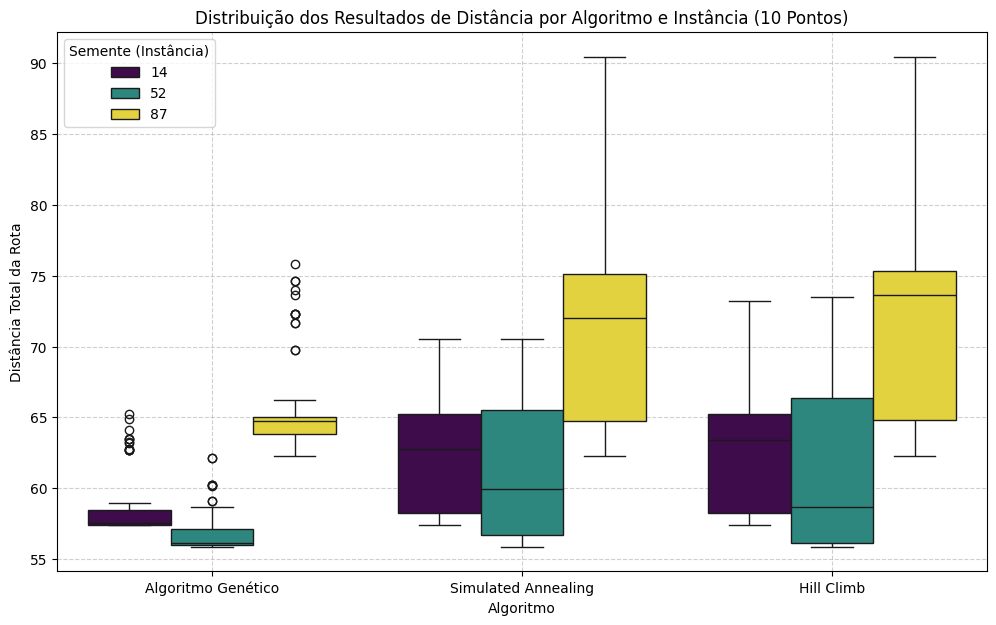

In [ ]:
plt.figure(figsize=(12, 7))
sns.boxplot(data=agrupado_10, x='Algoritmo', y='Distância Total', hue="Semente", palette='viridis')
plt.title('Distribuição dos Resultados de Distância por Algoritmo e Instância (10 Pontos)')
plt.ylabel('Distância Total da Rota')
plt.xlabel('Algoritmo')
plt.legend(title='Semente (Instância)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

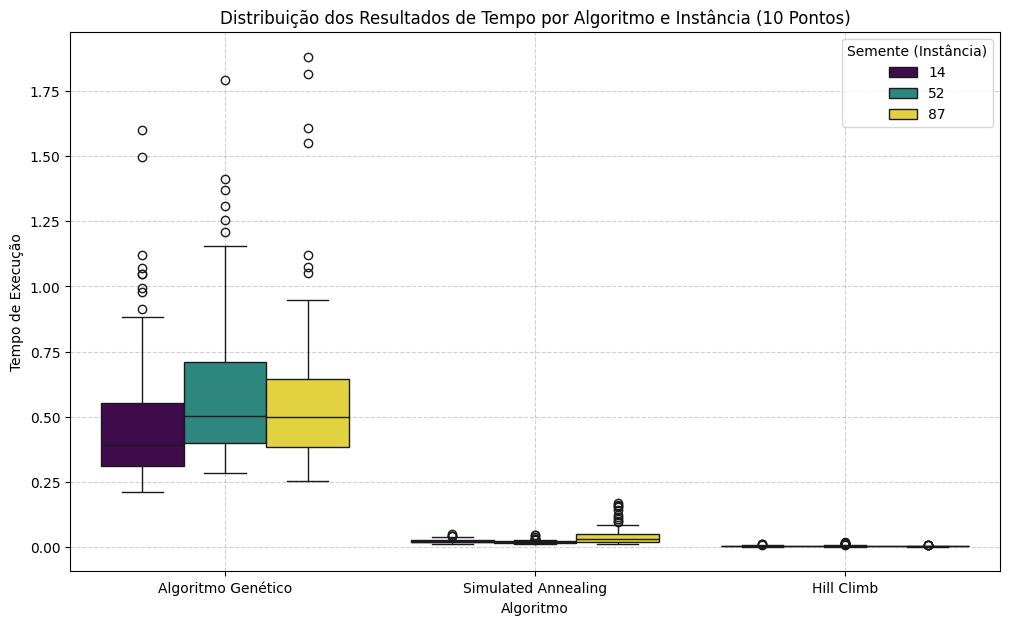

In [ ]:
plt.figure(figsize=(12, 7))
sns.boxplot(data=agrupado_10, x='Algoritmo', y='Tempo de Execução', hue="Semente", palette='viridis')
plt.title('Distribuição dos Resultados de Tempo por Algoritmo e Instância (10 Pontos)')
plt.ylabel('Tempo de Execução')
plt.xlabel('Algoritmo')
plt.legend(title='Semente (Instância)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

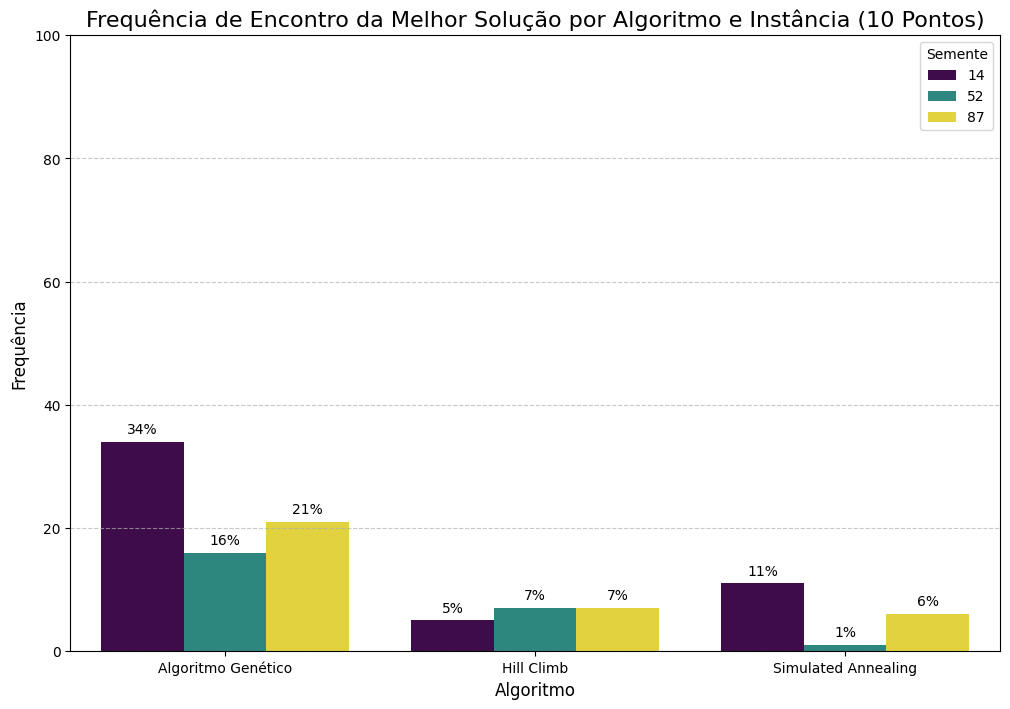

In [ ]:
plt.figure(figsize=(12, 8))
barplot = sns.barplot(
    data=df_frequencia_10,
    x='Algoritmo',
    y='Frequência Melhor Solução',
    hue='Semente',
    palette='viridis'
)
plt.title('Frequência de Encontro da Melhor Solução por Algoritmo e Instância (10 Pontos)', fontsize=16)
plt.ylabel('Frequência', fontsize=12)
plt.xlabel('Algoritmo', fontsize=12)
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)
for p in barplot.patches:
    height = p.get_height()
    if height > 0:
        barplot.annotate(
            format(height, '.0f') + '%',
            (p.get_x() + p.get_width() / 2., height),
            ha='center', va='center',
            xytext=(0, 9),
            textcoords='offset points'
        )
plt.show()

### 30 Pontos

#### Tabelas

In [ ]:
df_estatisticas_30 = (
    agrupado_30.groupby(["Algoritmo", "Semente"])[["Distância Total", "Tempo de Execução"]]
    .agg({
        "Distância Total": ["mean", "std", "min", "max"],
        "Tempo de Execução": "mean"
    })
    .reset_index()
)

In [ ]:
df_estatisticas_30.columns = ["Algoritmo", "Semente", "Distância Média", "Desvio Padrão",
                        "Distância Mínima", "Distância Máxima", "Tempo Médio de Execução"]

In [ ]:
df_estatisticas_30

Algoritmo  Semente  Distância Média  Desvio Padrão  \
0   Algoritmo Genético       14       139.609637      12.132402   
1   Algoritmo Genético       52       163.005213      12.837247   
2   Algoritmo Genético       87       167.381292      14.279863   
3           Hill Climb       14       151.901149      14.633925   
4           Hill Climb       52       167.568232      10.631314   
5           Hill Climb       87       173.702791      12.051675   
6  Simulated Annealing       14       163.554462      13.445644   
7  Simulated Annealing       52       181.434707      13.238818   
8  Simulated Annealing       87       186.492042      16.643791   

   Distância Mínima  Distância Máxima  Tempo Médio de Execução  
0        118.824560        171.909159                 5.019687  
1        138.521851        202.432098                 3.443132  
2        142.046684        213.275715                 5.576026  
3        110.927742        182.857051                 0.137442  
4        142.753573        193.983969                 0.128131  
5        149.652663        203.757396                 0.139714  
6        132.931636        192.249395                 0.107554  
7        154.260290        219.337084                 0.040929  
8        151.868613        230.761265                 0.052571

In [ ]:
df_frequencia_30 = (
    agrupado_30.groupby(["Algoritmo", "Semente"])["Distância Total"]
    .value_counts()
    .reset_index(name="Frequência Melhor Solução")
    .sort_values(by=["Algoritmo", "Semente", "Distância Total"])
    .groupby(["Algoritmo", "Semente"])
    .first())

In [ ]:
df_frequencia_30

Distância Total  Frequência Melhor Solução
Algoritmo           Semente                                            
Algoritmo Genético  14            118.824560                          1
                    52            138.521851                          1
                    87            142.046684                          1
Hill Climb          14            110.927742                          1
                    52            142.753573                          1
                    87            149.652663                          1
Simulated Annealing 14            132.931636                          1
                    52            154.260290                          1
                    87            151.868613                          1

In [ ]:
tabela_final_30 = pd.merge(df_estatisticas_30, df_frequencia_30["Frequência Melhor Solução"], on=["Algoritmo", "Semente"])

In [ ]:
tabela_final_30

Algoritmo  Semente  Distância Média  Desvio Padrão  \
0   Algoritmo Genético       14       139.609637      12.132402   
1   Algoritmo Genético       52       163.005213      12.837247   
2   Algoritmo Genético       87       167.381292      14.279863   
3           Hill Climb       14       151.901149      14.633925   
4           Hill Climb       52       167.568232      10.631314   
5           Hill Climb       87       173.702791      12.051675   
6  Simulated Annealing       14       163.554462      13.445644   
7  Simulated Annealing       52       181.434707      13.238818   
8  Simulated Annealing       87       186.492042      16.643791   

   Distância Mínima  Distância Máxima  Tempo Médio de Execução  \
0        118.824560        171.909159                 5.019687   
1        138.521851        202.432098                 3.443132   
2        142.046684        213.275715                 5.576026   
3        110.927742        182.857051                 0.137442   
4        142.753573        193.983969                 0.128131   
5        149.652663        203.757396                 0.139714   
6        132.931636        192.249395                 0.107554   
7        154.260290        219.337084                 0.040929   
8        151.868613        230.761265                 0.052571   

   Frequência Melhor Solução  
0                          1  
1                          1  
2                          1  
3                          1  
4                          1  
5                          1  
6                          1  
7                          1  
8                          1

#### Gráficos

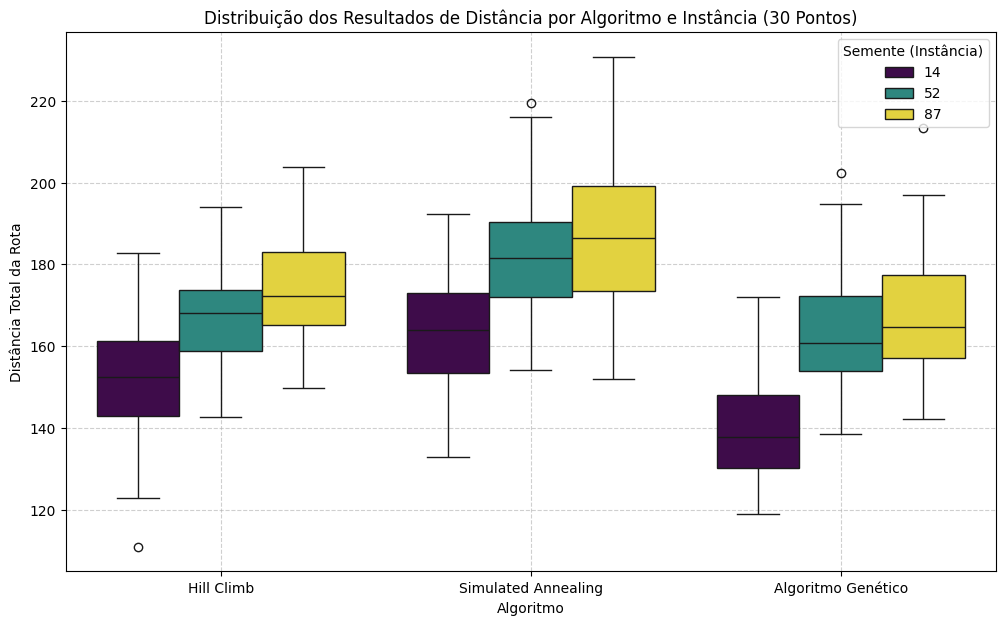

In [ ]:
plt.figure(figsize=(12, 7))
sns.boxplot(data=agrupado_30, x='Algoritmo', y='Distância Total', hue="Semente", palette='viridis')
plt.title('Distribuição dos Resultados de Distância por Algoritmo e Instância (30 Pontos)')
plt.ylabel('Distância Total da Rota')
plt.xlabel('Algoritmo')
plt.legend(title='Semente (Instância)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

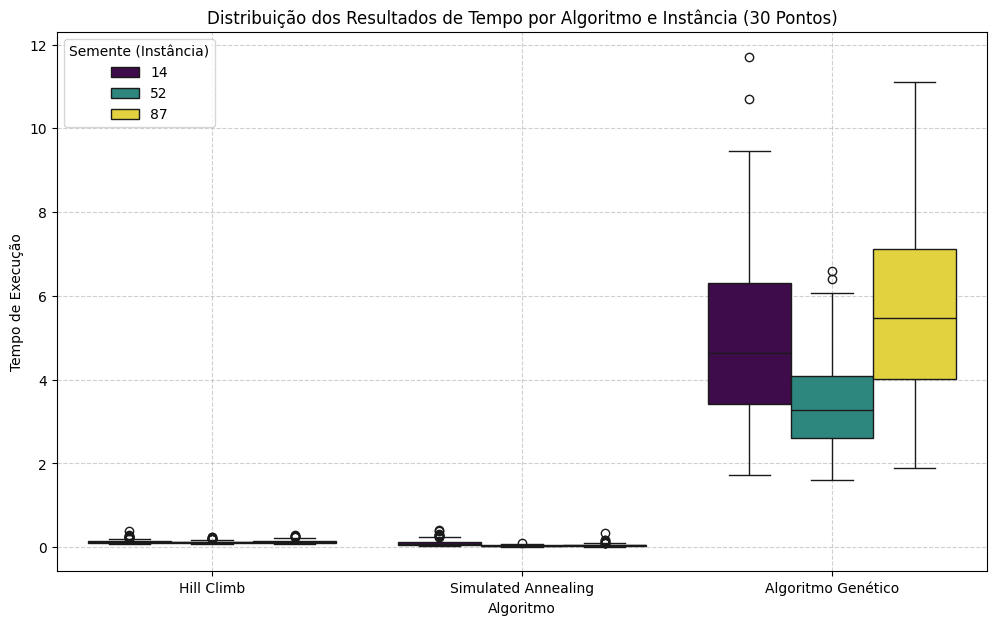

In [ ]:
plt.figure(figsize=(12, 7))
sns.boxplot(data=agrupado_30, x='Algoritmo', y='Tempo de Execução', hue="Semente", palette='viridis')
plt.title('Distribuição dos Resultados de Tempo por Algoritmo e Instância (30 Pontos)')
plt.ylabel('Tempo de Execução')
plt.xlabel('Algoritmo')
plt.legend(title='Semente (Instância)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

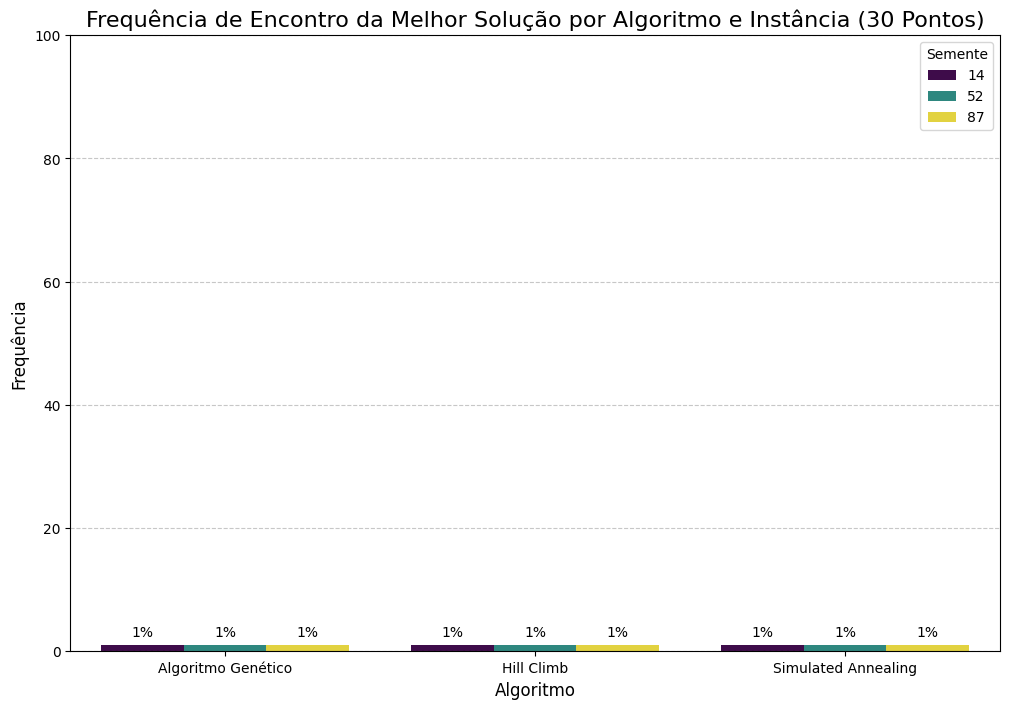

In [ ]:
plt.figure(figsize=(12, 8))
barplot = sns.barplot(
    data=df_frequencia_30,
    x='Algoritmo',
    y='Frequência Melhor Solução',
    hue='Semente',
    palette='viridis'
)
plt.title('Frequência de Encontro da Melhor Solução por Algoritmo e Instância (30 Pontos)', fontsize=16)
plt.ylabel('Frequência', fontsize=12)
plt.xlabel('Algoritmo', fontsize=12)
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)
for p in barplot.patches:
    height = p.get_height()
    if height > 0:
        barplot.annotate(
            format(height, '.0f') + '%',
            (p.get_x() + p.get_width() / 2., height),
            ha='center', va='center',
            xytext=(0, 9),
            textcoords='offset points'
        )
plt.show()

### 50 Pontos

#### Tabelas

In [ ]:
df_estatisticas_50 = (
    agrupado_50.groupby(["Algoritmo", "Semente"])[["Distância Total", "Tempo de Execução"]]
    .agg({
        "Distância Total": ["mean", "std", "min", "max"],
        "Tempo de Execução": "mean"
    })
    .reset_index()
)

In [ ]:
df_estatisticas_50.columns = ["Algoritmo", "Semente", "Distância Média", "Desvio Padrão",
                        "Distância Mínima", "Distância Máxima", "Tempo Médio de Execução"]

In [ ]:
df_estatisticas_50

Algoritmo  Semente  Distância Média  Desvio Padrão  \
0   Algoritmo Genético       14       192.956017      14.444550   
1   Algoritmo Genético       52       201.397598      13.843441   
2   Algoritmo Genético       87       206.017285      16.067263   
3           Hill Climb       14       230.837690      19.261773   
4           Hill Climb       52       232.765255      16.943308   
5           Hill Climb       87       246.471605      20.651585   
6  Simulated Annealing       14       259.364411      20.063652   
7  Simulated Annealing       52       265.313227      17.431081   
8  Simulated Annealing       87       289.243207      27.213460   

   Distância Mínima  Distância Máxima  Tempo Médio de Execução  
0        160.996792        247.283601                35.083848  
1        169.822072        239.367133                48.939470  
2        173.702890        265.963075                50.031525  
3        193.125363        286.578587                 1.694946  
4        197.596413        275.078634                 1.186001  
5        204.912476        289.926541                 1.775906  
6        223.464901        344.242392                 0.102888  
7        226.318046        306.850968                 0.108547  
8        242.701869        380.137670                 0.246009

In [ ]:
df_frequencia_50 = (
    agrupado_50.groupby(["Algoritmo", "Semente"])["Distância Total"]
    .value_counts()
    .reset_index(name="Frequência Melhor Solução")
    .sort_values(by=["Algoritmo", "Semente", "Distância Total"])
    .groupby(["Algoritmo", "Semente"])
    .first())

In [ ]:
df_frequencia_50

Distância Total  Frequência Melhor Solução
Algoritmo           Semente                                            
Algoritmo Genético  14            160.996792                          1
                    52            169.822072                          1
                    87            173.702890                          1
Hill Climb          14            193.125363                          1
                    52            197.596413                          1
                    87            204.912476                          1
Simulated Annealing 14            223.464901                          1
                    52            226.318046                          1
                    87            242.701869                          1

In [ ]:
tabela_final_50 = pd.merge(df_estatisticas_50, df_frequencia_50["Frequência Melhor Solução"], on=["Algoritmo", "Semente"])

In [ ]:
tabela_final_50

Algoritmo  Semente  Distância Média  Desvio Padrão  \
0   Algoritmo Genético       14       192.956017      14.444550   
1   Algoritmo Genético       52       201.397598      13.843441   
2   Algoritmo Genético       87       206.017285      16.067263   
3           Hill Climb       14       230.837690      19.261773   
4           Hill Climb       52       232.765255      16.943308   
5           Hill Climb       87       246.471605      20.651585   
6  Simulated Annealing       14       259.364411      20.063652   
7  Simulated Annealing       52       265.313227      17.431081   
8  Simulated Annealing       87       289.243207      27.213460   

   Distância Mínima  Distância Máxima  Tempo Médio de Execução  \
0        160.996792        247.283601                35.083848   
1        169.822072        239.367133                48.939470   
2        173.702890        265.963075                50.031525   
3        193.125363        286.578587                 1.694946   
4        197.596413        275.078634                 1.186001   
5        204.912476        289.926541                 1.775906   
6        223.464901        344.242392                 0.102888   
7        226.318046        306.850968                 0.108547   
8        242.701869        380.137670                 0.246009   

   Frequência Melhor Solução  
0                          1  
1                          1  
2                          1  
3                          1  
4                          1  
5                          1  
6                          1  
7                          1  
8                          1

#### Gráficos

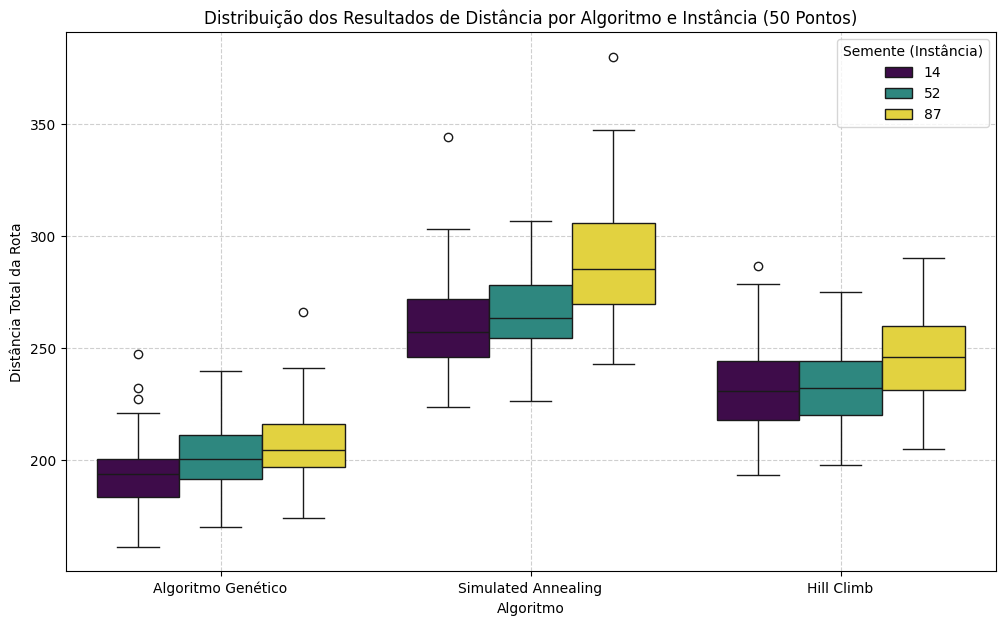

In [ ]:
plt.figure(figsize=(12, 7))
sns.boxplot(data=agrupado_50, x='Algoritmo', y='Distância Total', hue="Semente", palette='viridis')
plt.title('Distribuição dos Resultados de Distância por Algoritmo e Instância (50 Pontos)')
plt.ylabel('Distância Total da Rota')
plt.xlabel('Algoritmo')
plt.legend(title='Semente (Instância)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

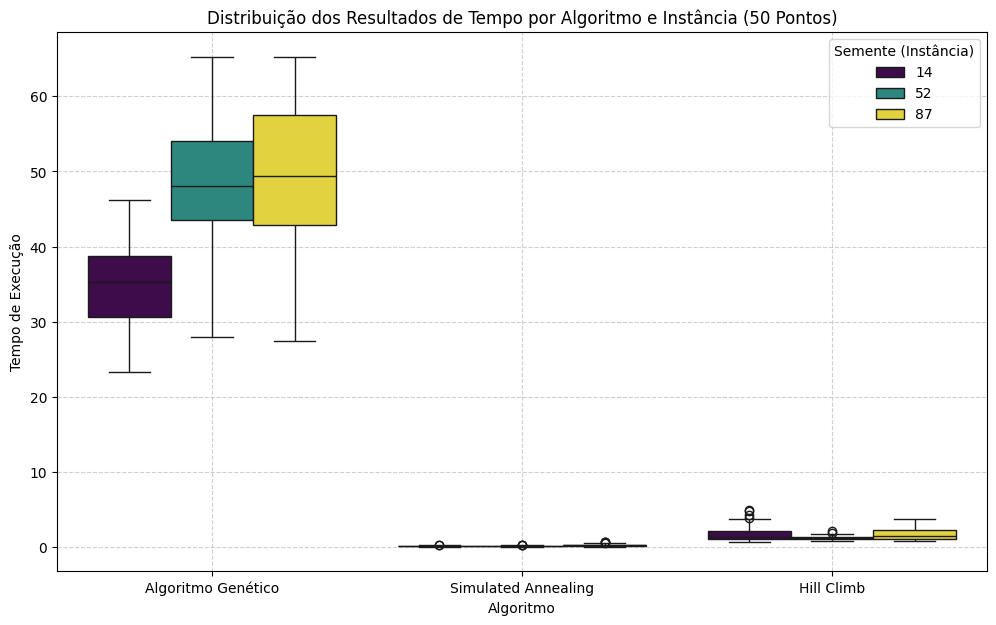

In [ ]:
plt.figure(figsize=(12, 7))
sns.boxplot(data=agrupado_50, x='Algoritmo', y='Tempo de Execução', hue="Semente", palette='viridis')
plt.title('Distribuição dos Resultados de Tempo por Algoritmo e Instância (50 Pontos)')
plt.ylabel('Tempo de Execução')
plt.xlabel('Algoritmo')
plt.legend(title='Semente (Instância)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

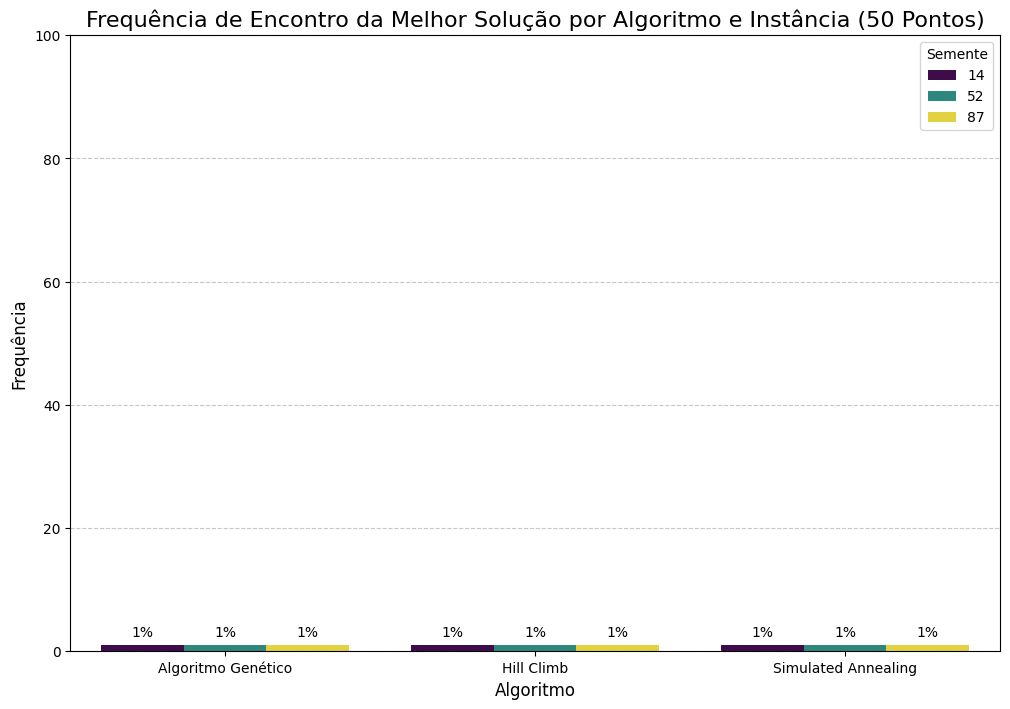

In [ ]:
plt.figure(figsize=(12, 8))
barplot = sns.barplot(
    data=df_frequencia_50,
    x='Algoritmo',
    y='Frequência Melhor Solução',
    hue='Semente',
    palette='viridis'
)
plt.title('Frequência de Encontro da Melhor Solução por Algoritmo e Instância (50 Pontos)', fontsize=16)
plt.ylabel('Frequência', fontsize=12)
plt.xlabel('Algoritmo', fontsize=12)
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)
for p in barplot.patches:
    height = p.get_height()
    if height > 0:
        barplot.annotate(
            format(height, '.0f') + '%',
            (p.get_x() + p.get_width() / 2., height),
            ha='center', va='center',
            xytext=(0, 9),
            textcoords='offset points'
        )
plt.show()

### 100 Pontos

#### Tabelas

In [ ]:
df_estatisticas_100 = (
    agrupado_100.groupby(["Algoritmo", "Semente"])[["Distância Total", "Tempo de Execução"]]
    .agg({
        "Distância Total": ["mean", "std", "min", "max"],
        "Tempo de Execução": "mean"
    })
    .reset_index()
)

In [ ]:
df_estatisticas_100.columns = ["Algoritmo", "Semente", "Distância Média", "Desvio Padrão",
                        "Distância Mínima", "Distância Máxima", "Tempo Médio de Execução"]

In [ ]:
df_estatisticas_100

Algoritmo  Semente  Distância Média  Desvio Padrão  \
0   Algoritmo Genético       14       366.889231      17.949959   
1   Algoritmo Genético       52       363.199564      21.851212   
2   Algoritmo Genético       87       360.882475      21.331323   
3           Hill Climb       14       390.932440      28.182270   
4           Hill Climb       52       398.281859      24.166680   
5           Hill Climb       87       401.583327      25.434245   
6  Simulated Annealing       14       519.215236      31.181280   
7  Simulated Annealing       52       509.920315      35.686936   
8  Simulated Annealing       87       506.411816      31.386283   

   Distância Mínima  Distância Máxima  Tempo Médio de Execução  
0        319.257637        414.120268               202.519016  
1        319.836204        446.786184               188.245650  
2        303.315541        405.707871               193.748162  
3        325.283442        460.948954                21.027192  
4        348.781683        462.777970                32.273147  
5        322.006487        468.822521                32.256764  
6        436.611819        605.979385                 0.231516  
7        442.435837        612.326482                 0.222047  
8        430.970595        587.364385                 0.233525

In [ ]:
df_frequencia_100 = (
    agrupado_100.groupby(["Algoritmo", "Semente"])["Distância Total"]
    .value_counts()
    .reset_index(name="Frequência Melhor Solução")
    .sort_values(by=["Algoritmo", "Semente", "Distância Total"])
    .groupby(["Algoritmo", "Semente"])
    .first())

In [ ]:
df_frequencia_100

Distância Total  Frequência Melhor Solução
Algoritmo           Semente                                            
Algoritmo Genético  14            319.257637                          1
                    52            319.836204                          1
                    87            303.315541                          1
Hill Climb          14            325.283442                          1
                    52            348.781683                          1
                    87            322.006487                          1
Simulated Annealing 14            436.611819                          1
                    52            442.435837                          1
                    87            430.970595                          1

In [ ]:
tabela_final_100 = pd.merge(df_estatisticas_100, df_frequencia_100["Frequência Melhor Solução"], on=["Algoritmo", "Semente"])

In [ ]:
tabela_final_100

Algoritmo  Semente  Distância Média  Desvio Padrão  \
0   Algoritmo Genético       14       366.889231      17.949959   
1   Algoritmo Genético       52       363.199564      21.851212   
2   Algoritmo Genético       87       360.882475      21.331323   
3           Hill Climb       14       390.932440      28.182270   
4           Hill Climb       52       398.281859      24.166680   
5           Hill Climb       87       401.583327      25.434245   
6  Simulated Annealing       14       519.215236      31.181280   
7  Simulated Annealing       52       509.920315      35.686936   
8  Simulated Annealing       87       506.411816      31.386283   

   Distância Mínima  Distância Máxima  Tempo Médio de Execução  \
0        319.257637        414.120268               202.519016   
1        319.836204        446.786184               188.245650   
2        303.315541        405.707871               193.748162   
3        325.283442        460.948954                21.027192   
4        348.781683        462.777970                32.273147   
5        322.006487        468.822521                32.256764   
6        436.611819        605.979385                 0.231516   
7        442.435837        612.326482                 0.222047   
8        430.970595        587.364385                 0.233525   

   Frequência Melhor Solução  
0                          1  
1                          1  
2                          1  
3                          1  
4                          1  
5                          1  
6                          1  
7                          1  
8                          1

#### Gráficos

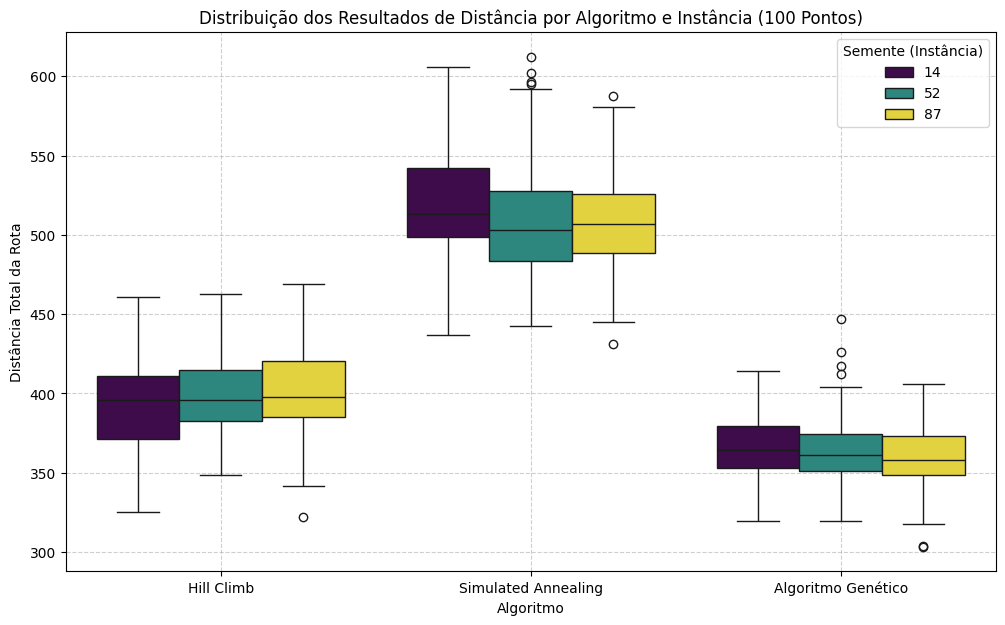

In [ ]:
plt.figure(figsize=(12, 7))
sns.boxplot(data=agrupado_100, x='Algoritmo', y='Distância Total', hue="Semente", palette='viridis')
plt.title('Distribuição dos Resultados de Distância por Algoritmo e Instância (100 Pontos)')
plt.ylabel('Distância Total da Rota')
plt.xlabel('Algoritmo')
plt.legend(title='Semente (Instância)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

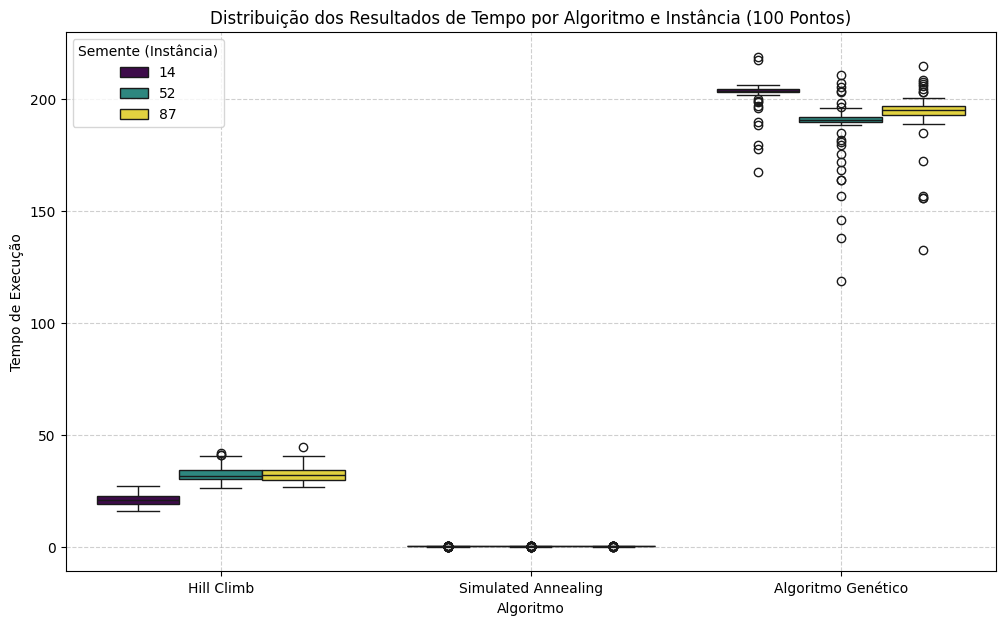

In [ ]:
plt.figure(figsize=(12, 7))
sns.boxplot(data=agrupado_100, x='Algoritmo', y='Tempo de Execução', hue="Semente", palette='viridis')
plt.title('Distribuição dos Resultados de Tempo por Algoritmo e Instância (100 Pontos)')
plt.ylabel('Tempo de Execução')
plt.xlabel('Algoritmo')
plt.legend(title='Semente (Instância)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

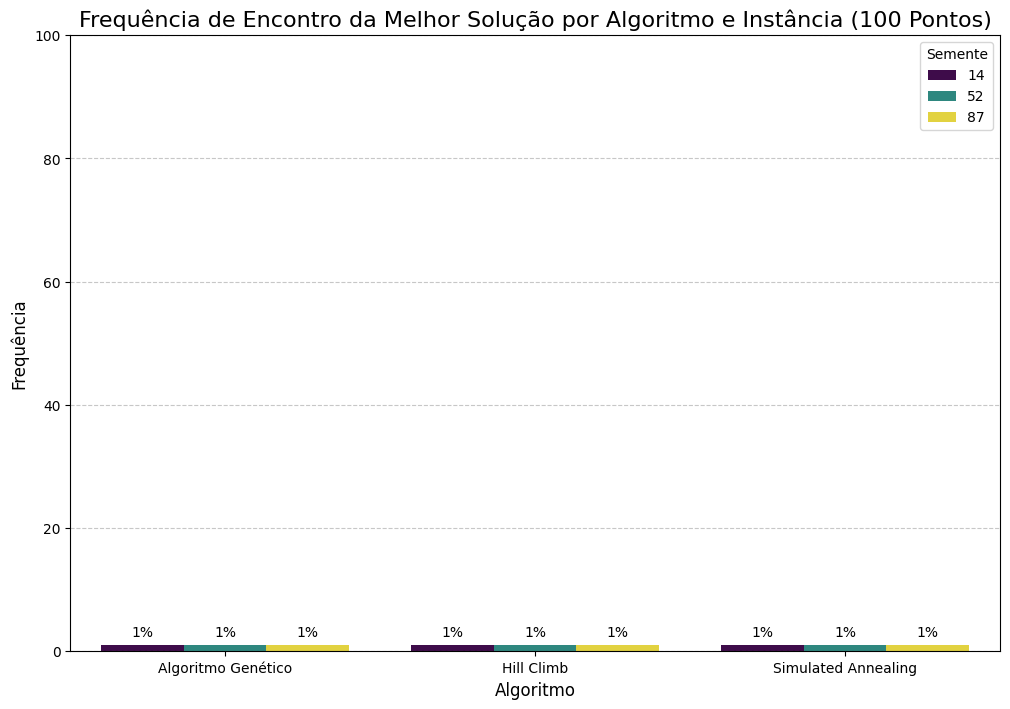

In [ ]:
plt.figure(figsize=(12, 8))
barplot = sns.barplot(
    data=df_frequencia_100,
    x='Algoritmo',
    y='Frequência Melhor Solução',
    hue='Semente',
    palette='viridis'
)
plt.title('Frequência de Encontro da Melhor Solução por Algoritmo e Instância (100 Pontos)', fontsize=16)
plt.ylabel('Frequência', fontsize=12)
plt.xlabel('Algoritmo', fontsize=12)
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)
for p in barplot.patches:
    height = p.get_height()
    if height > 0:
        barplot.annotate(
            format(height, '.0f') + '%',
            (p.get_x() + p.get_width() / 2., height),
            ha='center', va='center',
            xytext=(0, 9),
            textcoords='offset points'
        )
plt.show()

### Análise Geral

In [ ]:
df_resumo_total = pd.read_csv("/content/drive/MyDrive/TCC/df_resumo_agregado_total.csv")

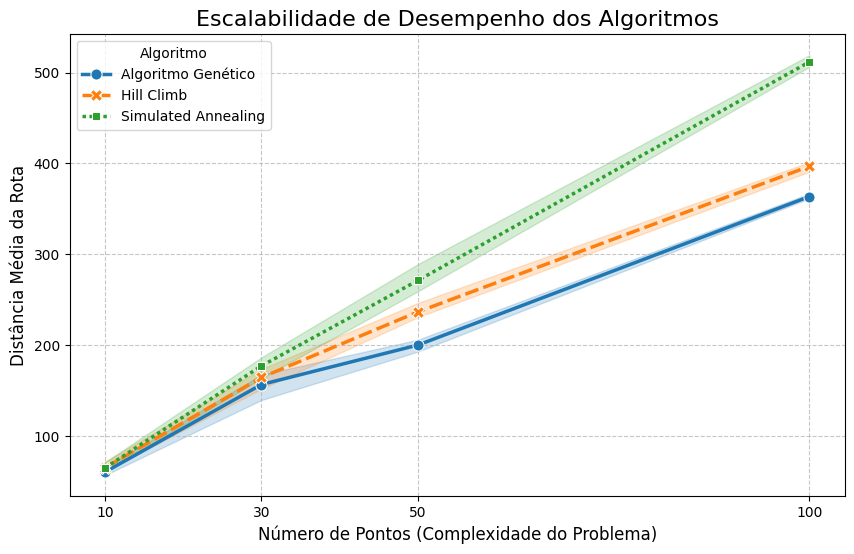

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df_resumo_total,
    x='Pontos',
    y='Distância Média',
    hue='Algoritmo',
    style='Algoritmo',
    markers=True,
    linewidth=2.5,
    markersize=8
)

plt.title('Escalabilidade de Desempenho dos Algoritmos', fontsize=16)
plt.xlabel('Número de Pontos (Complexidade do Problema)', fontsize=12)
plt.ylabel('Distância Média da Rota', fontsize=12)
plt.xticks([10, 30, 50, 100])
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Algoritmo')
plt.show()

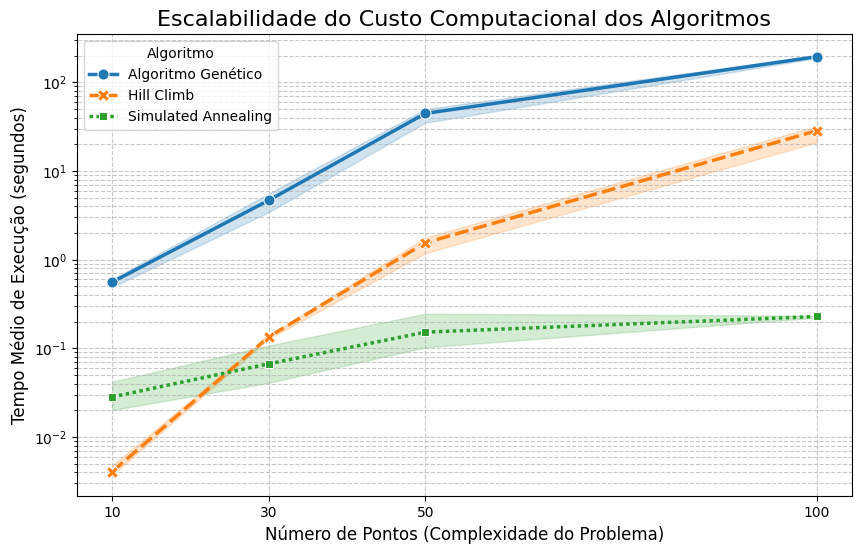

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df_resumo_total,
    x='Pontos',
    y='Tempo Médio de Execução',
    hue='Algoritmo',
    style='Algoritmo',
    markers=True,
    linewidth=2.5,
    markersize=8
)
plt.yscale('log')
plt.title('Escalabilidade do Custo Computacional dos Algoritmos', fontsize=16)
plt.xlabel('Número de Pontos (Complexidade do Problema)', fontsize=12)
plt.ylabel('Tempo Médio de Execução (segundos)', fontsize=12)
plt.xticks([10, 30, 50, 100])
plt.grid(True, which='both', linestyle='--', alpha=0.7)
plt.legend(title='Algoritmo')
plt.show()

In [ ]:
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import LogFormatter, LogLocator

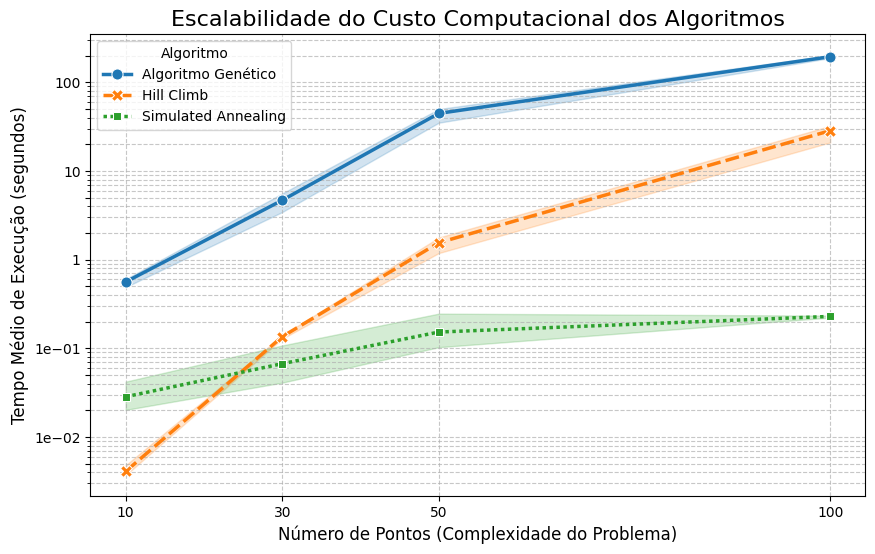

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df_resumo_total,
    x='Pontos',
    y='Tempo Médio de Execução',
    hue='Algoritmo',
    style='Algoritmo',
    markers=True,
    linewidth=2.5,
    markersize=8
)
plt.yscale('log')
ax = plt.gca()
ax.yaxis.set_major_locator(LogLocator(base=10.0, subs=[1,2,5], numticks=10))
ax.yaxis.set_major_formatter(LogFormatter(base=10, labelOnlyBase=False))
plt.title('Escalabilidade do Custo Computacional dos Algoritmos', fontsize=16)
plt.xlabel('Número de Pontos (Complexidade do Problema)', fontsize=12)
plt.ylabel('Tempo Médio de Execução (segundos)', fontsize=12)
plt.xticks([10, 30, 50, 100])
plt.grid(True, which='both', linestyle='--', alpha=0.7)
plt.legend(title='Algoritmo')
plt.show()